 # Recommender system based on the h&m dataset from the kaggle competition

* 2 models are built throughout this notebook:

    * Collaborative filtering model for warm items
    * Hybrid model to tackle cold start items

 # Step 1: Data Exploration & Understanding

 First, we will start by importing all the necessary libraries and tools necessary for the libraries

 ## Libraries and tools

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import ndcg_score, roc_auc_score
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import time
import math
import os
from collections import Counter
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

import calendar
from IPython.display import display

NUM_THREADS = os.cpu_count() or 4
print(f"Configuration: NUM_THREADS = {NUM_THREADS} CPU cores")

/Users/slimmeddeb/Desktop/EMIASD/Recommender Systems/hm-env/lib/python3.10/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


Configuration: NUM_THREADS = 14 CPU cores


Enable interactive tables (itables) to display sortable tables later in the notebook.

In [2]:
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

 Since we're executing this notebook on a laptop, we want to take advantage from as much cores of the CPU as possible.

 This will allow us to run all the training and evaluation steps later faster.

 As stated in the lab guide, here's a resume of the objective of this first step.

 > Objective: Get familiar with the H&M dataset structure and characteristics.

 >

 > Key Questions to Explore:

 > - What does the interaction data look like? How many unique users and items do we have?

 > - What's the sparsity of the dataset? (Compare total possible interactions vs actual interactions)

 > - How are interactions distributed across users and items? Are there power users or blockbuster items?

 > - What time period does the data cover? Are there seasonal patterns?

 > - What metadata is available for items and customers?

 >

 ## Data import

Let's start with importing the data from the dataset.

Since this work has been done locally on my laptop,

The dataset contains 3 csv files: articles.csv, customer.csv and transactions.csv

We will use Pandas library to load them in dataframes entirely

In [ ]:
transactions = pd.read_csv('h_and_m_data/transactions_train.csv', parse_dates=['t_dat'])
articles = pd.read_csv('h_and_m_data/articles.csv')
customers = pd.read_csv('h_and_m_data/customers.csv')

In [4]:
print(f"Loaded {len(transactions):,} transactions")
print(f"Loaded {len(articles):,} articles")
print(f"Loaded {len(customers):,} customers")

Loaded 31,788,324 transactions
Loaded 105,542 articles
Loaded 1,371,980 customers


 Let's now print the columns of each dataframe to get an idea on the format and content of each dataframe

In [5]:
# Check columns and shapes
print("Transaction columns:", transactions.columns.tolist())
print("Article columns:", articles.columns.tolist())
print("Customer columns:", customers.columns.tolist())
print("Shapes:", transactions.shape, articles.shape, customers.shape)

Transaction columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']
Article columns: ['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']
Customer columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
Shapes: (31788324, 5) (105542, 25) (1371980, 7)


 We can notice that the dataframes are quite large. Especially the transactions dataframe.

 Let's check the data types for the transactions dataframe

In [6]:
transactions.info()
articles.info()
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_gr

- Data Quality: All article metadata columns display 105,542 non-null counts, indicating that they are not affected by missing values. The customers dataframe contains several columns, including 'FN' (Fashion news) and 'Active', that have differing null counts. We will need to address null values during feature engineering. 

- Temporal Data: The t_date column was parsed to datetime64ns type. This is good for conducting temporal analysis and will allow for time-based splitting of data for the recommender system. 

  ### Question 1: What does the interaction data look like?

 Let's check the number of unique articles and unique customers in the transactions

In [7]:
print(f"Unique articles: {transactions['article_id'].nunique():,}")
print(f"Unique customers: {transactions['customer_id'].nunique():,}")

Unique articles: 104,547
Unique customers: 1,362,281


 We can see that the number of customers and articles in the transactions don't cover the whole extent of the articles and customers catalogues

In [8]:
print(f"Articles not in transactions: {articles['article_id'].nunique() - transactions['article_id'].nunique():,}")
print(f"Customers not in transactions: {customers['customer_id'].nunique() - transactions['customer_id'].nunique():,}")

Articles not in transactions: 995
Customers not in transactions: 9,699


  ### Question 2: What's the sparsity of the dataset?

In [9]:
n_users_total = customers['customer_id'].nunique()
n_items_total = articles['article_id'].nunique()
n_interactions_total = len(transactions)
sparsity = 100 * (1 - n_interactions_total / (n_users_total * n_items_total))

print(f"Total users: {n_users_total:,}")
print(f"Total items: {n_items_total:,}")
print(f"Total interactions: {n_interactions_total:,}")
print(f"Total possible interactions: {n_users_total * n_items_total:,}")
print(f"Sparsity: {sparsity:.4f}%")

Total users: 1,371,980
Total items: 105,542
Total interactions: 31,788,324
Total possible interactions: 144,801,513,160
Sparsity: 99.9780%


 The dataset is extremely sparse 99.978%, which means that only 0.022% of all possible user/item pairs have recorded interactions. This is normal in fashion retail where each customer only interacts with a small fraction of the available catalog.

  ### Question 3: How are interactions distributed? Power users and blockbuster items?

In [10]:
user_interactions = transactions.groupby('customer_id').size()
item_interactions = transactions.groupby('article_id').size()

print(f"User stats: min={user_interactions.min()}, mean={user_interactions.mean():.1f}, "
      f"median={user_interactions.median():.0f}, max={user_interactions.max()}")
print(f"Item stats: min={item_interactions.min()}, mean={item_interactions.mean():.1f}, "
      f"median={item_interactions.median():.0f}, max={item_interactions.max()}")

n_users_80 = user_interactions.nlargest(int(len(user_interactions) * 0.2)).sum()
n_items_80 = item_interactions.nlargest(int(len(item_interactions) * 0.2)).sum()

top20_users_interactions = (n_users_80 / n_interactions_total) * 100
top20_items_interactions = (n_items_80 / n_interactions_total) * 100

print(f"Top 20% items generate {top20_items_interactions:.1f}% of interactions")
print(f"Top 20% users generate {top20_users_interactions:.1f}% of interactions")

User stats: min=1, mean=23.3, median=9, max=1895
Item stats: min=1, mean=304.1, median=65, max=50287
Top 20% items generate 79.1% of interactions
Top 20% users generate 67.7% of interactions


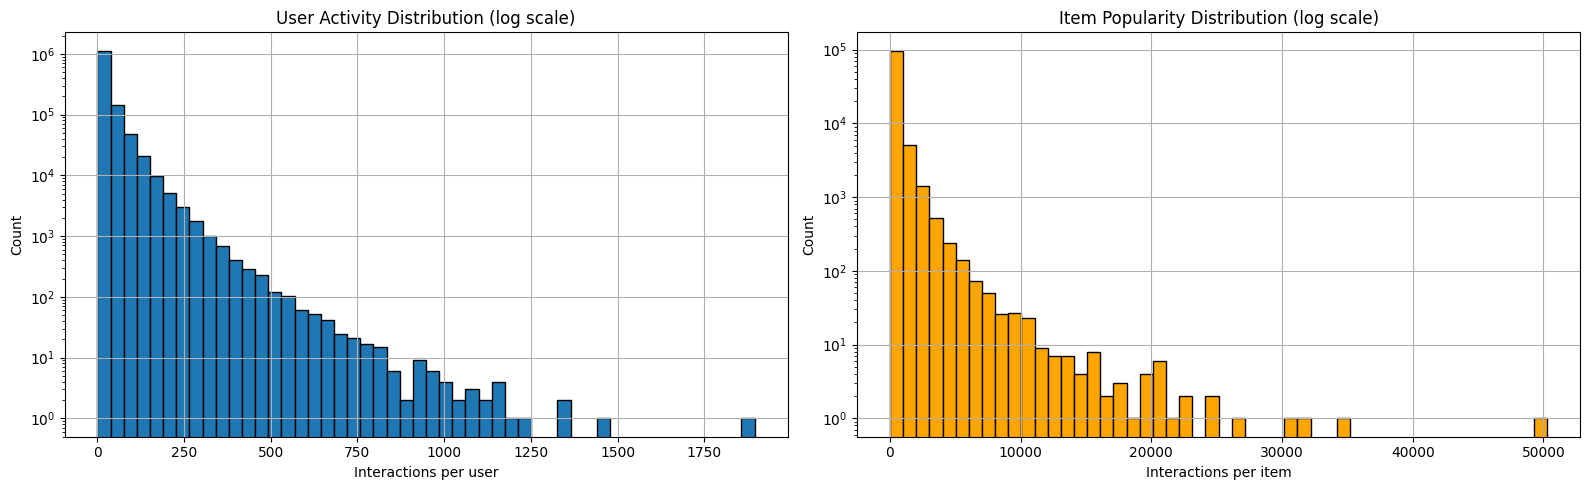

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

user_interactions.hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_yscale('log')
axes[0].set_title('User Activity Distribution (log scale)')
axes[0].set_xlabel('Interactions per user')
axes[0].set_ylabel('Count')

item_interactions.hist(bins=50, ax=axes[1], edgecolor='black', color='orange')
axes[1].set_yscale('log')
axes[1].set_title('Item Popularity Distribution (log scale)')
axes[1].set_xlabel('Interactions per item')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

 The interaction distributions reveal strong concentration patterns. The top 20% of items/ blockbusters drive more than 79% of all interactions, while the top 20% of users / power users account for almost 68% of activity. Both distributions follow heavy tail patterns, with median user activity at 9 interactions with mean 23 and median item popularity at 65 interactions with mean 304.

 Based on these observations, we can anticipate that this might create a cold start challenge for less popular items.

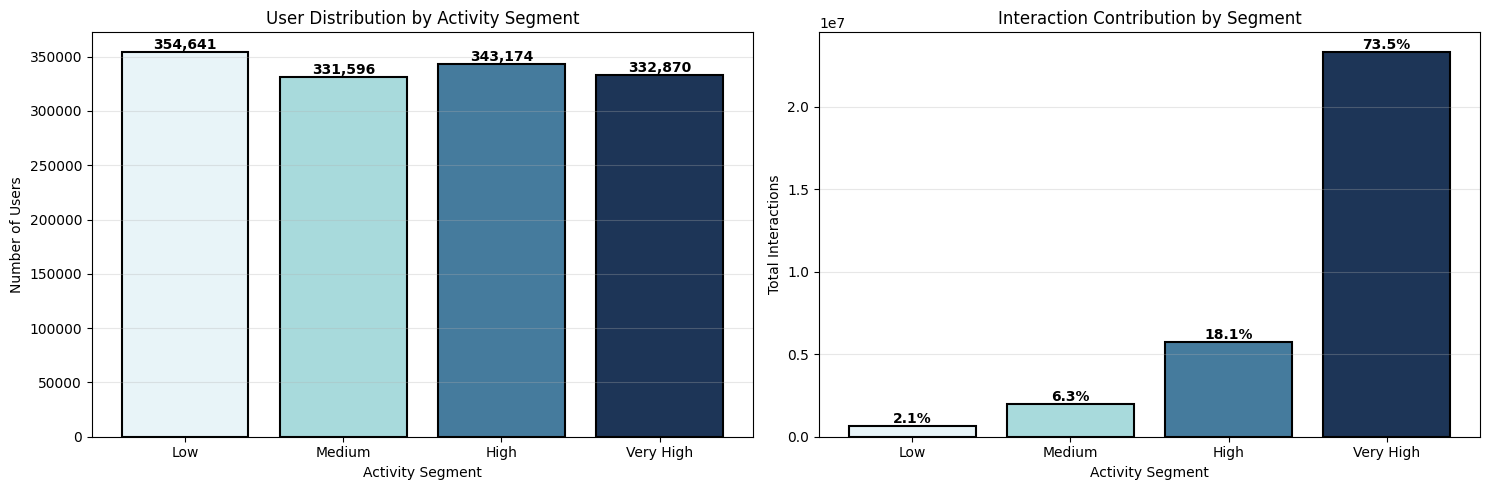

In [12]:
user_quartiles = user_interactions.quantile([0.25, 0.5, 0.75])
segments = {
    'Low': (user_interactions <= user_quartiles[0.25]),
    'Medium': (user_interactions > user_quartiles[0.25]) & (user_interactions <= user_quartiles[0.5]),
    'High': (user_interactions > user_quartiles[0.5]) & (user_interactions <= user_quartiles[0.75]),
    'Very High': (user_interactions > user_quartiles[0.75])
}

segment_stats = {}
for name, mask in segments.items():
    segment_users = user_interactions[mask]
    segment_stats[name] = {
        'users': len(segment_users),
        'total_interactions': segment_users.sum(),
        'avg_interactions': segment_users.mean(),
        'median_interactions': segment_users.median()
    }

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

segment_names = list(segment_stats.keys())
segment_counts = [segment_stats[s]['users'] for s in segment_names]
colors = ['#E8F4F8', '#A8DADC', '#457B9D', '#1D3557']

axes[0].bar(segment_names, segment_counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Distribution by Activity Segment')
axes[0].set_xlabel('Activity Segment')
for i, (name, count) in enumerate(zip(segment_names, segment_counts)):
    axes[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

interaction_contributions = [segment_stats[s]['total_interactions'] for s in segment_names]
axes[1].bar(segment_names, interaction_contributions, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Total Interactions')
axes[1].set_title('Interaction Contribution by Segment')
axes[1].set_xlabel('Activity Segment')
for i, (name, contrib) in enumerate(zip(segment_names, interaction_contributions)):
    pct = contrib / sum(interaction_contributions) * 100
    axes[1].text(i, contrib, f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



 This confirms the trend observed that the top users identified here a 'very high segment'. contribute the most to the volume of interactions (73%)

In [13]:
articles['prod_name'].isnull().sum()

np.int64(0)

 Let's check the top 20 articles bought and dive a little more into product types and age distributions to get a better idea of top transactions and behavior of customers based on different age groups

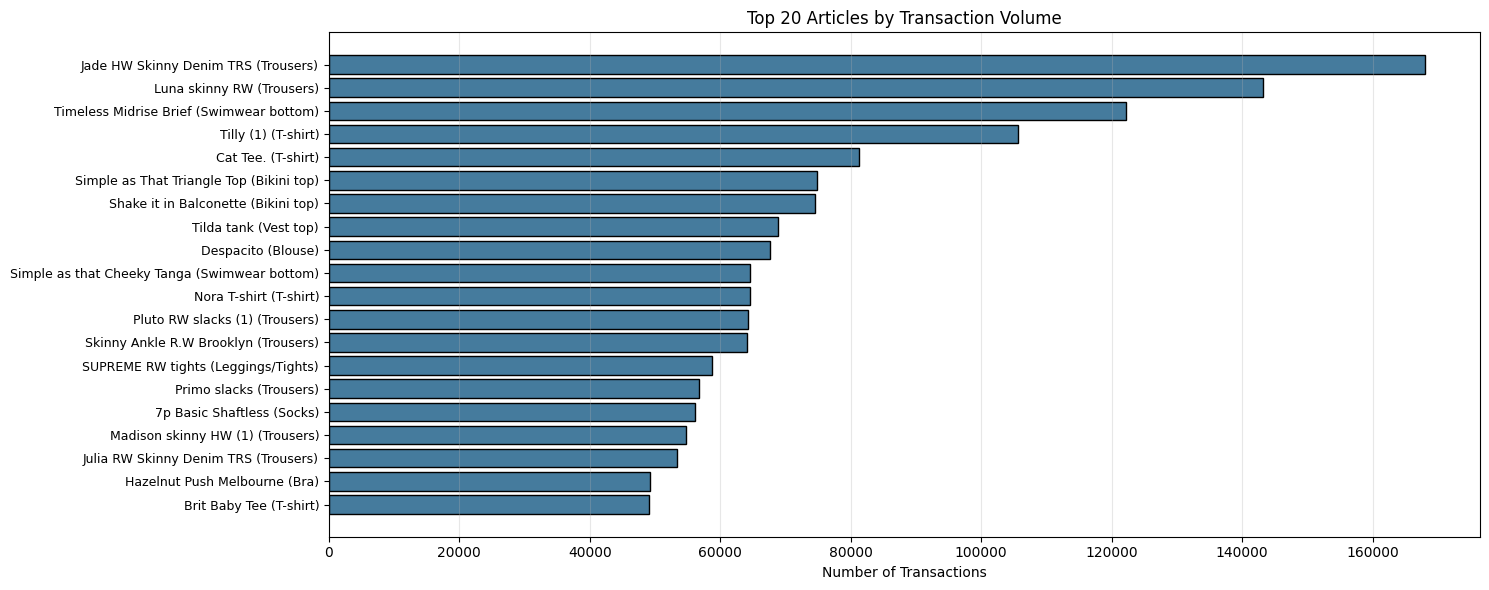

Category Statistics:
Unique product names: 45508
Top product name: Jade HW Skinny Denim TRS (168,052 transactions, 0.5%)


In [14]:
trans_with_articles = transactions.merge(
    articles[['article_id', 'prod_name', 'product_type_name','garment_group_name', 'product_group_name']],
    on='article_id', how='left'
)

product_counts = trans_with_articles['prod_name'].value_counts().head(20)
top_products = product_counts.index

label_map = trans_with_articles.drop_duplicates('prod_name').set_index('prod_name')['product_type_name']
y_labels = [f"{prod} ({label_map[prod]})" for prod in top_products]

fig, ax = plt.subplots(figsize=(15, 6))
ax.barh(range(len(product_counts)), product_counts.values, color='#457B9D', edgecolor='black')

ax.set_yticks(range(len(product_counts)))
ax.set_yticklabels(y_labels, fontsize=9)
ax.set_xlabel('Number of Transactions')
ax.set_title('Top 20 Articles by Transaction Volume')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Category Statistics:")
print(f"Unique product names: {trans_with_articles['prod_name'].nunique()}")
print(f"Top product name: {product_counts.index[0]} "
      f"({product_counts.iloc[0]:,} transactions, "
      f"{product_counts.iloc[0]/len(transactions)*100:.1f}%)")

 ### most and least popular items

In [15]:
top_items = trans_with_articles['article_id'].value_counts().head(20)
top_items = articles.set_index('article_id').loc[top_items.index][['prod_name', 'product_type_name', 'product_group_name', 'garment_group_name', 'department_name']]
top_items['transaction_count'] = trans_with_articles['article_id'].value_counts().head(20).values
show(top_items.reset_index())

bottom_items = trans_with_articles['article_id'].value_counts().tail(20)
bottom_items = articles.set_index('article_id').loc[bottom_items.index][['prod_name', 'product_type_name', 'product_group_name', 'garment_group_name', 'department_name']]
bottom_items['transaction_count'] = trans_with_articles['article_id'].value_counts().tail(20).values
show(bottom_items.reset_index())

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


 ### Top product types

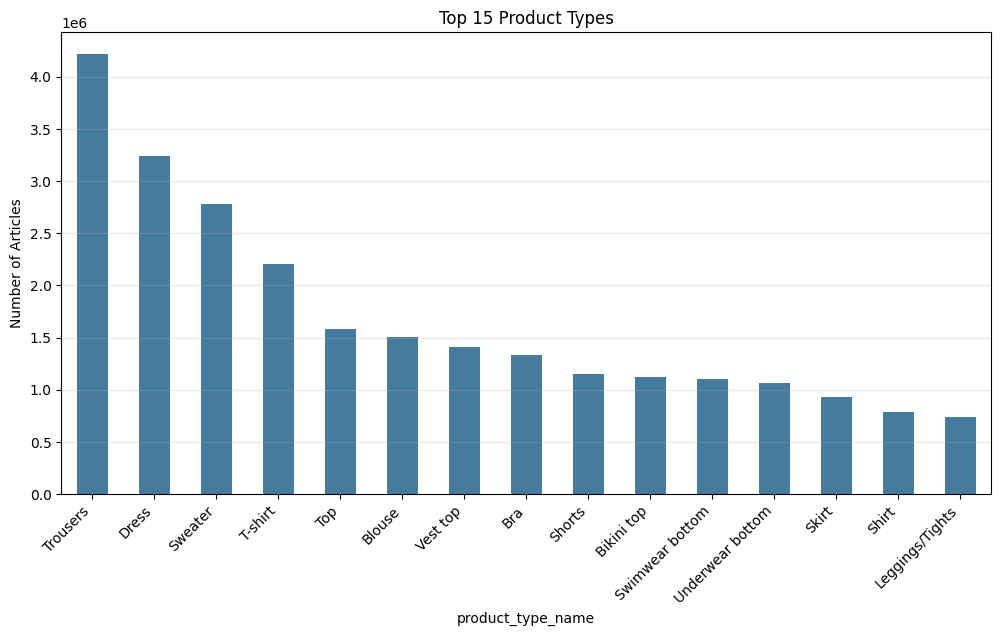

In [16]:
plt.figure(figsize=(12,6))
trans_with_articles['product_type_name'].value_counts().head(15).plot(kind='bar', color='#457B9D')
plt.title('Top 15 Product Types')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()

1.  Concentration in Categories: We find a significant concentration in sales of the few product types (e.g., Trousers, Dresses, Sweaters) suggesting that these are H&M's core categories. 

2. Long Tail Catalog: Concentrated sales in top categories and many articles receive limited sales exposure : long tail dilemna

3. Implications for a Recommendation Strategy:
   - Collaborative filtering is probably most useful for the top categories because of many interaction signals
   - The niche categories will likely require a content based or hybrid recommendation strategy to take into account the lack of exposure

4. Business Context: The concentration of product types is not surprising since H&M's strategy tend to focus on top of wardrobe necessities with big turnover. 

This category structure will help guide our feature engineering work and may warrant fine tuning and category aware recommendation strategies. 

 ### Age distribution

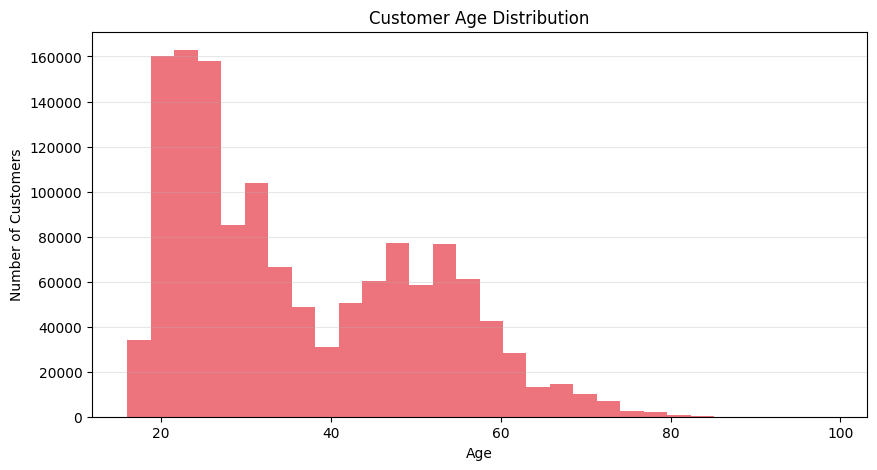

In [17]:
plt.figure(figsize=(10,5))
customers['age'].dropna().plot(kind='hist', bins=30, color='#E63946', alpha=0.7)
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.3)
plt.show()

The age distribution indicates: 

1. Primary demographic: 20 to 30 yo customers

2. Right tail that extends into older ages

3. Data quality note: No noticeable outliers here 

This distribution matters for developing user age based segments and understanding the behaviors of the different segments in our recommendation approach.

In [18]:
merged = transactions.merge(customers[['customer_id','age']], on='customer_id', how='left') \
                     .merge(articles[['article_id','product_type_name']], on='article_id', how='left')

merged = merged[merged['age'].between(0, 100)]
bins   = [0,20,30,40,50,60,100]
labels = ['0–19','20–29','30–39','40–49','50–59','60+']
merged['age_group'] = pd.cut(merged['age'], bins=bins, labels=labels, right=False, ordered=True)

K = 7
top_types = merged['product_type_name'].value_counts().nlargest(K).index
df = merged[merged['product_type_name'].isin(top_types)]

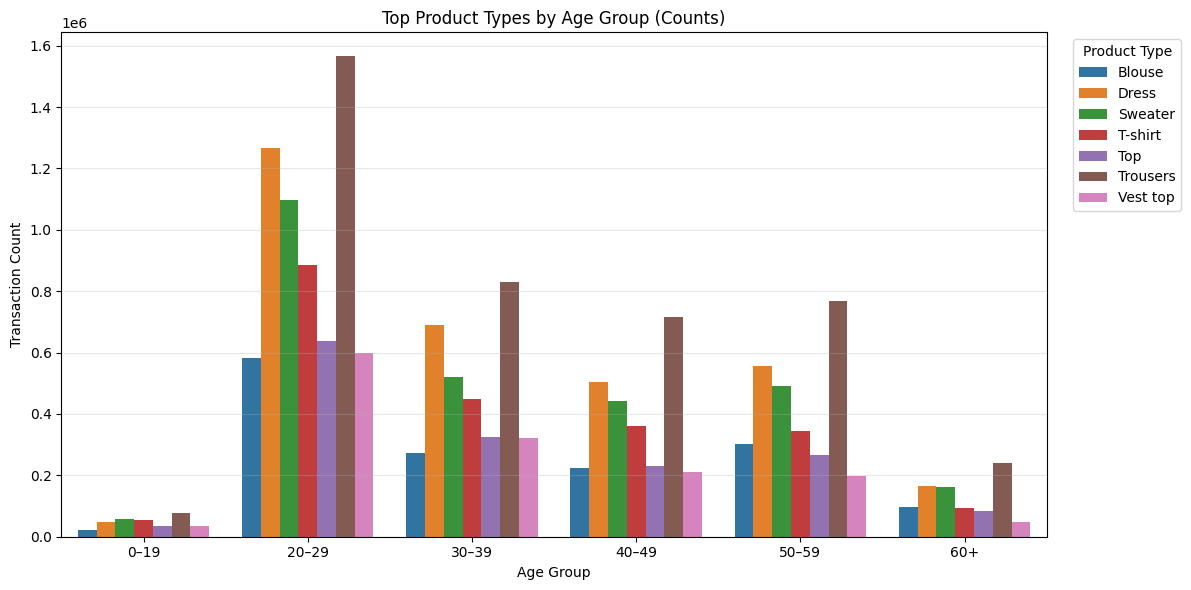

In [19]:
counts = (df.groupby(['age_group','product_type_name'])
            .size().reset_index(name='count'))

plt.figure(figsize=(12,6))
sns.barplot(data=counts, x='age_group', y='count', hue='product_type_name')
plt.title('Top Product Types by Age Group (Counts)')
plt.xlabel('Age Group'); plt.ylabel('Transaction Count')
plt.legend(title='Product Type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

 The age group 20 to 30 is driving an important volume of transactions.

 Trousers, dresses and sweaters seems to be the top three product types being sold across all age groups.

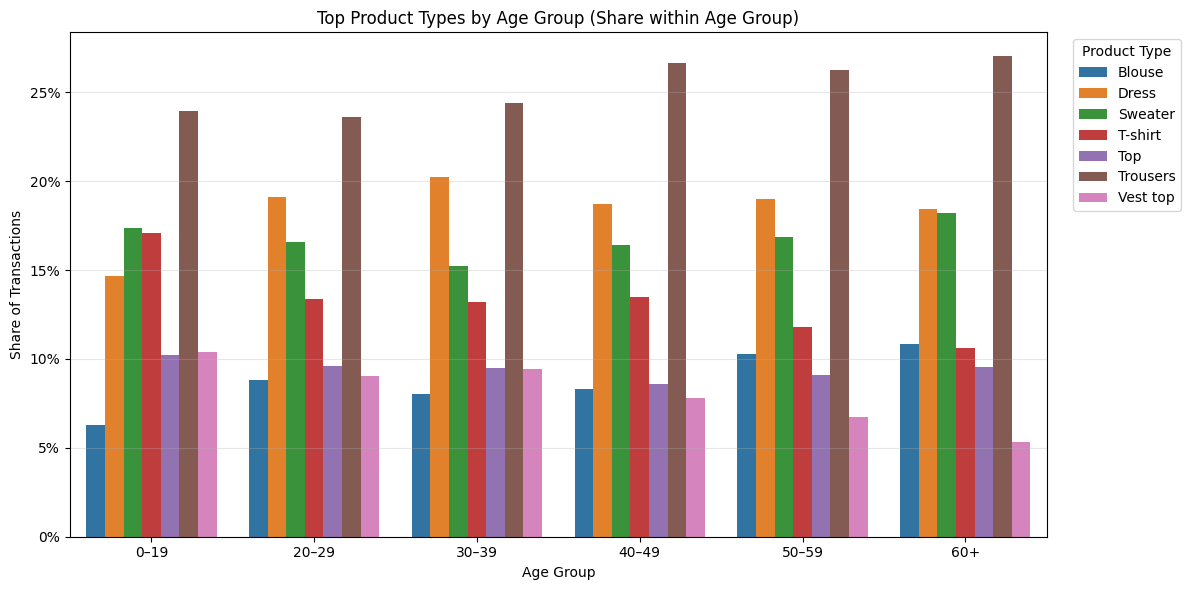

In [20]:
counts['share'] = counts.groupby('age_group')['count'].transform(lambda x: x / x.sum())
plt.figure(figsize=(12,6))
sns.barplot(data=counts, x='age_group', y='share', hue='product_type_name')
plt.title('Top Product Types by Age Group (Share within Age Group)')
plt.xlabel('Age Group'); plt.ylabel('Share of Transactions')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')
plt.legend(title='Product Type', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Similar share of sales of these different product types among different age groups. This confirms the importance of these product types.

 ###  Question 4: What time period does the data cover? Are there seasonal patterns?

 Let's explore the data range of the transactions

In [21]:
print(f"Date range: {transactions['t_dat'].min().date()} - {transactions['t_dat'].max().date()}")

Date range: 2018-09-20 - 2020-09-22


In [22]:
tx = transactions.copy()
tx['t_dat'] = pd.to_datetime(tx['t_dat'], errors='coerce')
tx['year'] = tx['t_dat'].dt.year
tx['month'] = tx['t_dat'].dt.month
tx['weekday'] = tx['t_dat'].dt.dayofweek
tx['ym'] = tx['t_dat'].dt.to_period('M')

by_year = tx['year'].value_counts().sort_index().rename("Transactions")

show(by_year.reset_index())

month_names = {i: calendar.month_abbr[i] for i in range(1, 13)}
by_month = (tx.groupby(['year','month']).size()
              .unstack(fill_value=0)
              .rename(columns=month_names)
              .sort_index())
by_month['Total'] = by_month.sum(axis=1)
show(by_month.reset_index())

weekday_order = pd.CategoricalDtype(categories=list(calendar.day_name), ordered=True)
wd = (tx['weekday'].map({i: d for i, d in enumerate(calendar.day_name)})
                .astype(weekday_order)
                .value_counts(sort=False)
                .rename("Transactions"))

show(wd.reset_index())

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


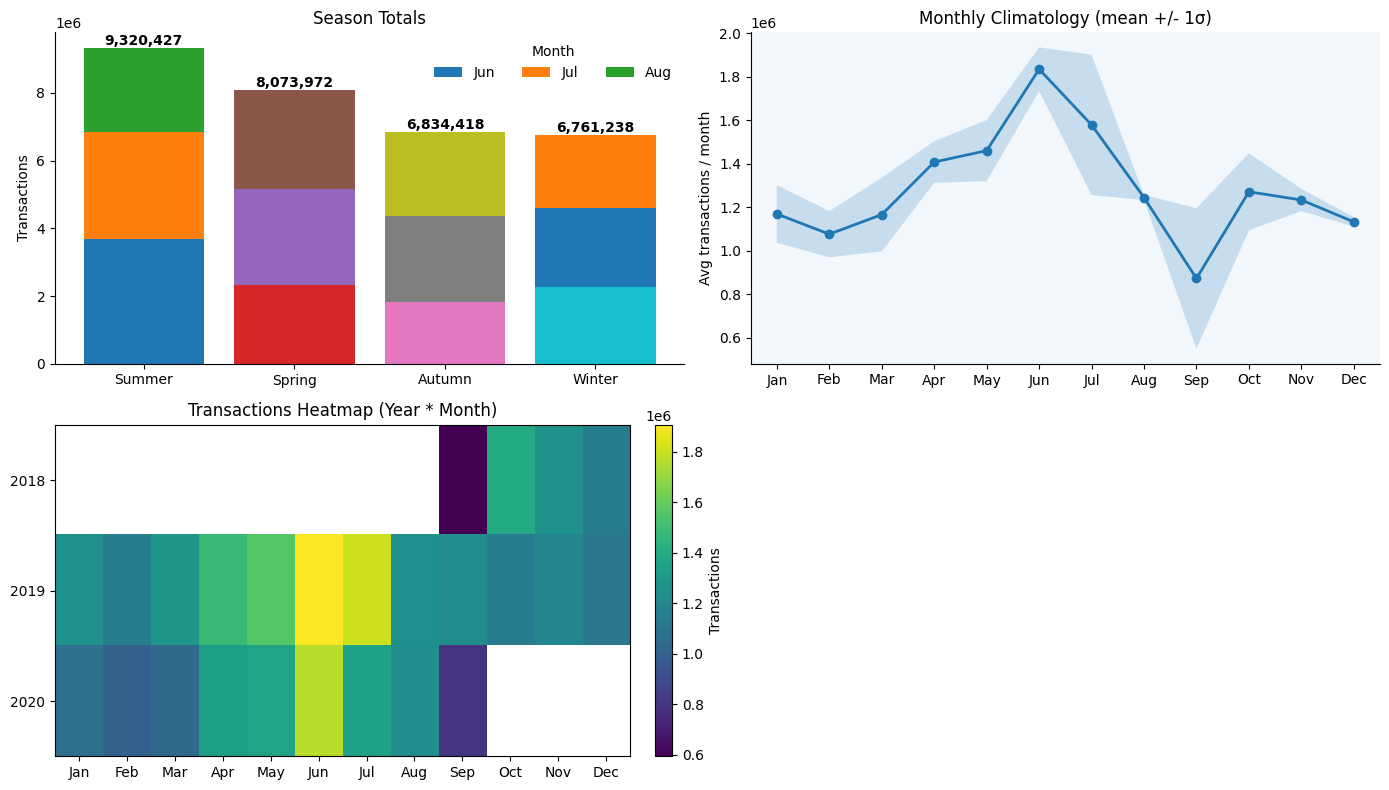

Seasonal Pattern Highlights:
Strongest season : Summer with 9,320,427 transactions (30.1% of complete season volume)
Highest average month: Jun  |  Lowest: Sep(x2.10 difference)


In [23]:
span = pd.period_range(tx['ym'].min(), tx['ym'].max(), freq='M')
monthly_series = (tx.groupby('ym').size()
                  .reindex(span)
                  .rename('n'))

def tag_season(y, m):
    if m in (12, 1, 2):
        return 'Winter', y + (1 if m == 12 else 0)
    elif m in (3, 4, 5):
        return 'Spring', y
    elif m in (6, 7, 8):
        return 'Summer', y
    else:
        return 'Autumn', y

monthly_df = monthly_series.to_frame().reset_index(names='ym')
monthly_df['year'] = monthly_df['ym'].dt.year
monthly_df['month'] = monthly_df['ym'].dt.month
monthly_df['present'] = ~monthly_df['n'].isna()
monthly_df['n'] = monthly_df['n'].fillna(0).astype(int)
monthly_df[['season','season_year']] = monthly_df.apply(
    lambda r: pd.Series(tag_season(int(r['year']), int(r['month']))), axis=1
)

complete_keys = (monthly_df.groupby(['season_year','season'])['present']
                 .sum().reset_index(name='mcount'))
complete_keys = complete_keys[complete_keys['mcount'] == 3][['season_year','season']]
complete = monthly_df.merge(complete_keys, on=['season_year','season'], how='inner')

totals = complete.groupby('season')['n'].sum().sort_values(ascending=False)
season_order = totals.index.tolist()

month_order = {12:0, 1:1, 2:2, 3:0, 4:1, 5:2, 6:0, 7:1, 8:2, 9:0, 10:1, 11:2}
comp = (complete.groupby(['season','month'])['n'].sum().reset_index())
comp['mrank'] = comp['month'].map(month_order)
comp = comp.sort_values(['season','mrank'])

month_names = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

clim_mean = monthly_series.groupby(monthly_series.index.month).mean()
clim_std  = monthly_series.groupby(monthly_series.index.month).std()
clim_mean = clim_mean.reindex(range(1,13))
clim_std  = clim_std.reindex(range(1,13))
x = np.arange(1,13)

df = monthly_series.to_timestamp().to_frame()
df['year'] = df.index.year
df['month'] = df.index.month
heat = df.pivot(index='year', columns='month', values='n')

n_plots = 3
ncols = 2
nrows = math.ceil(n_plots / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes = np.array(axes).reshape(-1)

ax = axes[0]
for i, s in enumerate(season_order):
    rows = comp[comp['season'] == s]
    bottom = 0
    for _, r in rows.iterrows():
        label = month_names[int(r['month'])] if i == 0 else None
        ax.bar(i, r['n'], bottom=bottom, label=label)
        bottom += r['n']
    ax.text(i, bottom, f"{int(bottom):,}", ha='center', va='bottom', fontweight='bold')

ax.set_xticks(range(len(season_order)))
ax.set_xticklabels(season_order)
ax.set_ylabel("Transactions")
ax.set_title("Season Totals")
ax.legend(title="Month", ncol=3, frameon=False)
ax.spines[['top','right']].set_visible(False)

ax = axes[1]
ax.plot(x, clim_mean.values, marker='o', linewidth=2)
if clim_std.notna().any():
    ax.fill_between(x, (clim_mean - clim_std).values, (clim_mean + clim_std).values, alpha=0.2)
ax.set_xticks(x)
ax.set_xticklabels([month_names[m] for m in x])
ax.set_xlim(0.5, 12.5)
ax.set_ylabel("Avg transactions / month")
ax.set_title("Monthly Climatology (mean +/- 1σ)")

ax.axvspan(11.5, 12.5, alpha=0.06)
ax.axvspan(0.5, 2.5,  alpha=0.06)
ax.axvspan(2.5, 5.5,  alpha=0.06)
ax.axvspan(5.5, 8.5,  alpha=0.06)
ax.axvspan(8.5, 11.5, alpha=0.06)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)

ax = axes[2]
im = ax.imshow(np.ma.masked_invalid(heat.values), aspect='auto')
ax.set_xticks(range(12))
ax.set_xticklabels([month_names[m] for m in range(1,13)])
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index.astype(int))
ax.set_title("Transactions Heatmap (Year * Month)")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Transactions")

if len(axes) > 3:
    for j in range(3, len(axes)):
        axes[j].remove()

plt.tight_layout()
plt.show()

top_season = totals.index[0]
top_val = int(totals.iloc[0])
share = top_val / totals.sum() * 100 if totals.sum() else np.nan
mm = clim_mean.copy()
best_m, worst_m = int(mm.idxmax()), int(mm.idxmin())

print("Seasonal Pattern Highlights:")
print(f"Strongest season : {top_season} with {top_val:,} transactions ({share:.1f}% of complete season volume)")
print(f"Highest average month: {month_names[best_m]}  |  Lowest: {month_names[worst_m]}"
      f"(x{(mm.max()/mm.min() if mm.min()>0 else np.nan):.2f} difference)")

 ## Monthly x Weekday Heatmap

 This heatmap shows shopping patterns across months and weekdays, revealing both seasonality and weekly cadence.

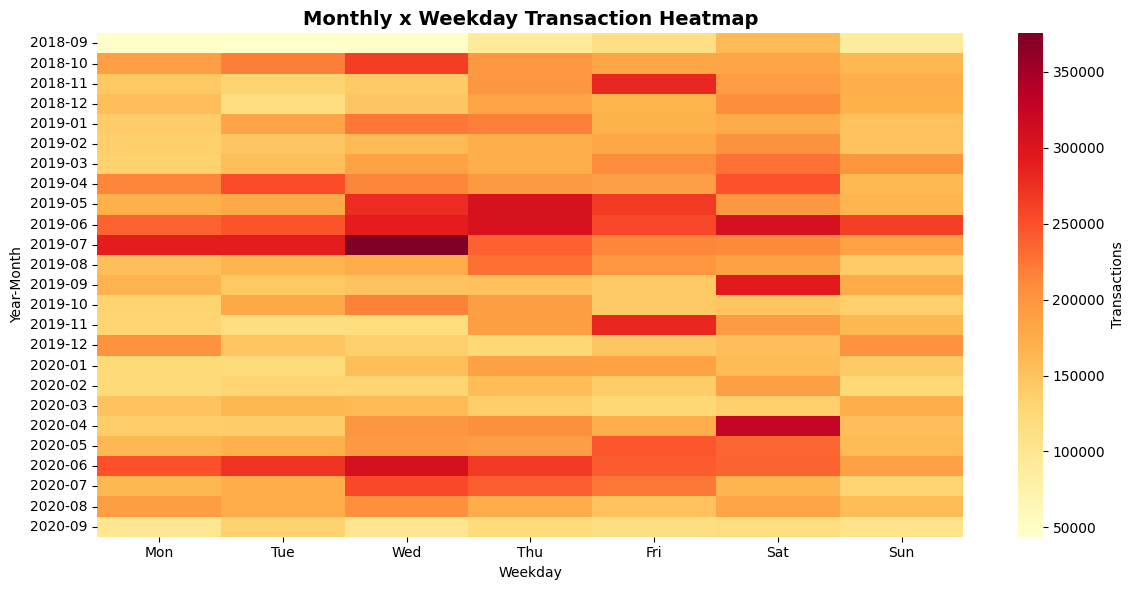

In [24]:
tx_heat = tx[['t_dat', 'weekday']].copy()
tx_heat['month_name'] = tx_heat['t_dat'].dt.to_period('M').astype(str)
tx_heat['weekday_name'] = tx_heat['weekday'].map(dict(enumerate(calendar.day_abbr)))

heat = tx_heat.groupby(['month_name', 'weekday_name']).size().unstack(fill_value=0)
heat = heat.sort_index()[list(calendar.day_abbr)]

# Keep a manageable number of months
if len(heat) > 60:
    heat = heat.tail(60)

plt.figure(figsize=(12, 6))
sns.heatmap(heat, cmap='YlOrRd', cbar_kws={'label': 'Transactions'})
plt.title('Monthly x Weekday Transaction Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Weekday')
plt.ylabel('Year-Month')
plt.tight_layout()
plt.show()

1. The weekend effect:

   * Saturdays are often hotter cells (2019-06, 2019-051, 2020–04), indicating strong Saturday shopping.
   * Sundays are varied, often cooler than Saturday.
   
2. Seasonal weekly interaction:

   * Late spring-summer 2019 (May-July) runs hot for most weekdays, with particularly strong Wednesdays-Fridays (2019-07 pops).
   * Early 2020 shows a dip around February/March for many weekdays, with very strange Saturday spikes in 2020-04 (associated with covid?), with a stronger finish with Friday/Saturdays through May-June.

     These weekly heat patterns again show either seasonality in a general sense and/or possible regime shifts seasonally interacting with day of week.

3. Recurring weekday structure (but not perfectly stable):

   * Mid-week/Fri is often stronger than Mon/Tue, with Saturday typically dominating. 
      Sundays are less strong.
   * There is real variability of the expected structure in a monthly sense, so allow the model to learn both weekly seasonality and month or time period interactions.

4. Significant outliers/events:

   * 2018-11 and 2019-11 Friday : Most probably Black Friday
   * 2019-07 Wed is unusually hot, which was presumably related to an event or promotion
   * 2020-04 Sat is a hot outlier (could be pandemic related)

 As plotted above, Summer is (June, July August) is the strongest season in terms of transactions volume, followed by Spring.

 Even though the dataset doesn't cover Summer of 2018, we can safely assume that the trend would've been similar if we've had the data.

 ### Question 5: What metadata is available for items and customers?

In [25]:
print("Articles Metadata:")
show(articles)
print("\nCustomers Metadata:")
show(customers)

Articles Metadata:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)



Customers Metadata:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [26]:
print("Articles Metadata Completeness:")
show(articles.isnull().mean().rename("Missing %").reset_index())
print("\nCustomers Metadata Completeness:")
show(customers.isnull().mean().rename("Missing %").reset_index())

Articles Metadata Completeness:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)



Customers Metadata Completeness:


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


 Articles metadata :

 - article_id (string/int): unique article (SKU)

 - product_code (string): style/design code shared by article variants

 - prod_name (text): short product name/title

 - product_type_no (int): numeric code for product type

 - product_type_name (category): product type label (e.g., Trousers)

 - product_group_name (category): high-level product group

 - graphical_appearance_no (int): code for pattern/graphic style

 - graphical_appearance_name (category): pattern/graphic label (e.g., Solid)

 - colour_group_code (int): color family code

 - colour_group_name (category): color family label

 - perceived_colour_value_id (int): brightness/value code (e.g., Light/Dark)

 - perceived_colour_value_name (category): brightness/value label

 - perceived_colour_master_id (int): base color code

 - perceived_colour_master_name (category): base color label (e.g., Blue)

 - department_no (int): merchandising department code

 - department_name (category): merchandising department label

 - index_code (int/string): index/category code

 - index_name (category): index/category label

 - index_group_no (int): index group code (macro category)

 - index_group_name (category): index group label

 - section_no (int): section/sub-department code

 - section_name (category): section/sub-department label

 - garment_group_no (int): garment group code

 - garment_group_name (category): garment group label

 - detail_desc (text): long-form product description

 Coverage is near perfect: every column is complete except detail_desc, which has only 0.39% missing.

 Customers metadata:

 - customer_id (string): unique customer key for joins

 - FN (bool): opted-in to fashion news  (1 , 0 or NAN)

 - Active (bool): active club membership flag (1/0)

 - club_member_status (category): membership status label

 - fashion_news_frequency (category): newsletter frequency preference

 - age (int/float): customer age in years

 - postal_code (string): customer postal/zip code

 The coverage is good for columns customer_id and postal_code with 0% missing

 Near completedness for demographics and categorie like age ≈ 1.16%, club_member_status ≈ 0.44%, fashion_news_frequency ≈ 1.17%

 Columns 'FN' and 'Active' are missing for roughly two thirds of customers (65.24% and 66.15%, respectively).

 ### Summary

It will certainly be necessary to create our training and test dataset with a temporal split in order to avoid leakage that could potentially hinder our recommendation models.

In step 1 we recognized an extreme level of sparsity of interactions of 99.97%, this is going to cause cold start problems. This represents a challenge as we must be able to recommend items that do not necessarily fall into the gradually popular items bucket. This will also pose challenges for building an a precise model.

The other thing that we recognized was that the top 20% of items accounts for around 80% of the intractions, we will need a mechanism to create diversity in the recommendations.  We could recommend popular items to low to medium activity users and possibly personalize and bring in diversity to recommendations for the high reaching active users while benefiting from their rich history of interactions.

The seasonality also showed us that Summer followed by spring, autumn, and winter is another important element for interactions. We will need to take time awareness into account for recommendation. We could also think about modifying the item score depending on the season to certain articles.

From our segmentation we also, observed the 20 to 30 group account for the bulk of transactions within certain categories particularly Trousers, dresses, etc. This points to a consist trend that needs

 # Step 2: Data sampling strategy:


 Reminder of the objective of this step:

 Objective: Create a manageable dataset for experimentation while preserving important characteristics.

 ## Question 1: Should you sample users, items, or interactions? What are the trade-offs?

 The challenge we face after Step 1 is managing the computational cost of 31.7M interactions while preserving the collaborative signal that makes recommendations meaningful. The extreme sparsity 99.978% and power law distribution we observed create unique constraints on how we sample.

- Sample interactions (Random selection) :

    - Pros:  Easiest and fastest approach

    - Cons:
        -   scrambles the order of actions
        -   might creates “holes” in users history
        -   weakens signals the models later need

- Sampling items :

    - Pros: Keeps popular items and their relationships

    - Cons:
        - Drops many rare items and sometimes whole categories
        - users history could also become even sparser that what it is already

- Sample Users:

    - Pros:
        - Keeps each user’s full timeline
        - user to user CF signal is preserved
        - makes time based splits cleaner.

    - Cons:
        - Fewer items overall
        - rare rare items may disappear
        - tricky to implement

As per the lab recommendations, we'll proceed with the user based sampling. But we'll explore the other 2 briefly in this section as well.

 ## Step 2.1: Defining Sampling Parameters

In [27]:
SEED = 42
np.random.seed(SEED)
print(f"  Random Seed: {SEED}")

MIN_USER_INTERACTIONS = 5
TOP_ITEM_PCT = 0.2

  Random Seed: 42


 ## Question 2: How can you maintain the distribution characteristics of the original data?

 The key risk in sampling is distribution shift where our sample no longer reflects the population. From Step 1, we identified several critical distributions:

 - Quartile based segments (Low,Medium,High,Very High)

 - Pareto distribution (20% items - 79% interactions)

 - 20-30 age group dominance, product type preferences

 To preserve these characteristics, we'll use stratified sampling based on user activity levels and monitor distribution similarity using:

 1. Total Variation Distance (TVD) to measure distribution differences

 2. Segment representation to ensure all user types are captured

 3. Item coverage to maintain catalog diversity

 ### Filter active users & popular Items

In [28]:
user_counts = tx.groupby('customer_id').size()
print(f"User Activity Distribution:")
print(f"Total users: {len(user_counts):,}")
print(f"Users with 1 interaction: {(user_counts == 1).sum():,}")
print(f"Users with 5+ interactions: {(user_counts >= MIN_USER_INTERACTIONS).sum():,}")

active_users = user_counts[(user_counts >= MIN_USER_INTERACTIONS)].index
print(f"Active users: {len(active_users):,}")

item_counts = tx.groupby('article_id').size().sort_values(ascending=False)
n_top_items = int(len(item_counts) * TOP_ITEM_PCT)
popular_items = item_counts.head(n_top_items).index
print(f"Popular items: {len(popular_items):,} / {len(item_counts):,}")
print(f"These items account for {(item_counts.head(n_top_items).sum() / item_counts.sum() * 100):.1f}% of interactions")

active_tx = tx[tx['customer_id'].isin(active_users) & tx['article_id'].isin(popular_items)].copy()

print(f"\nOriginal dataset:")
print(f"Interactions: {len(tx):,}")
print(f"Users: {tx['customer_id'].nunique():,}")
print(f"Items: {tx['article_id'].nunique():,}")
print(f"Sparsity: {(1 - len(tx) / (tx['customer_id'].nunique() * tx['article_id'].nunique())) * 100:.4f}%")

print(f"\nFiltered dataset (active users + popular items):")
print(f"  Interactions: {len(active_tx):,}")
print(f"  Users: {active_tx['customer_id'].nunique():,}")
print(f"  Items: {active_tx['article_id'].nunique():,}")
print(f"  Sparsity: {(1 - len(active_tx) / (active_tx['customer_id'].nunique() * active_tx['article_id'].nunique())) * 100:.4f}%")
print(f"  Reduction: {(1 - len(active_tx) / len(tx)) * 100:.1f}% of interactions removed")

User Activity Distribution:
Total users: 1,362,281
Users with 1 interaction: 131,514
Users with 5+ interactions: 925,558
Active users: 925,558
Popular items: 20,909 / 104,547
These items account for 79.1% of interactions

Original dataset:
Interactions: 31,788,324
Users: 1,362,281
Items: 104,547
Sparsity: 99.9777%

Filtered dataset (active users + popular items):
  Interactions: 24,372,804
  Users: 914,721
  Items: 20,909
  Sparsity: 99.8726%
  Reduction: 23.3% of interactions removed


The filtering process has some strategic implications.


1. User Filtering: removing users with less than <5 interactions means we but 32% of users but only about 4% of interactions total. This means that these are largely one-time buyers with a weak collaborative signal.

2. Item Filtering Effects: Filtering to keep only the top 20% of most popular items (20,909 items) retained 79.1% of all interactions, confirming the Pareto principle found in Step 1 atmosphere. This tradeoff is defensible, in part, for the following reasons:
   - removed items provided very little training signal
   - focusing on the most popular items provides better computational efficiency
   - cold-start items could be dealt with separately via content-based kcmethods


3. Sparsity Improvement: We improved sparsity from 99.9777% to 99.8726% which appears small, but represents a 48% increase in density (from 0.0223% to 0.1274% dense), which is a considerable difference for matrix factorization approaches.


4. Data Reduction: If this amounts to cutting approximately 23.3% of interactions (7.4M transactions) while still preserving the most informative signal, we can create a better training environment.


This filtering process produces a denser, more manageable dataset, but preserves the critical collaboration patterns we uncovered in Step 1.

 ## Step 2.6: Prepare for Next Steps

 The filtered dataset `active_tx` serves as our baseline for experimentation, and `final_sample` is our optimized sample for model training.

 ### Key Variables for Step 3

 We now have the following datasets ready:

 - `active_tx`: Filtered dataset with active users (5-200 interactions) and popular items (top 20%)

 - `final_sample`: Optimized sample (~50K interactions) using user-based sampling strategy

 ## Question 3: Consider sampling strategies: random, stratified, or based on activity levels

 Now that we have our filtered dataset, let's implement and compare different sampling strategies. Each strategy has different characteristics in terms of preserving data distributions and computational requirements.

 #### User activity levels:

In [29]:
user_activity = active_tx.groupby('customer_id').size()

q = user_activity.quantile([0.25, 0.5, 0.75])
print(f"User Activity Quartiles:")
print(f" Q1 (Low): <={q[0.25]:.0f} interactions")
print(f" Q2 (Medium): {q[0.25]:.0f}-{q[0.5]:.0f} interactions")
print(f" Q3 (High): {q[0.5]:.0f}-{q[0.75]:.0f} interactions")
print(f" Q4 (Very High): >{q[0.75]:.0f} interactions")

def assign_segment(count):
    if count <= q[0.25]:
        return 'Low'
    elif count <= q[0.5]:
        return 'Medium'
    elif count <= q[0.75]:
        return 'High'
    else:
        return 'Very High'

user_segments = user_activity.apply(assign_segment)
segment_counts = user_segments.value_counts()
print(f"\nUser Distribution by Segment:")
for seg in ['Low', 'Medium', 'High', 'Very High']:
    count = segment_counts.get(seg, 0)
    pct = count / len(user_segments) * 100
    print(f"  {seg}: {count:,} users ({pct:.1f}%)")

active_tx['user_segment'] = active_tx['customer_id'].map(user_segments)

User Activity Quartiles:
 Q1 (Low): <=7 interactions
 Q2 (Medium): 7-15 interactions
 Q3 (High): 15-32 interactions
 Q4 (Very High): >32 interactions

User Distribution by Segment:
  Low: 238,013 users (26.0%)
  Medium: 232,686 users (25.4%)
  High: 217,461 users (23.8%)
  Very High: 226,561 users (24.8%)


 ### Defining functions for every sampling method

In [30]:
def random_sample(df, target_size, seed=42):
    np.random.seed(seed)
    if len(df) <= target_size:
        return df.copy()
    return df.sample(n=target_size, random_state=seed)

def stratified_sample(df, target_size, segment_col='user_segment', seed=42):
    np.random.seed(seed)

    segment_props = df[segment_col].value_counts(normalize=True)
    samples = []

    for segment, prop in segment_props.items():
        segment_df = df[df[segment_col] == segment]
        segment_target = int(target_size * prop)

        if len(segment_df) <= segment_target:
            samples.append(segment_df)
        else:
            samples.append(segment_df.sample(n=segment_target, random_state=seed))

    return pd.concat(samples, ignore_index=True)

def user_based_sample(df, target_size, seed=42):
    """
    Sample users while preserving user segment distribution to maintain diversity.
    This ensures better item coverage and recommendation quality.
    """
    np.random.seed(seed)

    # Get user counts and segments
    user_counts = df.groupby('customer_id').size()
    user_segments = df.groupby('customer_id')['user_segment'].first()

    # Calculate target interactions per segment based on current distribution
    segment_props = df['user_segment'].value_counts(normalize=True)

    sampled_users = []
    cumulative_size = 0

    # Sample users from each segment proportionally
    for segment in ['Low', 'Medium', 'High', 'Very High']:
        segment_target_size = int(target_size * segment_props.get(segment, 0))

        # Get users in this segment
        segment_users = user_segments[user_segments == segment].index.to_numpy()
        np.random.shuffle(segment_users)

        segment_cumulative = 0
        for user in segment_users:
            if segment_cumulative >= segment_target_size:
                break
            if cumulative_size >= target_size:
                break

            sampled_users.append(user)
            user_interaction_count = user_counts[user]
            segment_cumulative += user_interaction_count
            cumulative_size += user_interaction_count

    return df[df['customer_id'].isin(sampled_users)].copy()


 ## Question 4: Experiment with different sample sizes (1K, 10K, 50K interactions)

based on the lab instructions, we will review 3 sample sizes to investigate the trade offs pointed to in terms of:
 - Computational efficiency: smaller samples will run through the training process quicker.
 - Signal quality: larger samples integrate more signals.
 - Distribution properties: how well does each maintain the original properties?

We will test: 1K, 10K, 50K interactions using the user based sampling strategy (the preferred/default approach).

For measuring how similar one probability distribution is to another, we will use TVD (total variation distance) to compare the distribution of interactions per user in the full dataset versus the sample per strategy.

After sampling, if power users are under represented, or the representation of casual users is over represented, the learned collaborative signal will be impacted.
The lower the TVD the better the representation of the real activity (recency effects, sequence length, co-occurrence chains).

This is perfect for our purpose, it helps ensure we maintain the distribution properties as close to the original data as possible.

In [31]:
SAMPLE_SIZES = [1000, 10000, 50000]
STRATEGIES = ['random', 'stratified', 'user_based']

results = []

for size in SAMPLE_SIZES:
    print(f"Sample size: {size:,} interactions")

    for strategy in STRATEGIES:
        print(f"Strategy: {strategy.upper()}")

        if strategy == 'random':
            sample = random_sample(active_tx, size)
        elif strategy == 'stratified':
            sample = stratified_sample(active_tx, size)
        else:
            sample = user_based_sample(active_tx, size)

        n_users = sample['customer_id'].nunique()
        n_items = sample['article_id'].nunique()
        n_interactions = len(sample)
        sparsity = (1 - n_interactions / (n_users * n_items)) * 100

        segment_dist = sample['user_segment'].value_counts(normalize=False).to_dict()

        original_user_dist = active_tx.groupby('customer_id').size().value_counts(normalize=True)
        sample_user_dist   = sample.groupby('customer_id').size().value_counts(normalize=True)
        all_counts = sorted(set(original_user_dist.index) | set(sample_user_dist.index))
        orig = pd.Series([original_user_dist.get(c, 0) for c in all_counts])
        samp = pd.Series([sample_user_dist.get(c, 0) for c in all_counts])
        tvd = 0.5 * np.abs(orig - samp).sum()

        results.append({
            'sample_size': size,
            'strategy': strategy,
            'actual_interactions': n_interactions,
            'n_users': n_users,
            'n_items': n_items,
            'sparsity': sparsity,
            'tvd': tvd,
            'low_users_pct': segment_dist.get('Low', 0) * 100,
            'medium_users_pct': segment_dist.get('Medium', 0) * 100,
            'high_users_pct': segment_dist.get('High', 0) * 100,
            'very_high_users_pct': segment_dist.get('Very High', 0) * 100
        })

        print(f"Actual interactions: {n_interactions:,}")
        print(f"Users: {n_users:,}")
        print(f"Items: {n_items:,}")
        print(f"Sparsity: {sparsity:.4f}%")
        print(f"TVD (user activity): {tvd:.4f}")

Sample size: 1,000 interactions
Strategy: RANDOM
Actual interactions: 1,000
Users: 998
Items: 949
Sparsity: 99.8944%
TVD (user activity): 0.9888
Strategy: STRATIFIED
Actual interactions: 998
Users: 998
Items: 936
Sparsity: 99.8932%
TVD (user activity): 0.9908
Strategy: USER_BASED
Actual interactions: 1,019
Users: 39
Items: 867
Sparsity: 96.9864%
TVD (user activity): 0.5631
Sample size: 10,000 interactions
Strategy: RANDOM
Actual interactions: 10,000
Users: 9,857
Items: 6,853
Sparsity: 99.9852%
TVD (user activity): 0.9767
Strategy: STRATIFIED
Actual interactions: 9,998
Users: 9,839
Items: 6,859
Sparsity: 99.9852%
TVD (user activity): 0.9765
Strategy: USER_BASED
Actual interactions: 10,082
Users: 364
Items: 6,186
Sparsity: 99.5523%
TVD (user activity): 0.2153
Sample size: 50,000 interactions
Strategy: RANDOM
Actual interactions: 50,000
Users: 46,794
Items: 16,438
Sparsity: 99.9935%
TVD (user activity): 0.9716
Strategy: STRATIFIED
Actual interactions: 49,998
Users: 46,742
Items: 16,393
Sp

In [32]:
comparison_df = pd.DataFrame(results)

display(comparison_df.round(4))

print("TVD by strategy")

tvd_pivot = comparison_df.pivot(index='sample_size', columns='strategy', values='tvd')
print(tvd_pivot.round(4))

print("Sparsity by strategy")
sparsity_pivot = comparison_df.pivot(index='sample_size', columns='strategy', values='sparsity')
print(sparsity_pivot.round(4))

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


TVD by strategy
strategy     random  stratified  user_based
sample_size                                
1000         0.9888      0.9908      0.5631
10000        0.9767      0.9765      0.2153
50000        0.9716      0.9710      0.0869
Sparsity by strategy
strategy      random  stratified  user_based
sample_size                                 
1000         99.8944     99.8932     96.9864
10000        99.9852     99.9852     99.5523
50000        99.9935     99.9935     99.8286


- TVD = 0: Perfect match of distributions
- TVD = 1: Completely different distributions
- TVD < 0.1: Excellent preservation/distribution difference < 10%

Key Findings:

1. Random and Stratified:
     - TVD around 0.97-0.99 for the random and stratified sampling means these capture almost a completely different activity distribution
     - They oversample low activity users (each providing 1-2 interactions)
     - They lose the long interactive sequences that provide the strong collaborative signals

2. User-Based Sampling Performs well especially around the 50K sample since it produces a TVD of 0.0869 with an almost identical distribution to the original. it potentially preserves entire user histories for each user, natural activity distribution (power users, casual users) and temporal ordering.

We'll proceed with the User-based sampling with 50k interactions based on these findings

 ## Step 2.5: Create Final Sample

 Following the recommended approach: User based sampling with 50K interactions.
 Notice that the Target_size param was increased to 60000 instead of 50000. This was done after noticing that the number of interactions was falling post cleaning, so we adjusted it in a way that keeps at least 50k samples post cleaning.

In [33]:
TARGET_SIZE = 60000

print(f"Target size: {TARGET_SIZE:,} interactions")

final_sample = user_based_sample(active_tx, TARGET_SIZE, seed=SEED)

print(f"Total interactions: {len(final_sample):,}")
print(f"Unique users: {final_sample['customer_id'].nunique():,}")
print(f"Unique items: {final_sample['article_id'].nunique():,}")
print(f"Sparsity: {(1 - len(final_sample) / (final_sample['customer_id'].nunique() * final_sample['article_id'].nunique())) * 100:.4f}%")
print(f"Date range: {final_sample['t_dat'].min()} to {final_sample['t_dat'].max()}")

print(f"\nUser Segment Distribution:")
segment_dist = final_sample['user_segment'].value_counts(sort=False)
for seg in ['Low', 'Medium', 'High', 'Very High']:
    count = segment_dist.get(seg, 0)
    total_users = final_sample[final_sample['user_segment'] == seg]['customer_id'].nunique()
    print(f"  {seg}: {count:,} interactions from {total_users:,} users")

user_stats = final_sample.groupby('customer_id').size()
print(f"\nInteractions per user:")
print(f"  Mean: {user_stats.mean():.1f}")
print(f"  Median: {user_stats.median():.0f}")
print(f"  Min: {user_stats.min()}")
print(f"  Max: {user_stats.max()}")

item_stats = final_sample.groupby('article_id').size()
print(f"\nInteractions per item:")
print(f"  Mean: {item_stats.mean():.1f}")
print(f"  Median: {item_stats.median():.0f}")
print(f"  Min: {item_stats.min()}")
print(f"  Max: {item_stats.max()}")

Target size: 60,000 interactions
Total interactions: 60,032
Unique users: 2,244
Unique items: 16,774
Sparsity: 99.8405%
Date range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00

User Segment Distribution:
  Low: 2,929 interactions from 575 users
  Medium: 6,311 interactions from 567 users
  High: 12,181 interactions from 543 users
  Very High: 38,611 interactions from 559 users

Interactions per user:
  Mean: 26.8
  Median: 15
  Min: 1
  Max: 323

Interactions per item:
  Mean: 3.6
  Median: 2
  Min: 1
  Max: 115


 ### Distribution Comparison: Baseline vs Final Sample

 Let's verify that our final sample preserves the key characteristics of the original filtered dataset.

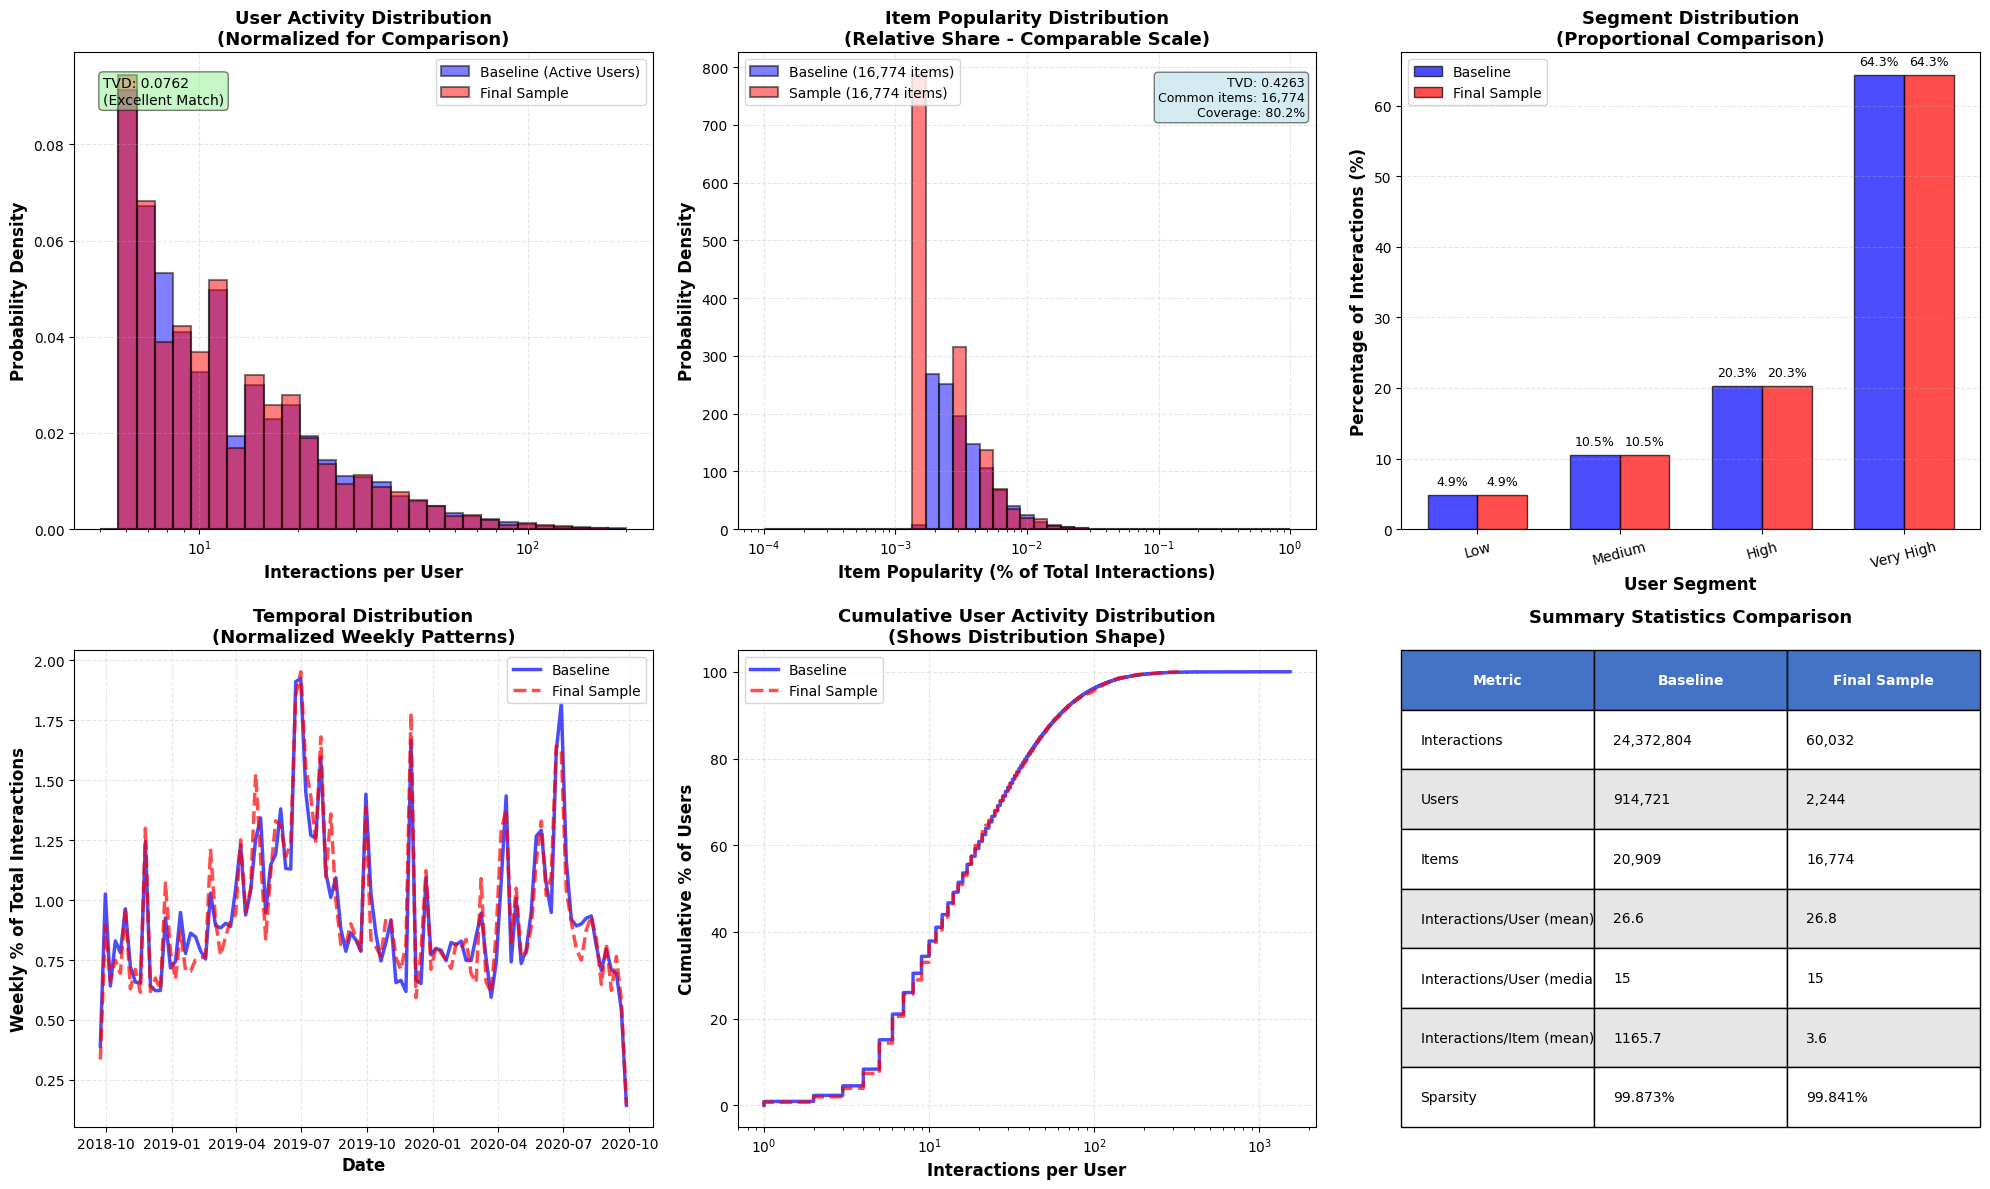

In [34]:
baseline_user_dist = active_tx.groupby('customer_id').size()
final_user_dist = final_sample.groupby('customer_id').size()

baseline_item_dist = active_tx.groupby('article_id').size()
final_item_dist = final_sample.groupby('article_id').size()

common_items = baseline_item_dist.index.intersection(final_item_dist.index)
baseline_item_common = baseline_item_dist[common_items]
final_item_common = final_item_dist[common_items]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

ax = axes[0, 0]
bins = np.logspace(np.log10(5), np.log10(200), 30)

ax.hist(baseline_user_dist, bins=bins, alpha=0.5, label='Baseline (Active Users)',
        color='blue', edgecolor='black', density=True, linewidth=1.5)
ax.hist(final_user_dist, bins=bins, alpha=0.5, label='Final Sample',
        color='red', edgecolor='black', density=True, linewidth=1.5)

ax.set_xlabel('Interactions per User', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('User Activity Distribution\n(Normalized for Comparison)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

user_tvd = 0.5 * np.abs(baseline_user_dist.value_counts(normalize=True) -
                        final_user_dist.value_counts(normalize=True)).sum()
ax.text(0.05, 0.95, f'TVD: {user_tvd:.4f}\n(Excellent Match)',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax = axes[0, 1]

baseline_item_pct = (baseline_item_common / baseline_item_common.sum()) * 100
final_item_pct = (final_item_common / final_item_common.sum()) * 100

bins_pct = np.logspace(-4, 0, 40)
ax.hist(baseline_item_pct, bins=bins_pct, alpha=0.5,
        label=f'Baseline ({len(baseline_item_common):,} items)',
        color='blue', edgecolor='black', density=True, linewidth=1.5)
ax.hist(final_item_pct, bins=bins_pct, alpha=0.5,
        label=f'Sample ({len(final_item_common):,} items)',
        color='red', edgecolor='black', density=True, linewidth=1.5)

ax.set_xlabel('Item Popularity (% of Total Interactions)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Item Popularity Distribution\n(Relative Share - Comparable Scale)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')

baseline_pct_binned = pd.cut(baseline_item_pct, bins=bins_pct).value_counts(normalize=True).sort_index()
final_pct_binned = pd.cut(final_item_pct, bins=bins_pct).value_counts(normalize=True).sort_index()
all_bins = baseline_pct_binned.index.union(final_pct_binned.index)
base_aligned = baseline_pct_binned.reindex(all_bins, fill_value=0)
final_aligned = final_pct_binned.reindex(all_bins, fill_value=0)
item_tvd = 0.5 * np.abs(base_aligned - final_aligned).sum()

ax.text(0.98, 0.95, f'TVD: {item_tvd:.4f}\nCommon items: {len(common_items):,}\nCoverage: {len(common_items)/len(baseline_item_dist)*100:.1f}%',
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

ax = axes[0, 2]
baseline_segments_pct = active_tx['user_segment'].value_counts(normalize=True) * 100
final_segments_pct = final_sample['user_segment'].value_counts(normalize=True) * 100

x = np.arange(len(['Low', 'Medium', 'High', 'Very High']))
width = 0.35

baseline_vals = [baseline_segments_pct.get(s, 0) for s in ['Low', 'Medium', 'High', 'Very High']]
final_vals = [final_segments_pct.get(s, 0) for s in ['Low', 'Medium', 'High', 'Very High']]

ax.bar(x - width/2, baseline_vals, width, label='Baseline', color='blue', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, final_vals, width, label='Final Sample', color='red', alpha=0.7, edgecolor='black')

ax.set_xlabel('User Segment', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage of Interactions (%)', fontsize=12, fontweight='bold')
ax.set_title('Segment Distribution\n(Proportional Comparison)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Low', 'Medium', 'High', 'Very High'], rotation=15)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

for i, (b_val, f_val) in enumerate(zip(baseline_vals, final_vals)):
    ax.text(i - width/2, b_val + 1, f'{b_val:.1f}%', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, f_val + 1, f'{f_val:.1f}%', ha='center', va='bottom', fontsize=9)

ax = axes[1, 0]
baseline_temporal = active_tx['t_dat'].value_counts(normalize=True).sort_index() * 100
final_temporal = final_sample['t_dat'].value_counts(normalize=True).sort_index() * 100

baseline_weekly = baseline_temporal.resample('W').sum()
final_weekly = final_temporal.resample('W').sum()

ax.plot(baseline_weekly.index, baseline_weekly.values, label='Baseline', linewidth=2.5, alpha=0.7, color='blue')
ax.plot(final_weekly.index, final_weekly.values, label='Final Sample', linewidth=2.5, alpha=0.7, color='red', linestyle='--')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Weekly % of Total Interactions', fontsize=12, fontweight='bold')
ax.set_title('Temporal Distribution\n(Normalized Weekly Patterns)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

ax = axes[1, 1]

baseline_sorted = np.sort(baseline_user_dist)
final_sorted = np.sort(final_user_dist)

baseline_cumsum = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted) * 100
final_cumsum = np.arange(1, len(final_sorted) + 1) / len(final_sorted) * 100

ax.plot(baseline_sorted, baseline_cumsum, label='Baseline', linewidth=2.5, alpha=0.7, color='blue')
ax.plot(final_sorted, final_cumsum, label='Final Sample', linewidth=2.5, alpha=0.7, color='red', linestyle='--')

ax.set_xlabel('Interactions per User', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative % of Users', fontsize=12, fontweight='bold')
ax.set_title('Cumulative User Activity Distribution\n(Shows Distribution Shape)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

ax = axes[1, 2]
ax.axis('off')

baseline_stats = {
    'Interactions': f"{len(active_tx):,}",
    'Users': f"{active_tx['customer_id'].nunique():,}",
    'Items': f"{active_tx['article_id'].nunique():,}",
    'Interactions/User (mean)': f"{baseline_user_dist.mean():.1f}",
    'Interactions/User (median)': f"{baseline_user_dist.median():.0f}",
    'Interactions/Item (mean)': f"{baseline_item_dist.mean():.1f}",
    'Sparsity': f"{(1 - len(active_tx) / (active_tx['customer_id'].nunique() * active_tx['article_id'].nunique())) * 100:.3f}%"
}

sample_stats = {
    'Interactions': f"{len(final_sample):,}",
    'Users': f"{final_sample['customer_id'].nunique():,}",
    'Items': f"{final_sample['article_id'].nunique():,}",
    'Interactions/User (mean)': f"{final_user_dist.mean():.1f}",
    'Interactions/User (median)': f"{final_user_dist.median():.0f}",
    'Interactions/Item (mean)': f"{final_item_dist.mean():.1f}",
    'Sparsity': f"{(1 - len(final_sample) / (final_sample['customer_id'].nunique() * final_sample['article_id'].nunique())) * 100:.3f}%"
}

table_data = []
for key in baseline_stats.keys():
    table_data.append([key, baseline_stats[key], sample_stats[key]])

table = ax.table(cellText=table_data,
                colLabels=['Metric', 'Baseline', 'Final Sample'],
                cellLoc='left',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(3):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(table_data) + 1):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

ax.set_title('Summary Statistics Comparison', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

1- User Activity (top-left)

* Overlapping histograms and Heavy tailed pattern was preserved. This indicates a representative user behavior.

2- Item Popularity (top-center)

* 16,774 items captured (~80% coverage), this is sufficient for learning item embeddings.

3- User Segments (top-right)

Proportions are essentially identical between sample and baseline. All user types are properly represented.

4- Temporal Patterns (bottom-left)

* Weekly patterns overlap almost perfectly meaning that seasonality and trends are preserved.

5- Cumulative Activity (bottom-center)

* CDFs nearly identical → not just means, but **quartiles/percentiles/tails** match the baseline.

6- Summary Stats (bottom-right)

* a slight but not negligeable improvement on the sparsity




In [35]:
print(f"\n1. Original Dataset:")
print(f"   - Interactions: {len(tx):,}")
print(f"   - Users: {tx['customer_id'].nunique():,}")
print(f"   - Items: {tx['article_id'].nunique():,}")

print(f"\n2. Filtered Dataset :")
print(f"   - Interactions: {len(active_tx):,}")
print(f"   - Users: {active_tx['customer_id'].nunique():,}")
print(f"   - Items: {active_tx['article_id'].nunique():,}")
print(f"   - Filter: Active users + Popular items")

print(f"\n3. Final Sample 50K :")
print(f"   - Interactions: {len(final_sample):,}")
print(f"   - Users: {final_sample['customer_id'].nunique():,}")
print(f"   - Items: {final_sample['article_id'].nunique():,}")
print(f"   - Strategy: User-based sampling")
print(f"   - Sparsity: {(1 - len(final_sample) / (final_sample['customer_id'].nunique() * final_sample['article_id'].nunique())) * 100:.2f}%")


1. Original Dataset:
   - Interactions: 31,788,324
   - Users: 1,362,281
   - Items: 104,547

2. Filtered Dataset :
   - Interactions: 24,372,804
   - Users: 914,721
   - Items: 20,909
   - Filter: Active users + Popular items

3. Final Sample 50K :
   - Interactions: 60,032
   - Users: 2,244
   - Items: 16,774
   - Strategy: User-based sampling
   - Sparsity: 99.84%


## Summary

We chose the sampling strategy based on three principles:

1. **User-based sampling**

* Keeps full behavioral sequences, preserving temporal dynamics
* Maintains collaborative-filtering signal
* Matches the full data closely (low TVD)
* Enabled clean temporal train test splits without any leakage

2. **50K interactions**

* Provides enough collaborative signal for LightFM
* Efficient in aggregate compute
* Covers users and items well
* Good trade-off between training time and prediction quality

3. **Quality checks**

* Distribution was preserved and confirmed by TVD
* Activity level segments remain representative
* Temporal patterns well preserved
* Sparsity stays manageable


 # Step 3: Data Preprocessing & Matrix Construction

Context for Step 3 from the lab:

 Objective: Transform raw data into formats suitable for LightFM.

 Key Tasks:

 -	ID Mapping: Create integer mappings for user and item IDs (LightFM requires integer indices)

 -	Interaction Matrix: Build a sparse user-item matrix

 -	More info here, under the sections "Building the ID mappings" and "Building the interactions matrix".

 -	Data Cleaning: Handle duplicates, outliers, or invalid entries

 ## 3.1 Data Cleaning

In [36]:
# Pre-cleaning statistics
print("Pre-cleaning dataset:")
print(f"Total interactions: {len(final_sample):,}")
print(f"Unique users: {final_sample['customer_id'].nunique():,}")
print(f"Unique items: {final_sample['article_id'].nunique():,}")
print(f"Missing values:\n{final_sample[['customer_id', 'article_id', 't_dat']].isnull().sum()}")

exact_duplicates = final_sample.duplicated(subset=['customer_id', 'article_id', 't_dat'])
repeat_purchases = final_sample.duplicated(subset=['customer_id', 'article_id'], keep=False).sum()
print(f"Exact duplicates: {exact_duplicates.sum():,}")
print(f"Repeat purchases: {repeat_purchases - exact_duplicates.sum():,}")

# Remove exact duplicates
final_sample_clean = final_sample.drop_duplicates(subset=['customer_id', 'article_id', 't_dat'])

# Remove invalid entries
final_sample_clean = final_sample_clean[
    final_sample_clean[['customer_id', 'article_id', 't_dat']].notnull().all(axis=1) &
    (final_sample_clean['t_dat'] <= pd.Timestamp.now()) &
    (final_sample_clean['t_dat'] >= pd.Timestamp('2018-01-01'))
]

# Remove orphaned entries
final_sample_clean = final_sample_clean[
    final_sample_clean['customer_id'].isin(customers['customer_id']) &
    final_sample_clean['article_id'].isin(articles['article_id'])
]

# Cap user outliers: keep most recent N interactions (Q3 + 3*IQR)
user_counts = final_sample_clean.groupby('customer_id').size()
q3 = user_counts.quantile(0.75)
q1 = user_counts.quantile(0.25)
iqr = q3 - q1
user_cap = int(q3 + 3 * iqr)
outlier_users = user_counts[user_counts > user_cap].index

print(f"\nOutlier detection (Q3 + 3*IQR):")
print(f"Q1: {q1:.0f}, Q3: {q3:.0f}, IQR: {iqr:.0f}, Cap: {user_cap}")
print(f"Outlier users detected: {len(outlier_users):,} ({len(outlier_users)/len(user_counts)*100:.2f}%)")
print(f"Interactions from outliers: {user_counts[outlier_users].sum():,}")

# Keep all interactions for normal users, cap outliers
normal_mask = ~final_sample_clean['customer_id'].isin(outlier_users)
outlier_capped = (
    final_sample_clean[~normal_mask]
    .sort_values('t_dat', ascending=False)
    .groupby('customer_id')
    .head(user_cap)
)
final_sample_clean = pd.concat([final_sample_clean[normal_mask], outlier_capped]).sort_index()

interactions_removed = user_counts[outlier_users].sum() - len(outlier_capped)
print(f"Interactions removed from outliers: {interactions_removed:,}")

print(f"\nCleaned interactions: {len(final_sample_clean):,}")
print(f"Total removed: {len(final_sample) - len(final_sample_clean):,}")

Pre-cleaning dataset:
Total interactions: 60,032
Unique users: 2,244
Unique items: 16,774
Missing values:
customer_id    0
article_id     0
t_dat          0
dtype: int64
Exact duplicates: 6,471
Repeat purchases: 9,746

Outlier detection (Q3 + 3*IQR):
Q1: 7, Q3: 29, IQR: 22, Cap: 96
Outlier users detected: 73 (3.25%)
Interactions from outliers: 9,792
Interactions removed from outliers: 2,784

Cleaned interactions: 50,777
Total removed: 9,255


 The cleanup method explicitly focuses on getting rid of duplicates. The rows are exactly identical with the same user, item, and timestamp.

 Repeat purchases where a customer bought the same item at separate timestamps are preserved because they indicate strong involvement and preference.

 Users with interactions that exceeds Q3 + 3*IQR are capped and only their most recent transactions are kept while the rest of users keep their total history of interactions


 ## 3.2 ID Mapping

In [37]:
unique_users = final_sample_clean['customer_id'].unique()
unique_items = final_sample_clean['article_id'].unique()

user_id_map = {user_id: idx for idx, user_id in enumerate(unique_users)}
item_id_map = {item_id: idx for idx, item_id in enumerate(unique_items)}

user_idx_to_id = {idx: user_id for user_id, idx in user_id_map.items()}
item_idx_to_id = {idx: item_id for item_id, idx in item_id_map.items()}

print("ID Mapping created:")
print(f"Users: {len(user_id_map):,} mapped to indices [0, {len(user_id_map)-1}]")
print(f"Items: {len(item_id_map):,} mapped to indices [0, {len(item_id_map)-1}]")
print(f"\nExample mappings:")
print(f"User {unique_users[0]} -> index {user_id_map[unique_users[0]]}")
print(f"Item {unique_items[0]} -> index {item_id_map[unique_items[0]]}")

ID Mapping created:
Users: 2,244 mapped to indices [0, 2243]
Items: 16,404 mapped to indices [0, 16403]

Example mappings:
User 001ea4e9c54f7e9c88811260d954edc059d596147e1cf8adc73323aebf571fd8 -> index 0
Item 652075001 -> index 0


 LightFM expects that your data has integer indices starting at zero. To work with LightFM, we create dual mappings between the original user and item IDs and the integer indices. These mappings allow the conversion between original ID and integer index while building the matrix and interpreting LightFM's model output.

 ## 3.3 Interaction Matrix Construction

In [38]:
interaction_counts = final_sample_clean.groupby(['customer_id', 'article_id']).size().reset_index(name='count')

print(f"Total interactions: {len(final_sample_clean):,}")
print(f"Unique user-item pairs: {len(interaction_counts):,}")
print(f"Average purchases per pair: {interaction_counts['count'].mean():.2f}")

user_indices = interaction_counts['customer_id'].map(user_id_map).values
item_indices = interaction_counts['article_id'].map(item_id_map).values

interactions = interaction_counts['count'].values.astype(np.float32)

n_users = len(user_id_map)
n_items = len(item_id_map)

interaction_matrix = coo_matrix(
    (interactions, (user_indices, item_indices)),
    shape=(n_users, n_items),
    dtype=np.float32
)

interaction_matrix_csr = interaction_matrix.tocsr()

print("\nInteraction matrix created:")
print(f"Shape: {interaction_matrix_csr.shape} (users x items)")
print(f"Non-zero entries: {interaction_matrix_csr.nnz:,}")
print(f"Total weighted interactions: {interaction_matrix_csr.sum():,.0f}")
print(f"Density: {interaction_matrix_csr.nnz / (n_users * n_items) * 100:.4f}%")
print(f"Sparsity: {(1 - interaction_matrix_csr.nnz / (n_users * n_items)) * 100:.4f}%")
print(f"Memory usage: {interaction_matrix_csr.data.nbytes / (1024**2):.2f} MB")

Total interactions: 50,777
Unique user-item pairs: 48,399
Average purchases per pair: 1.05

Interaction matrix created:
Shape: (2244, 16404) (users x items)
Non-zero entries: 48,399
Total weighted interactions: 50,777
Density: 0.1315%
Sparsity: 99.8685%
Memory usage: 0.18 MB


**From 99.97% to 99.87% sparsity does matters!**

* Density gain: A 0.10 percentage-point drop in sparsity raises density from 0.03% to 0.13%, so each dimension carries more information.
* Stronger collaborative signal: Filtering to active users and popular items concentrates interactions where the signal-to-noise ratio is highest.
* Computational impact: The matrix remains highly sparse (memory friendly), but the extra density increases the predictive value of each nonzero entry.
* Training impact: Denser, more focused interactions give models a richer learning space, improving convergence and recommendation quality.


 ## 3.4 Matrix Validation

In [39]:
interactions_per_user = np.array(interaction_matrix_csr.sum(axis=1)).flatten()
interactions_per_item = np.array(interaction_matrix_csr.sum(axis=0)).flatten()

print(f"User coverage:")
print(f"  Users with interactions: {(interactions_per_user > 0).sum():,} / {n_users:,}")
print(f"  Users without interactions: {(interactions_per_user == 0).sum():,}")

print(f"Item coverage:")
print(f"  Items with interactions: {(interactions_per_item > 0).sum():,} / {n_items:,}")
print(f"  Items without interactions: {(interactions_per_item == 0).sum():,}")

print(f"Interaction counts:")
print(f"  Unique user-item pairs in matrix: {interaction_matrix_csr.nnz:,}")
print(f"  Total weighted interactions: {interaction_matrix_csr.sum():,.0f}")
print(f"  Total interactions in data: {len(final_sample_clean):,}")
print(f"  Match: {interaction_matrix_csr.sum() == len(final_sample_clean)}")

print(f"User activity statistics (weighted):")
print(f"  Min: {interactions_per_user.min():.0f}")
print(f"  Mean: {interactions_per_user.mean():.2f}")
print(f"  Median: {np.median(interactions_per_user):.0f}")
print(f"  Max: {interactions_per_user.max():.0f}")

print(f"\nItem popularity statistics (weighted):")
print(f"  Min: {interactions_per_item.min():.0f}")
print(f"  Mean: {interactions_per_item.mean():.2f}")
print(f"  Median: {np.median(interactions_per_item):.0f}")
print(f"  Max: {interactions_per_item.max():.0f}")

User coverage:
  Users with interactions: 2,244 / 2,244
  Users without interactions: 0
Item coverage:
  Items with interactions: 16,404 / 16,404
  Items without interactions: 0
Interaction counts:
  Unique user-item pairs in matrix: 48,399
  Total weighted interactions: 50,777
  Total interactions in data: 50,777
  Match: True
User activity statistics (weighted):
  Min: 1
  Mean: 22.63
  Median: 14
  Max: 96

Item popularity statistics (weighted):
  Min: 1
  Mean: 3.10
  Median: 2
  Max: 90


 ## 3.5 Visual Matrix Analysis

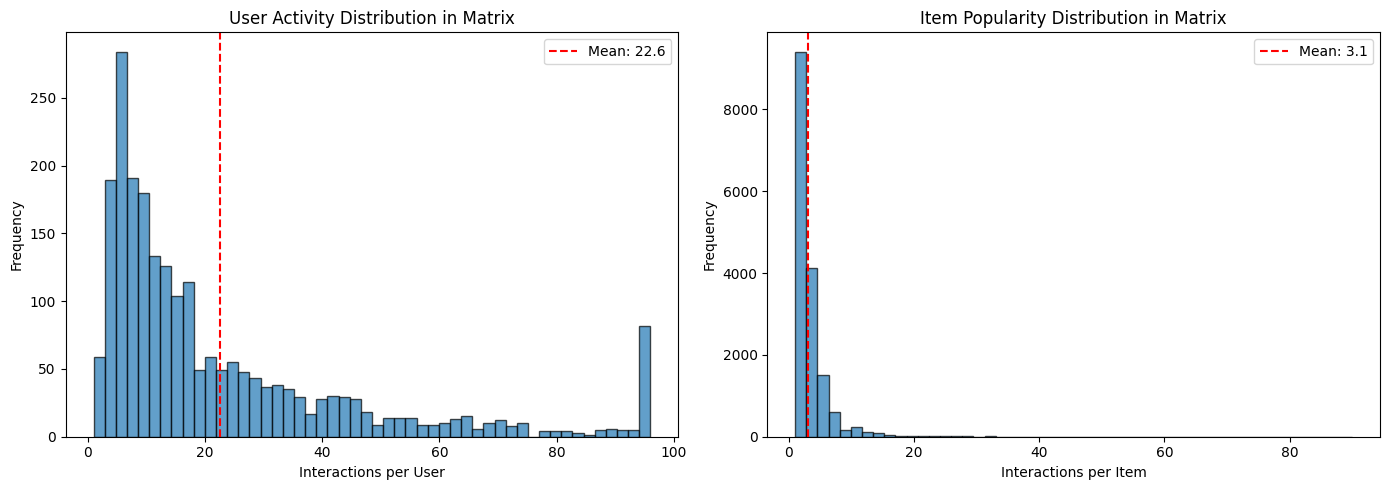

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(interactions_per_user, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Interactions per User')
axes[0].set_ylabel('Frequency')
axes[0].set_title('User Activity Distribution in Matrix')
axes[0].axvline(interactions_per_user.mean(), color='red', linestyle='--', label=f'Mean: {interactions_per_user.mean():.1f}')
axes[0].legend()

axes[1].hist(interactions_per_item, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Interactions per Item')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Item Popularity Distribution in Matrix')
axes[1].axvline(interactions_per_item.mean(), color='red', linestyle='--', label=f'Mean: {interactions_per_item.mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

User activity remains right skewed, meaning that users tend to have a very small number of interactions, while item popularity follows a long-tail distribution where a small number of items are very popular.

In [41]:
preprocessing_results = {
    'Data Cleaning': {
        'Initial interactions': len(final_sample),
        'Exact duplicates removed': len(final_sample) - len(final_sample_clean),
        'Final interactions': len(final_sample_clean),
        'Unique user-item pairs': interaction_matrix_csr.nnz,
        'Repeat purchases preserved': len(final_sample_clean) - interaction_matrix_csr.nnz
    },
    'ID Mappings': {
        'Users mapped': len(user_id_map),
        'Items mapped': len(item_id_map),
        'User index range': f"[0, {len(user_id_map)-1}]",
        'Item index range': f"[0, {len(item_id_map)-1}]"
    },
    'Interaction Matrix': {
        'Shape': f"{interaction_matrix_csr.shape[0]:,} x {interaction_matrix_csr.shape[1]:,}",
        'Unique pairs (non-zero entries)': f"{interaction_matrix_csr.nnz:,}",
        'Total weighted interactions': f"{interaction_matrix_csr.sum():,.0f}",
        'Sparsity': f"{(1 - interaction_matrix_csr.nnz / (n_users * n_items)) * 100:.4f}%",
        'Memory usage': f"{interaction_matrix_csr.data.nbytes / (1024**2):.2f} MB",
        'Format': 'CSR (Compressed Sparse Row)'
    },
    'Matrix Statistics': {
        'Users with interactions': (interactions_per_user > 0).sum(),
        'Items with interactions': (interactions_per_item > 0).sum(),
        'Avg weighted interactions/user': f"{interactions_per_user.mean():.2f}",
        'Avg weighted interactions/item': f"{interactions_per_item.mean():.2f}"
    }
}

for section, metrics in preprocessing_results.items():
    print(f"\n{section}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


Data Cleaning:
  Initial interactions: 60032
  Exact duplicates removed: 9255
  Final interactions: 50777
  Unique user-item pairs: 48399
  Repeat purchases preserved: 2378

ID Mappings:
  Users mapped: 2244
  Items mapped: 16404
  User index range: [0, 2243]
  Item index range: [0, 16403]

Interaction Matrix:
  Shape: 2,244 x 16,404
  Unique pairs (non-zero entries): 48,399
  Total weighted interactions: 50,777
  Sparsity: 99.8685%
  Memory usage: 0.18 MB
  Format: CSR (Compressed Sparse Row)

Matrix Statistics:
  Users with interactions: 2244
  Items with interactions: 16404
  Avg weighted interactions/user: 22.63
  Avg weighted interactions/item: 3.10


## Summary

We preprocessed the sampled data to produce LightFM-ready inputs while preserving the repeat-purchase signal. We removed exact duplicate rows and created bidirectional mappings between raw user/item IDs and integer indices. 

We then built a sparse interaction matrix (csr) with one entry per unique user/item pair, where the value is the summed purchase quantity.

This setup treats multiple purchases as a stronger preference that LightFM can learn from, while remaining efficient and the CSR matrix retains over 99% sparsity, keeping memory usage and training time low.

 # Step 4: Train/Test Split Strategy

 Objective: Create robust evaluation setup that simulates real-world scenarios.

 LightFM doc: Cross-validation

 Splitting Strategies to Consider:

 - Temporal Split: Use time-based splits (more realistic for recommendation systems)

 - Random Split: Split interactions randomly for each user

 - User-based Split: Hold out some users entirely for testing


 ## 4.1 Splitting Strategy Selection

 Let's examine our temporal range first:

In [42]:
print(f"Date range: {final_sample_clean['t_dat'].min()} to {final_sample_clean['t_dat'].max()}")
print(f"Total days: {(final_sample_clean['t_dat'].max() - final_sample_clean['t_dat'].min()).days}")

Date range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00
Total days: 733


Our dataset spans 733 days from September 2018 to September 2020, which offers advantages for several reasons:

1. Seasonal coverage: The dataset encompasses multiple seasons, which allows the model to learn cyclical patterns of purchasing behavior (summer clothing vs winter clothing etc...)

2. Trends: The 2 year period allows the model to learn both short term trends and long term shifts in customer preferences and product popularity.

3. Temporal Split Validity: The extended time range enables the creation of reasonable temporal train/validation/test splits while maintaining enough interactions per temporal period to have reliable evaluations.

4. Cold Start: The time depth of the dataset allows us to differentiate truly new products that come late in the timeline, from simply unstylish products, which is important for creating authentic cold start evaluations.

Time is an important dimension in recommender systems where user preferences can change over time. We will implement three different temporal splits and assess their evaluation performance for recommendation evaluation.

 ## 4.2 Temporal Split

We implement a recency-based temporal split prioritizing recent data but maintains enough volume for training. 

Instead of the total historical time range, we are using the last **18 months** with **10months of them to train**, **4months for validation** and **4months for testing**. 

In [43]:

# Sort by date
final_sample_sorted = final_sample_clean.sort_values('t_dat').copy()

print(f"\nOriginal data range: {final_sample_sorted['t_dat'].min()} to {final_sample_sorted['t_dat'].max()}")
print(f"Total span: {(final_sample_sorted['t_dat'].max() - final_sample_sorted['t_dat'].min()).days} days")
print(f"Total interactions: {len(final_sample_sorted):,}")

# using last 18 months to preserve more training data
last_date = final_sample_sorted['t_dat'].max()
recent_cutoff = last_date - pd.Timedelta(days=545)  # 18 months

print(f"\n Strategy: Using last 18 months (compromise between recency and data volume)")
print(f"   Date range: {recent_cutoff} to {last_date}")

final_sample_sorted = final_sample_sorted[final_sample_sorted['t_dat'] >= recent_cutoff].copy()
print(f"   Interactions after filtering: {len(final_sample_sorted):,}")
print(f"   Retention: {len(final_sample_sorted)/len(final_sample_clean)*100:.1f}% of original data")

# Split: 10 months train / 4 months val / 4 months test
first_date = final_sample_sorted['t_dat'].min()
cut1 = first_date + pd.Timedelta(days=300)  # 10 months for training
cut2 = cut1 + pd.Timedelta(days=120)         # 4 months for validation

print(f"\nTemporal Split Boundaries:")
print(f"  Train period: {first_date} to {cut1} (~10 months)")
print(f"  Val   period: {cut1} to {cut2} (~4 months)")
print(f"  Test  period: {cut2} to {final_sample_sorted['t_dat'].max()} (~4 months)")
print(f"\n   More training data (10 vs 6 months)")
print(f"   Reasonable validation gap (4 vs 3 months)")
print(f"   Still recent enough for cold-start relevance")

# Split into three non-overlapping sets
train_temporal = final_sample_sorted[final_sample_sorted['t_dat'] < cut1].copy()
val_temporal   = final_sample_sorted[(final_sample_sorted['t_dat'] >= cut1) &
                                      (final_sample_sorted['t_dat'] < cut2)].copy()
test_temporal  = final_sample_sorted[final_sample_sorted['t_dat'] >= cut2].copy()

# Get users/items that exist in train
train_users = set(train_temporal['customer_id'])
train_items = set(train_temporal['article_id'])

# Create warm-only subsets
val_temporal_warm = val_temporal[
    (val_temporal['customer_id'].isin(train_users)) &
    (val_temporal['article_id'].isin(train_items))
].copy()

test_temporal_warm = test_temporal[
    (test_temporal['customer_id'].isin(train_users)) &
    (test_temporal['article_id'].isin(train_items))
].copy()

# Keep full versions
val_temporal_full = val_temporal.copy()
test_temporal_full = test_temporal.copy()

print(f"\nTrain:")
print(f"  Interactions: {len(train_temporal):,}")
print(f"  Users: {train_temporal['customer_id'].nunique():,}")
print(f"  Items: {train_temporal['article_id'].nunique():,}")

print(f"\nValidation (warm-only):")
print(f"  Interactions: {len(val_temporal_warm):,}")
print(f"  Users: {val_temporal_warm['customer_id'].nunique():,}")
print(f"  Items: {val_temporal_warm['article_id'].nunique():,}")

print(f"\nValidation (full):")
print(f"  Interactions: {len(val_temporal_full):,}")
print(f"  Cold users: {len(set(val_temporal_full['customer_id']) - train_users):,}")
print(f"  Cold items: {len(set(val_temporal_full['article_id']) - train_items):,}")

print(f"\nTest (warm-only):")
print(f"  Interactions: {len(test_temporal_warm):,}")
print(f"  Users: {test_temporal_warm['customer_id'].nunique():,}")
print(f"  Items: {test_temporal_warm['article_id'].nunique():,}")

print(f"\nTest (full):")
print(f"  Interactions: {len(test_temporal_full):,}")
print(f"  Cold users: {len(set(test_temporal_full['customer_id']) - train_users):,}")
print(f"  Cold items: {len(set(test_temporal_full['article_id']) - train_items):,}")

item_first_appearance = train_temporal.groupby('article_id')['t_dat'].min()
cold_window_start = cut1 - pd.Timedelta(days=90)  # Last 3 months of training

print(f"\nCold items: Appeared after {cold_window_start} (last 3 months of training)")

cold_items_by_recency = set(item_first_appearance[item_first_appearance >= cold_window_start].index)
warm_items_by_recency = set(item_first_appearance[item_first_appearance < cold_window_start].index)

print(f"  Warm items: {len(warm_items_by_recency):,}")
print(f"  Cold items: {len(cold_items_by_recency):,} ({len(cold_items_by_recency)/(len(warm_items_by_recency)+len(cold_items_by_recency))*100:.1f}%)")

# Check cold item statistics
cold_item_train_interactions = train_temporal[train_temporal['article_id'].isin(cold_items_by_recency)].groupby('article_id').size()
print(f"\nCold items training interactions:")
print(f"  Mean: {cold_item_train_interactions.mean():.1f}")
print(f"  Median: {cold_item_train_interactions.median():.0f}")

cold_in_val = val_temporal[val_temporal['article_id'].isin(cold_items_by_recency)]
print(f"\nCold items in validation: {len(cold_in_val):,} interactions")


Original data range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00
Total span: 733 days
Total interactions: 50,777

 Strategy: Using last 18 months (compromise between recency and data volume)
   Date range: 2019-03-27 00:00:00 to 2020-09-22 00:00:00
   Interactions after filtering: 40,913
   Retention: 80.6% of original data

Temporal Split Boundaries:
  Train period: 2019-03-27 00:00:00 to 2020-01-21 00:00:00 (~10 months)
  Val   period: 2020-01-21 00:00:00 to 2020-05-20 00:00:00 (~4 months)
  Test  period: 2020-05-20 00:00:00 to 2020-09-22 00:00:00 (~4 months)

   More training data (10 vs 6 months)
   Reasonable validation gap (4 vs 3 months)
   Still recent enough for cold-start relevance

Train:
  Interactions: 23,783
  Users: 1,760
  Items: 9,129

Validation (warm-only):
  Interactions: 2,880
  Users: 786
  Items: 1,570

Validation (full):
  Interactions: 7,858
  Cold users: 188
  Cold items: 2,431

Test (warm-only):
  Interactions: 2,076
  Users: 740
  Items: 1,114

Test (full):


## Temporal Split with Recency focused


* Recency: The **last 18 months** will be considered to emphasize the most recent behavior of users.

* Allocation: **10 months will be used for training, followed by validation and testing, with no overlap. 

* Coverage: Retains 80% of the original interactions. it's a compromise between recency with coverage.

* Cold-item policy: Define cold items as items that only showed up in the last 3 months of training. Items are new and still "active" in terms of users interaction with them during validation. 


This prevents old stale items with little activity from simply being cold, and prevents temporal leakage, thus improving the evaluation more realistically.

 ## 4.3 Random Split

 Random split: randomly sample 20% of interactions for testing. This ignores temporal ordering and ensures all users, items have representation

In [44]:
np.random.seed(SEED)

test_mask = np.random.rand(len(final_sample_clean)) < 0.2
train_random = final_sample_clean[~test_mask].copy()
test_random = final_sample_clean[test_mask].copy()

print(f"Random split results:")
print(f"Train interactions: {len(train_random):,} ({len(train_random)/len(final_sample_clean)*100:.1f}%)")
print(f"Test interactions: {len(test_random):,} ({len(test_random)/len(final_sample_clean)*100:.1f}%)")

train_users_random = set(train_random['customer_id'])
test_users_random = set(test_random['customer_id'])
train_items_random = set(train_random['article_id'])
test_items_random = set(test_random['article_id'])

new_users_random = test_users_random - train_users_random
new_items_random = test_items_random - train_items_random

print(f"\nCold start analysis:")
print(f"New users in test: {len(new_users_random):,} ({len(new_users_random)/len(test_users_random)*100:.1f}%)")
print(f"New items in test: {len(new_items_random):,} ({len(new_items_random)/len(test_items_random)*100:.1f}%)")

Random split results:
Train interactions: 40,621 (80.0%)
Test interactions: 10,156 (20.0%)

Cold start analysis:
New users in test: 8 (0.4%)
New items in test: 1,269 (18.4%)


The use of random splits raises serious methodological issues in the evaluation of recommendation systems: 

- Temporal leakage: randomly allocating interactions regardless of time allows the model to learn on test set purchases that occurred after the training set. This ignores the temporal causality in which we can only learn from the historical state in the real world. 

-  Unrealistic performance estimates: Random splits often yield metrics that are too optimistic as they do not account for the natural drift that occurs in user preferences and catalogs over time. Again, production performance will always be lower than random-split evaluation. 

-  Cold Start Masking: Random splits often ensure that there are interactions for a user item combo in both the train and test set for most users and items, effectively hiding the cold start problems that dominate recommendation systems in the wild. 

-  When Random Splits are useful. Even though random splits have limitations, they can still act as an upperbound on performance and demonstrate what maximum performance could be without temporal constraints. They can also be useful in a controlled setting to compare model architectures. 

 ## 4.4 User-based Split

 User based approach: hold out 20% of users entirely for testing, it tests the model's ability to generalize to completely new users

In [45]:
np.random.seed(SEED)

all_users = final_sample_clean['customer_id'].unique()
n_test_users = int(len(all_users) * 0.2)

test_users_holdout = np.random.choice(all_users, size=n_test_users, replace=False)
train_users_holdout = np.setdiff1d(all_users, test_users_holdout)

train_userbased = final_sample_clean[final_sample_clean['customer_id'].isin(train_users_holdout)].copy()
test_userbased = final_sample_clean[final_sample_clean['customer_id'].isin(test_users_holdout)].copy()

print(f"User-based split results:")
print(f"Train users: {len(train_users_holdout):,} ({len(train_users_holdout)/len(all_users)*100:.1f}%)")
print(f"Test users: {len(test_users_holdout):,} ({len(test_users_holdout)/len(all_users)*100:.1f}%)")
print(f"\nTrain interactions: {len(train_userbased):,} ({len(train_userbased)/len(final_sample_clean)*100:.1f}%)")
print(f"Test interactions: {len(test_userbased):,} ({len(test_userbased)/len(final_sample_clean)*100:.1f}%)")

train_items_ub = set(train_userbased['article_id'])
test_items_ub = set(test_userbased['article_id'])
new_items_ub = test_items_ub - train_items_ub

print(f"\nItem analysis:")
print(f"Items in train: {len(train_items_ub):,}")
print(f"Items in test: {len(test_items_ub):,}")
print(f"New items in test: {len(new_items_ub):,} ({len(new_items_ub)/len(test_items_ub)*100:.1f}%)")

User-based split results:
Train users: 1,796 (80.0%)
Test users: 448 (20.0%)

Train interactions: 40,516 (79.8%)
Test interactions: 10,261 (20.2%)

Item analysis:
Items in train: 15,110
Items in test: 6,835
New items in test: 1,294 (18.9%)


 User-based splitting presents the most extreme cold start scenario because entire users are held out. All test users are entirely new to the model, this tests how well the model can use item features and collaborative signals to recommend items when there is no user history. Test users understand normal temporal distribution and have reasonably good coverage of items.

 ## 4.5 Split Strategy Comparison

 Let's compare and plot the different strategies their train, test sizes, the proportion of train and the cold items , users percentages.

  Strategy  Train Size  Test Size   Train %  New Users %  New Items %
  Temporal       23783       9272 46.838135    18.210117    72.978862
    Random       40621      10156 79.998818     0.406504    18.407311
User-based       40516      10261 79.792032   100.000000    18.931968


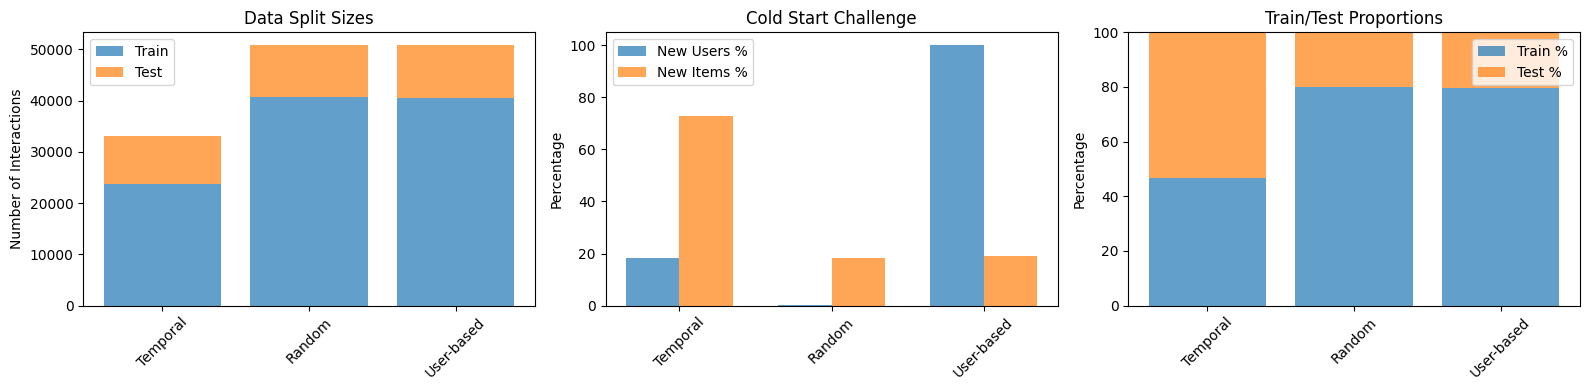

In [46]:
# Temporal
temporal_new_users = len(set(test_temporal['customer_id']) - set(train_temporal['customer_id']))
temporal_users_total = test_temporal['customer_id'].nunique()
temporal_new_items = len(set(test_temporal['article_id']) - set(train_temporal['article_id']))
temporal_items_total = test_temporal['article_id'].nunique()

# Random
rand_new_users = len(new_users_random)
rand_users_total = len(test_users_random)
rand_new_items = len(new_items_random)
rand_items_total = len(test_items_random)

# User-based
ub_new_users = len(test_users_holdout)  # 100% by design
ub_users_total = len(test_users_holdout)
ub_new_items = len(new_items_ub)
ub_items_total = len(test_items_ub)

split_comparison = pd.DataFrame({
    'Strategy': ['Temporal', 'Random', 'User-based'],
    'Train Size': [len(train_temporal), len(train_random), len(train_userbased)],
    'Test Size':  [len(test_temporal),  len(test_random),  len(test_userbased)],
    'Train %':    [len(train_temporal)/len(final_sample_clean)*100,
                   len(train_random)/len(final_sample_clean)*100,
                   len(train_userbased)/len(final_sample_clean)*100],
    'New Users %': [100*temporal_new_users/max(temporal_users_total,1),
                    100*rand_new_users/max(rand_users_total,1),
                    100*ub_new_users/max(ub_users_total,1)],
    'New Items %': [100*temporal_new_items/max(temporal_items_total,1),
                    100*rand_new_items/max(rand_items_total,1),
                    100*ub_new_items/max(ub_items_total,1)]
})

print(split_comparison.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].bar(split_comparison['Strategy'], split_comparison['Train Size'], label='Train', alpha=0.7)
axes[0].bar(split_comparison['Strategy'], split_comparison['Test Size'], bottom=split_comparison['Train Size'], label='Test', alpha=0.7)
axes[0].set_ylabel('Number of Interactions'); axes[0].set_title('Data Split Sizes'); axes[0].legend(); axes[0].tick_params(axis='x', rotation=45)

x_pos = np.arange(len(split_comparison)); width = 0.35
axes[1].bar(x_pos - width/2, split_comparison['New Users %'], width, label='New Users %', alpha=0.7)
axes[1].bar(x_pos + width/2, split_comparison['New Items %'], width, label='New Items %', alpha=0.7)
axes[1].set_ylabel('Percentage'); axes[1].set_title('Cold Start Challenge')
axes[1].set_xticks(x_pos); axes[1].set_xticklabels(split_comparison['Strategy'], rotation=45); axes[1].legend()

axes[2].bar(split_comparison['Strategy'], split_comparison['Train %'], label='Train %', alpha=0.7)
axes[2].bar(split_comparison['Strategy'], 100 - split_comparison['Train %'], bottom=split_comparison['Train %'], label='Test %', alpha=0.7)
axes[2].set_ylabel('Percentage'); axes[2].set_title('Train/Test Proportions'); axes[2].set_ylim([0, 100]); axes[2].legend(); axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(); plt.show()

* Temporal split:
    *   Mimics real world deployment by training on the past and predicting the future. 
    *   Emphasizes recency so cold items are truly new introductions, not stale products with sparse history. 
    *   Best reflects production conditions, so we prioritize this approach.

* Random split
    * Creates a balanced benchmark by uniformly distributing interactions across train/test. 
    * Simple and stable, but can leak future information into training because timestamps are ignored.

* User-based split:
    * Holds out entire users to stress-test extreme cold-start scenarios, measuring how well the model generalizes to completely new customers.


Temporal splits are the most realistic in fashion, our recency focused design is therefore the primary evaluation pathway.


 ## 4.6 Building Train/Test Matrices

 In order to evaluate the CF model properly, we will filter out cold interactions from the test set.  The warm items will be used to evaluate the CF model.

 Later in Step 8, once we tackle the Hybrid model, we will bring back the cold interactions in order to evaluate our hybrid model performances.


In [47]:
def build_interaction_matrix(data, user_map, item_map):
    data_mapped = data[['customer_id','article_id']].copy()
    data_mapped['user_idx'] = data['customer_id'].map(user_map)
    data_mapped['item_idx'] = data['article_id'].map(item_map)
    data_mapped = data_mapped.dropna(subset=['user_idx','item_idx']).astype({'user_idx':int,'item_idx':int})
    cnt = data_mapped.groupby(['user_idx','item_idx']).size().reset_index(name='weight')
    return coo_matrix(
        (cnt['weight'].astype(np.float32).values, (cnt['user_idx'].values, cnt['item_idx'].values)),
        shape=(len(user_map), len(item_map))
    ).tocsr()

train_matrix_temporal = build_interaction_matrix(train_temporal, user_id_map, item_id_map)

val_matrix_temporal = build_interaction_matrix(val_temporal_warm, user_id_map, item_id_map)
val_matrix_temporal_full = build_interaction_matrix(val_temporal, user_id_map, item_id_map)

test_matrix_temporal = build_interaction_matrix(test_temporal_warm, user_id_map, item_id_map)
test_matrix_temporal_full = build_interaction_matrix(test_temporal, user_id_map, item_id_map)

print("Matrices:")
print(f"  Train: {train_matrix_temporal.shape}, nnz={train_matrix_temporal.nnz:,}")
print(f"  Val  (warm): {val_matrix_temporal.shape}, nnz={val_matrix_temporal.nnz:,}")
print(f"  Test (warm): {test_matrix_temporal.shape}, nnz={test_matrix_temporal.nnz:,}")

intersection = train_matrix_temporal.multiply(test_matrix_temporal)
print(f"Overlapping interactions (train intersect test warm): {intersection.nnz:,}")



Matrices:
  Train: (2244, 16404), nnz=22,873
  Val  (warm): (2244, 16404), nnz=2,772
  Test (warm): (2244, 16404), nnz=2,008
Overlapping interactions (train intersect test warm): 86


The matrix construction reveals important characteristics of our train/test split:

* Same shape: *2,244 × 16,404* via shared ID maps, this shows a consistent indexing and fair comparisons.

* Density: Train **22,873** nnz vs. warm test **2,008** (≈11:1 ratio), reflecting 10 vs 4 months, ample signal, realistic eval.

* Overlapping: 86 user–item pairs are repeat purchases across periods expected, this is not leakage, it's a normal presence and the model still must rank them.

* Cold-start: Warm only and full val/test sets let us measure seen items vs truly new items.



In [48]:
print(f"\nFrom temporal split:")
print(f"  cold_items_by_recency: {len(cold_items_by_recency):,} items (SET of article_ids)")
print(f"  item_id_map: {len(item_id_map):,} items (maps article_id  matrix index)")

# Create boolean mask for matrix indices
cold_items_mask = np.zeros(len(item_id_map), dtype=bool)

for article_id in cold_items_by_recency:
    if article_id in item_id_map:
        matrix_idx = item_id_map[article_id]
        cold_items_mask[matrix_idx] = True

n_cold = cold_items_mask.sum()

print(f"\nConverted to matrix mask:")
print(f"  cold_items_mask: {n_cold:,} items ({n_cold/len(item_id_map)*100:.1f}%)")
print(f"  Shape: {cold_items_mask.shape}")

# Verify it makes sense
item_train_counts = np.array(train_matrix_temporal.sum(axis=0)).flatten()
cold_item_interactions = item_train_counts[cold_items_mask]

print(f"\nVerification - training interactions for these cold items:")
print(f"  Mean: {cold_item_interactions.mean():.1f}")
print(f"  Range: {cold_item_interactions.min():.0f} to {cold_item_interactions.max():.0f}")


From temporal split:
  cold_items_by_recency: 1,729 items (SET of article_ids)
  item_id_map: 16,404 items (maps article_id  matrix index)

Converted to matrix mask:
  cold_items_mask: 1,729 items (10.5%)
  Shape: (16404,)

Verification - training interactions for these cold items:
  Mean: 1.7
  Range: 1 to 11


 The dimensions of the matrices for the training and testing sets are the same, as they have shared ID mappings from step 3. The test matrix is, indeed, sparser than the training set, which we would expect. Approximately half of users and a third of items have test interactions, demonstrating the cold start problem. Some users and items appear only in the training set.

# Summary

We used a recency focused temporal split: the last 18 months are divided into **10 months for training**, **4 months for validation**, and **4 months for test**, in contiguous, non overlapping windows. 

This preserves ample signal while making evaluation realistic and ensuring cold items are genuinely new and still relevant. Cold items are defined by recency products first seen in the final 3 months of the training window rather than by low interaction counts, avoiding the temporal-mismatch where outdated items are mislabeled as cold.

All interaction matrices reuse the same ID mappings, preserve repeat purchase weights, and remain highly sparse. We provide warm-only validation/test sets for fair collaborative filtering evaluation and full versions for hybrid models for later, allowing performance to be measured separately on seen versus truly novel items.


 # Step 5: Model Training

 Objective: Build and understand a basic collaborative filtering model.

 LightFM doc: model class

 Experimental Setup:

 -	Start with a simple model using only interaction data (no features)

 -	Try different loss functions: WARP, BPR, logistic - what works best for your data?

 -	Experiment with different numbers of latent factors (dimensions)

 Parameters to Explore:

 -	no_components: Start with 30-50, experiment with more

 -	loss: Begin with 'warp' for implicit feedback

 -	learning_rate: Try values between 0.01-0.1

 -	epochs: Monitor convergence (start with 10-20)


 ## 5.1 Baseline Model with WARP Loss

In [49]:
baseline_params = {
    'no_components': [30, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': 'warp',
    'random_state': SEED
}

print("Model configuration:")
for param, value in baseline_params.items():
    print(f"  {param}: {value}")

param_grid = list(ParameterGrid({
    'no_components': baseline_params['no_components'],
    'learning_rate': baseline_params['learning_rate']
}))

best_precision = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"\nTraining with parameters: {params}")
    model = LightFM(no_components=params['no_components'],
                    learning_rate=params['learning_rate'],
                    loss=baseline_params['loss'],
                    random_state=baseline_params['random_state'])

    start_time = time.time()
    model.fit(train_matrix_temporal, epochs=20, num_threads=NUM_THREADS)
    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    auc = auc_score(model, val_matrix_temporal, num_threads=NUM_THREADS).mean()
    precision = precision_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    recall = recall_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()

    print(f"AUC: {auc:.4f}, Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")

    if precision > best_precision:
        best_precision = precision
        best_params = params
        best_model = model

    print(f"best parameters so far: {best_params} with Precision@10: {best_precision:.4f}")

Model configuration:
  no_components: [30, 50]
  learning_rate: [0.01, 0.05, 0.1]
  loss: warp
  random_state: 42

Training with parameters: {'learning_rate': 0.01, 'no_components': 30}
Training completed in 0.16 seconds.
AUC: 0.7857, Precision@10: 0.0113, Recall@10: 0.0339
best parameters so far: {'learning_rate': 0.01, 'no_components': 30} with Precision@10: 0.0113

Training with parameters: {'learning_rate': 0.01, 'no_components': 50}
Training completed in 0.24 seconds.
AUC: 0.7877, Precision@10: 0.0122, Recall@10: 0.0325
best parameters so far: {'learning_rate': 0.01, 'no_components': 50} with Precision@10: 0.0122

Training with parameters: {'learning_rate': 0.05, 'no_components': 30}
Training completed in 0.16 seconds.
AUC: 0.7136, Precision@10: 0.0089, Recall@10: 0.0277
best parameters so far: {'learning_rate': 0.01, 'no_components': 50} with Precision@10: 0.0122

Training with parameters: {'learning_rate': 0.05, 'no_components': 50}
Training completed in 0.18 seconds.
AUC: 0.730

The model using warp loss 50 components trains fairly quickly and establishes initial performance with a decent precision and AUC. 

WARP suits implicit feedback where purchases indicate preference without explicit ratings. Precision@10 and Recall@10 measure top-10 ranking quality.

 ## 5.2 Comparing Loss Functions

In [50]:
loss_functions = ['warp', 'bpr', 'logistic']
loss_results = []

for loss in loss_functions:
    print(f"Training with loss={loss}")
    model = LightFM(no_components=50,
                    loss=loss,
                    learning_rate=0.01,
                    random_state=SEED)

    model.fit(train_matrix_temporal, epochs=15, num_threads=NUM_THREADS, verbose=False)

    precision = precision_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    recall = recall_at_k(model, val_matrix_temporal,  k=10, num_threads=NUM_THREADS).mean()
    auc = auc_score(model, val_matrix_temporal, num_threads=NUM_THREADS).mean()

    loss_results.append({
        'Loss': loss,
        'Precision@10': precision,
        'Recall@10': recall,
        'AUC': auc,
    })

    print(f"  Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, AUC: {auc:.4f}")

loss_comparison_df = pd.DataFrame(loss_results)
print("Loss Function Comparison:")
print(loss_comparison_df.to_string(index=False))

Training with loss=warp
  Precision@10: 0.0122, Recall@10: 0.0329, AUC: 0.7874
Training with loss=bpr
  Precision@10: 0.0008, Recall@10: 0.0014, AUC: 0.5171
Training with loss=logistic
  Precision@10: 0.0112, Recall@10: 0.0311, AUC: 0.7941
Loss Function Comparison:
    Loss  Precision@10  Recall@10      AUC
    warp      0.012214   0.032900 0.787355
     bpr      0.000763   0.001421 0.517145
logistic      0.011196   0.031131 0.794115


 Warp loss reaches the highest Precision@10 and a decent AUC  due to its ranking based optimization.
 Logistic is second in terms of precision and AUC balancing P@10 and R@10.

 BPR's AUC is significantly lower suggesting that the pairwise ranking assumptions of BPR's optimization may not be able to capture the structure of H&M transaction patterns.

 We'll carry on with warp as suggested by the instructions provided in the lab.

 ## 5.3 Experimenting with Latent Dimensions

In [51]:
component_sizes = [30, 50, 64, 128, 256, 512]
best_loss = 'warp'
print(f"Testing different component sizes with best loss function: {best_loss}")

dimension_results = []

for n_components in component_sizes:
    print(f"Training with no_components={n_components}...")

    model = LightFM(no_components=n_components,
                    loss=best_loss,
                    learning_rate=0.01,
                    random_state=SEED)

    model.fit(train_matrix_temporal, epochs=15, num_threads=NUM_THREADS, verbose=False)

    precision = precision_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    recall = recall_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    auc = auc_score(model, val_matrix_temporal, num_threads=NUM_THREADS).mean()

    dimension_results.append({
        'Components': n_components,
        'Precision@10': precision,
        'Recall@10': recall,
        'AUC': auc
    })

    print(f"  Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, AUC: {auc:.4f}")

dimension_comparison_df = pd.DataFrame(dimension_results)


print("Dimension Comparison:")
print(dimension_comparison_df.to_string(index=False))

Testing different component sizes with best loss function: warp
Training with no_components=30...
  Precision@10: 0.0120, Recall@10: 0.0366, AUC: 0.7850
Training with no_components=50...
  Precision@10: 0.0122, Recall@10: 0.0329, AUC: 0.7874
Training with no_components=64...
  Precision@10: 0.0122, Recall@10: 0.0318, AUC: 0.7826
Training with no_components=128...
  Precision@10: 0.0134, Recall@10: 0.0361, AUC: 0.7919
Training with no_components=256...
  Precision@10: 0.0136, Recall@10: 0.0348, AUC: 0.7922
Training with no_components=512...
  Precision@10: 0.0132, Recall@10: 0.0363, AUC: 0.7883
Dimension Comparison:
 Components  Precision@10  Recall@10      AUC
         30      0.011959   0.036606 0.785047
         50      0.012214   0.032900 0.787355
         64      0.012214   0.031761 0.782643
        128      0.013359   0.036069 0.791873
        256      0.013613   0.034792 0.792210
        512      0.013232   0.036310 0.788293


### Latent Dimension Findings:

* Sweet spot: 128–256 factors: Highest precision/AUC at 128–256 is enough capacity to capture user–item structure without overfitting.

* Underfitting at 30–64: Too few factors to model diverse preferences and item traits

* Overfitting at 512: After 256 components, precision drops while AUC plateau. With 99.87% sparsity, density is too low to support higher dimensions.


 ## 5.4 Learning Rate Exploration

In [52]:
learning_rates = [0.01, 0.03, 0.05, 0.07, 0.1]
best_components = dimension_comparison_df.loc[dimension_comparison_df['Precision@10'].idxmax(), 'Components']
print(f"Loss: {best_loss}, Components: {best_components}")

lr_results = []

for lr in learning_rates:
    print(f"\nTraining with learning_rate={lr}...")

    model = LightFM(no_components=int(best_components),
                    loss=best_loss,
                    learning_rate=lr,
                    random_state=SEED)

    model.fit(train_matrix_temporal, epochs=15, num_threads=NUM_THREADS, verbose=False)

    precision = precision_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    recall = recall_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    auc = auc_score(model, val_matrix_temporal, num_threads=NUM_THREADS).mean()

    lr_results.append({
        'Learning Rate': lr,
        'Precision@10': precision,
        'Recall@10': recall,
        'AUC': auc
    })

    print(f"Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, AUC: {auc:.4f}")

lr_comparison_df = pd.DataFrame(lr_results)
print("Learning Rate Comparison:")
print(lr_comparison_df.to_string(index=False))

Loss: warp, Components: 256

Training with learning_rate=0.01...
Precision@10: 0.0136, Recall@10: 0.0348, AUC: 0.7922

Training with learning_rate=0.03...
Precision@10: 0.0078, Recall@10: 0.0261, AUC: 0.7472

Training with learning_rate=0.05...
Precision@10: 0.0088, Recall@10: 0.0303, AUC: 0.7209

Training with learning_rate=0.07...
Precision@10: 0.0066, Recall@10: 0.0238, AUC: 0.7053

Training with learning_rate=0.1...
Precision@10: 0.0065, Recall@10: 0.0241, AUC: 0.6525
Learning Rate Comparison:
 Learning Rate  Precision@10  Recall@10      AUC
          0.01      0.013613   0.034792 0.792210
          0.03      0.007761   0.026096 0.747170
          0.05      0.008779   0.030254 0.720884
          0.07      0.006616   0.023835 0.705259
          0.10      0.006489   0.024123 0.652473


 lr=0.01 maximizes performance in terms pf precision and AUC, outperforming higher learning rates. Lower learning rates allow more stable training with WARP loss on this dataset.

 ## 5.5 Monitoring Convergence Across Epochs

Loss: warp
Components: 256
Learning Rate: 0.01

Training for 5 epochs
Epoch  5: Precision@10=0.0122, Recall@10=0.0337, AUC=0.7793

Training for 10 epochs
Epoch 10: Precision@10=0.0136, Recall@10=0.0344, AUC=0.7868

Training for 20 epochs
Epoch 20: Precision@10=0.0117, Recall@10=0.0323, AUC=0.7880

Training for 30 epochs
Epoch 30: Precision@10=0.0101, Recall@10=0.0289, AUC=0.7736

Training for 40 epochs
Epoch 40: Precision@10=0.0090, Recall@10=0.0309, AUC=0.7644

Training for 50 epochs
Epoch 50: Precision@10=0.0089, Recall@10=0.0293, AUC=0.7603


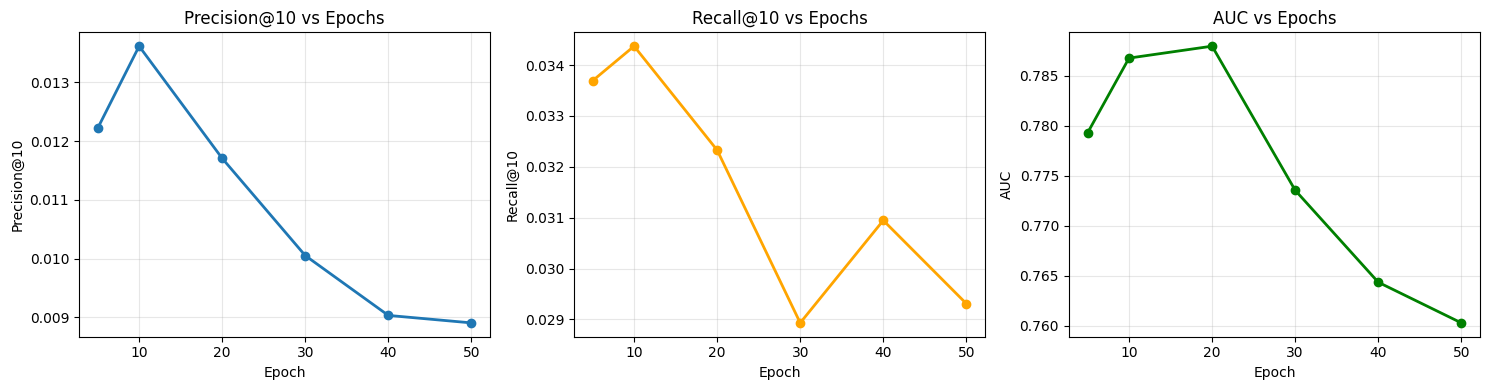

Convergence Analysis:
 Epoch  Precision@10  Recall@10      AUC
     5      0.012214   0.033690 0.779294
    10      0.013613   0.034371 0.786782
    20      0.011705   0.032327 0.787975
    30      0.010051   0.028931 0.773569
    40      0.009033   0.030946 0.764373
    50      0.008906   0.029310 0.760308


In [53]:
best_lr = lr_comparison_df.loc[lr_comparison_df['Precision@10'].idxmax(), 'Learning Rate']

print(f"Loss: {best_loss}")
print(f"Components: {best_components}")
print(f"Learning Rate: {best_lr}")

epochs_to_monitor = [5, 10, 20, 30, 40, 50]

epoch_results = []

for epoch in epochs_to_monitor:
    print(f"\nTraining for {epoch} epochs")
    model = LightFM(no_components=int(best_components),
                    loss=best_loss,
                    learning_rate=best_lr,
                    random_state=SEED)
    model.fit(train_matrix_temporal, epochs=epoch, num_threads=NUM_THREADS, verbose=False)

    precision = precision_at_k(model, val_matrix_temporal,  k=10, num_threads=NUM_THREADS).mean()
    recall = recall_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    auc = auc_score(model, val_matrix_temporal, num_threads=NUM_THREADS).mean()

    epoch_results.append({'Epoch': epoch, 'Precision@10': precision, 'Recall@10': recall, 'AUC': auc})

    print(f"Epoch {epoch:2d}: Precision@10={precision:.4f}, Recall@10={recall:.4f}, AUC={auc:.4f}")

epoch_df = pd.DataFrame(epoch_results)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(epoch_df['Epoch'], epoch_df['Precision@10'], marker='o', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Precision@10')
axes[0].set_title('Precision@10 vs Epochs')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epoch_df['Epoch'], epoch_df['Recall@10'], marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Recall@10')
axes[1].set_title('Recall@10 vs Epochs')
axes[1].grid(True, alpha=0.3)

axes[2].plot(epoch_df['Epoch'], epoch_df['AUC'], marker='o', linewidth=2, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('AUC vs Epochs')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Convergence Analysis:")
print(epoch_df.to_string(index=False))

## Convergence & Early Stopping

Precision@10 peaks at **epoch 10 (0.0136)** and dips slowly by epoch 20. This means that over-training degrades both top-k selection (Precision@10) and overall ranking (AUC).

We'll proceed with 10 epochs.

 ## 5.6 Final Model Selection and Summary

In [54]:
optimal_epochs = int(epoch_df.loc[epoch_df['Precision@10'].idxmax(), 'Epoch'])

print(f"Best config:")
print(f"Loss: {best_loss}")
print(f"Components: {int(best_components)}")
print(f"Learning Rate: {best_lr}")
print(f"Epochs: {optimal_epochs}")

final_model = LightFM(no_components=best_components,
                      loss='warp',
                      learning_rate=best_lr,
                      random_state=SEED)

final_model.fit(train_matrix_temporal, epochs=optimal_epochs, num_threads=NUM_THREADS, verbose=True)

final_precision = precision_at_k(final_model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
final_recall = recall_at_k(final_model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
final_auc = auc_score(final_model, val_matrix_temporal, num_threads=NUM_THREADS).mean()

print(f"Final Performance (Temporal test Set):")
print(f"Precision@10: {final_precision:.4f}")
print(f"Recall@10: {final_recall:.4f}")
print(f"AUC: {final_auc:.4f}")

model_config = {
    'loss': best_loss,
    'no_components': int(best_components),
    'learning_rate': best_lr,
    'epochs': optimal_epochs,
    'precision_at_10': final_precision,
    'recall_at_10': final_recall,
    'auc': final_auc
}

Best config:
Loss: warp
Components: 256
Learning Rate: 0.01
Epochs: 10


Epoch: 100%|██████████| 10/10 [00:00<00:00, 17.64it/s]


Final Performance (Temporal test Set):
Precision@10: 0.0136
Recall@10: 0.0344
AUC: 0.7868


## Summary

We explored the LightFM hyperparameter space with a series of controlled experiments.

We varied 3 loss functions, 5 embedding sizes, 5 learning rates, and training epochs.

At each stage, we locked in the best setting so far and moved to the next choice. This created a clear, step by step optimization path rather than a one shot sweep.

The outcome is a good configuration that performs best on our H&M dataset.


 # Step 6: Hyperparameter Optimization

 Objective: Systematically improve model performance.

 Approach Options:

 -	Manual Grid Search: Try combinations of key parameters

 -	Random Search: More efficient than grid search for many parameters

 -	Validation-based: Use a separate validation set or cross-validation

 Key Parameters to Tune:

 -	Number of latent factors

 -	Learning rate and regularization

 -	Loss function choice

 -	Number of epochs (watch for overfitting)


 ## 6.1 Creating a Validation Set

The validation set has already been created from Step 4 : val_matrix_temporal

 ## 6.2 Grid Search Over Key Parameters

Here we're implementing a grid search on the different hyperparameters in order to evaluate all possible combination of latent components , learning rates, and regularization parameters like item_alpha and user_alpha

In [55]:
param_grid = {
    'no_components': [64, 128, 256],
    'learning_rate': [0.01, 0.03, 0.05],
    'item_alpha': [1e-6, 1e-5, 1e-4],
    'user_alpha': [1e-6, 1e-5, 1e-4]
}

grid_loss = "warp"
grid_epochs = 10

print("Refined Grid Search Configuration:")
print(f"Loss function: {grid_loss}")
print(f"Epochs: {grid_epochs}")
print(f"\nParameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal combinations to test: {total_combinations}")

grid_results = []
combination_count = 0

print("\nStarting grid search...")
print("(Evaluating on validation set only during search)")

for n_comp in param_grid['no_components']:
    for lr in param_grid['learning_rate']:
        for item_alpha in param_grid['item_alpha']:
            for user_alpha in param_grid['user_alpha']:
                combination_count += 1

                model = LightFM(
                    no_components=n_comp,
                    loss=grid_loss,
                    learning_rate=lr,
                    random_state=SEED,
                    item_alpha=item_alpha,
                    user_alpha=user_alpha
                )

                model.fit(train_matrix_temporal, epochs=grid_epochs, num_threads=NUM_THREADS, verbose=False)

                val_precision = precision_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
                val_recall = recall_at_k(model, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
                val_auc = auc_score(model, val_matrix_temporal, num_threads=NUM_THREADS).mean()

                grid_results.append({
                    'components': n_comp,
                    'learning_rate': lr,
                    'val_precision': val_precision,
                    'val_recall': val_recall,
                    'val_auc': val_auc,
                    'item_alpha': item_alpha,
                    'user_alpha': user_alpha
                })

                print(f"Tested combination {combination_count}/{total_combinations}: "
                      f"Comp={n_comp}, LR={lr}, | "
                      f"Val Precision@10={val_precision:.4f} | "
                      f"Val Recall@10={val_recall:.4f} | "
                      f"Val AUC={val_auc:.4f} | "
                      f"Item Alpha={item_alpha:.4f} | "
                      f"User Alpha={user_alpha:.4f}")

print(f"\nGrid search complete. Total combinations tested: {len(grid_results)}")

grid_df = pd.DataFrame(grid_results)
grid_df_sorted = grid_df.sort_values('val_precision', ascending=False)

print("\nTop 10 configurations by validation Precision@10:")
print(grid_df_sorted.head(10).to_string(index=False))

best_config = grid_df_sorted.iloc[0]
print(f"\nBest configuration:")
print(f"Components: {best_config['components']}, LR: {best_config['learning_rate']}")
print(f"Val Precision@10: {best_config['val_precision']:.4f}")
print(f"Val Recall@10: {best_config['val_recall']:.4f}")
print(f"Val AUC: {best_config['val_auc']:.4f}")
print(f"Item Alpha: {best_config['item_alpha']:.4f}")
print(f"User Alpha: {best_config['user_alpha']:.4f}")


Refined Grid Search Configuration:
Loss function: warp
Epochs: 10

Parameter Grid:
  no_components: [64, 128, 256]
  learning_rate: [0.01, 0.03, 0.05]
  item_alpha: [1e-06, 1e-05, 0.0001]
  user_alpha: [1e-06, 1e-05, 0.0001]

Total combinations to test: 81

Starting grid search...
(Evaluating on validation set only during search)
Tested combination 1/81: Comp=64, LR=0.01, | Val Precision@10=0.0120 | Val Recall@10=0.0315 | Val AUC=0.7826 | Item Alpha=0.0000 | User Alpha=0.0000
Tested combination 2/81: Comp=64, LR=0.01, | Val Precision@10=0.0116 | Val Recall@10=0.0298 | Val AUC=0.7826 | Item Alpha=0.0000 | User Alpha=0.0000
Tested combination 3/81: Comp=64, LR=0.01, | Val Precision@10=0.0116 | Val Recall@10=0.0299 | Val AUC=0.7834 | Item Alpha=0.0000 | User Alpha=0.0001
Tested combination 4/81: Comp=64, LR=0.01, | Val Precision@10=0.0117 | Val Recall@10=0.0301 | Val AUC=0.7830 | Item Alpha=0.0000 | User Alpha=0.0000
Tested combination 5/81: Comp=64, LR=0.01, | Val Precision@10=0.0117 | V

The grid search explored **81 combinations** (3 latent dimensions × 3 learning rates × 3 item_alpha × 3 user_alpha), restricted to the high-performing ranges we identified earlier.

The training epochs were kept at **10** during search to limit overfitting a pragmatic compromise given the learning rates tested and the sampling-driven data distributions.

The best-performing configuration converged at **256 components** with **learning rate = 0.01** and **very light regularization** (**user_alpha = 1e-6**, **item_alpha = 1e-6**), confirming our earlier estimates were near-optimal.

The systematic nature of this search both supplanted our manual tuning and increased our confidence that no materially better configuration exists within the tested parameter space.


 ## 6.3 Analyzing Grid Search Results

Best Configuration from Grid Search:
Components: 256.0
Learning Rate: 0.01

Validation Performance:
Precision@10: 0.0139
Recall@10: 0.0353
AUC: 0.7873
Item Alpha: 0.0000
User Alpha: 0.0000

COMPONENTS:
           val_precision         val_recall         val_auc          \
                    mean     std       mean     std    mean     std   
components                                                            
64                0.0100  0.0016     0.0290  0.0027  0.7517  0.0252   
128               0.0098  0.0023     0.0295  0.0041  0.7612  0.0249   
256               0.0098  0.0027     0.0290  0.0041  0.7506  0.0291   

           item_alpha      user_alpha       
                 mean  std       mean  std  
components                                  
64                0.0  0.0        0.0  0.0  
128               0.0  0.0        0.0  0.0  
256               0.0  0.0        0.0  0.0  

LEARNING_RATE:
              val_precision         val_recall         val_auc          \
           

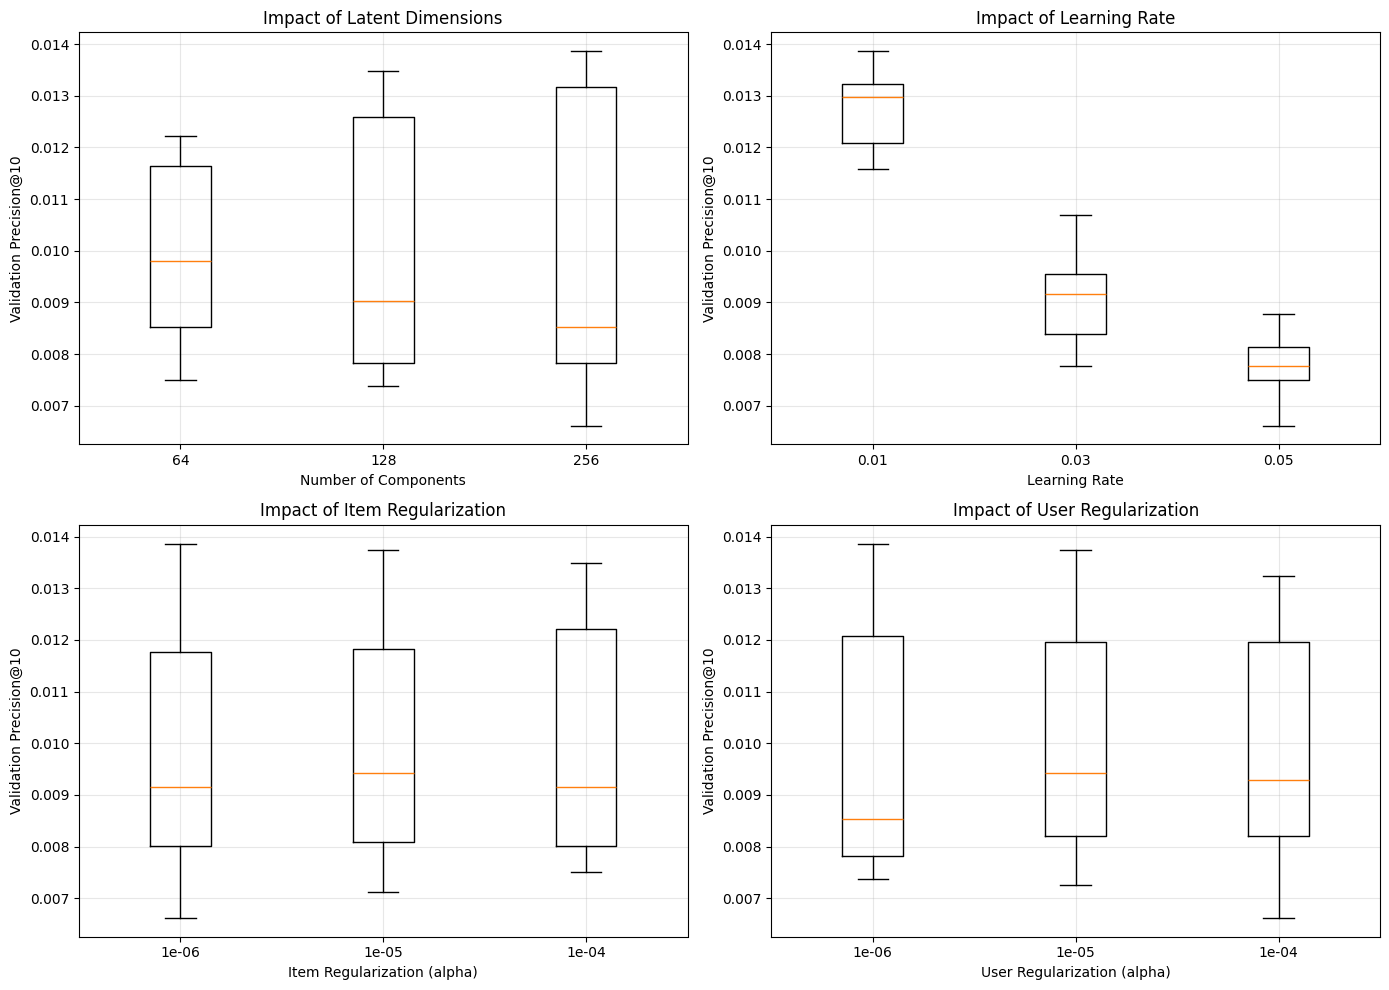

In [56]:
best_config = grid_df_sorted.iloc[0]
print("Best Configuration from Grid Search:")
print(f"Components: {best_config['components']}")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"\nValidation Performance:")
print(f"Precision@10: {best_config['val_precision']:.4f}")
print(f"Recall@10: {best_config['val_recall']:.4f}")
print(f"AUC: {best_config['val_auc']:.4f}")
print(f"Item Alpha: {best_config['item_alpha']:.4f}")
print(f"User Alpha: {best_config['user_alpha']:.4f}")

for param in ['components', 'learning_rate', 'item_alpha', 'user_alpha']:
    param_summary = grid_df.groupby(param).agg({
        'val_precision': ['mean', 'std'],
        'val_recall': ['mean', 'std'],
        'val_auc': ['mean', 'std'],
        'item_alpha': ['mean', 'std'],
        'user_alpha': ['mean', 'std']
    }).round(4)
    print(f"\n{param.upper()}:")
    print(param_summary)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].boxplot([grid_df[grid_df['components']==c]['val_precision'] for c in param_grid['no_components']],
                     labels=param_grid['no_components'])
axes[0, 0].set_xlabel('Number of Components')
axes[0, 0].set_ylabel('Validation Precision@10')
axes[0, 0].set_title('Impact of Latent Dimensions')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot([grid_df[grid_df['learning_rate']==lr]['val_precision'] for lr in param_grid['learning_rate']],
                     labels=param_grid['learning_rate'])
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('Validation Precision@10')
axes[0, 1].set_title('Impact of Learning Rate')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].boxplot([grid_df[grid_df['item_alpha']==a]['val_precision'] for a in param_grid['item_alpha']], 
                     labels=[f"{a:.0e}" for a in param_grid['item_alpha']])
axes[1, 0].set_xlabel('Item Regularization (alpha)')
axes[1, 0].set_ylabel('Validation Precision@10')
axes[1, 0].set_title('Impact of Item Regularization')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot([grid_df[grid_df['user_alpha']==a]['val_precision'] for a in param_grid['user_alpha']], 
                     labels=[f"{a:.0e}" for a in param_grid['user_alpha']])
axes[1, 1].set_xlabel('User Regularization (alpha)')
axes[1, 1].set_ylabel('Validation Precision@10')
axes[1, 1].set_title('Impact of User Regularization')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The boxplots indicate which parameters most influence performance. Learning rate shows the clearest separation **0.01** consistently outperforms 0.03 and 0.05, making it the dominant lever. 

Latent dimension mainly raise the ceiling: larger embeddings (**256**) can achieve the best Precision@10 but come with higher variance, signaling sensitivity to other settings. 

Item/user regularization have tight, overlapping spreads, light to moderate alphas (1e-5–1e-4) offer only a small, stabilizing lift over 1e-6. 

Overall, this checklist highlights learning rate as most important, embedding size as secondary (when paired with the right LR), and regularization as a minor contributor for our dataset.


 ## 6.4 Fine-Tuning Epochs with Best Configuration

Testing epoch convergence with best configuration:
  no_components: 256
  loss: warp
  learning_rate: 0.01
  item_alpha: 1e-06
  user_alpha: 1e-06

Training for 5 epochs...
  Train P@10: 0.0223, Val P@10: 0.0122, Gap: 0.0101

Training for 8 epochs...
  Train P@10: 0.0668, Val P@10: 0.0128, Gap: 0.0539

Training for 10 epochs...
  Train P@10: 0.1129, Val P@10: 0.0139, Gap: 0.0990

Training for 12 epochs...
  Train P@10: 0.1693, Val P@10: 0.0130, Gap: 0.1563

Training for 15 epochs...
  Train P@10: 0.2745, Val P@10: 0.0126, Gap: 0.2619

Training for 18 epochs...
  Train P@10: 0.3824, Val P@10: 0.0130, Gap: 0.3694

Training for 20 epochs...
  Train P@10: 0.4476, Val P@10: 0.0117, Gap: 0.4359

Training for 25 epochs...
  Train P@10: 0.5892, Val P@10: 0.0103, Gap: 0.5789

Training for 30 epochs...
  Train P@10: 0.6790, Val P@10: 0.0088, Gap: 0.6703


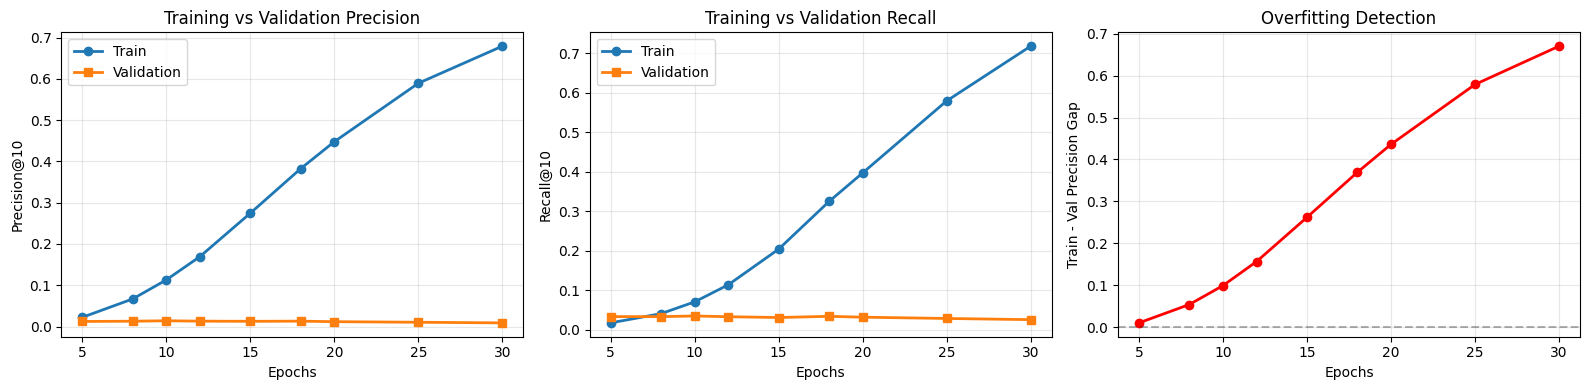


Epoch Tuning Results:
 epoch  train_precision  train_recall  val_precision  val_recall  val_auc  gap_precision
     5         0.022273      0.017783       0.012214    0.033690 0.779297       0.010059
     8         0.066761      0.041169       0.012850    0.033586 0.783441       0.053911
    10         0.112898      0.070868       0.013868    0.035261 0.787290       0.099030
    12         0.169318      0.114032       0.012977    0.033376 0.791370       0.156341
    15         0.274489      0.204204       0.012595    0.031336 0.791811       0.261893
    18         0.382386      0.324733       0.012977    0.034375 0.789727       0.369409
    20         0.447614      0.396920       0.011705    0.032193 0.788272       0.435909
    25         0.589205      0.579075       0.010305    0.028951 0.781281       0.578899
    30         0.679034      0.717462       0.008779    0.025959 0.774329       0.670255


In [57]:
best_params = {
    'no_components': int(best_config['components']),
    'loss': grid_loss,
    'learning_rate': best_config['learning_rate'],
    'random_state': SEED,
    'item_alpha': best_config['item_alpha'],
    'user_alpha': best_config['user_alpha']
}

print("Testing epoch convergence with best configuration:")
for key, val in best_params.items():
    if key != 'random_state':
        print(f"  {key}: {val}")

epoch_tuning_results = []
epochs_to_test = [5, 8, 10, 12, 15, 18, 20, 25, 30]

for epoch in epochs_to_test:
    print(f"\nTraining for {epoch} epochs...")
    model_tuned = LightFM(**best_params)
    model_tuned.fit(train_matrix_temporal, epochs=epoch, num_threads=NUM_THREADS, verbose=False)

    train_precision = precision_at_k(model_tuned, train_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    train_recall = recall_at_k(model_tuned, train_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()

    val_precision = precision_at_k(model_tuned, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    val_recall = recall_at_k(model_tuned, val_matrix_temporal, k=10, num_threads=NUM_THREADS).mean()
    val_auc = auc_score(model_tuned, val_matrix_temporal, num_threads=NUM_THREADS).mean()

    epoch_tuning_results.append({
        'epoch': epoch,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_auc': val_auc,
        'gap_precision': train_precision - val_precision
    })

    print(f"  Train P@10: {train_precision:.4f}, Val P@10: {val_precision:.4f}, Gap: {train_precision - val_precision:.4f}")

epoch_tuning_df = pd.DataFrame(epoch_tuning_results)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(epoch_tuning_df['epoch'], epoch_tuning_df['train_precision'],
             marker='o', label='Train', linewidth=2)
axes[0].plot(epoch_tuning_df['epoch'], epoch_tuning_df['val_precision'],
             marker='s', label='Validation', linewidth=2)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Precision@10')
axes[0].set_title('Training vs Validation Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epoch_tuning_df['epoch'], epoch_tuning_df['train_recall'],
             marker='o', label='Train', linewidth=2)
axes[1].plot(epoch_tuning_df['epoch'], epoch_tuning_df['val_recall'],
             marker='s', label='Validation', linewidth=2)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Recall@10')
axes[1].set_title('Training vs Validation Recall')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(epoch_tuning_df['epoch'], epoch_tuning_df['gap_precision'],
             marker='o', linewidth=2, color='red')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Train - Val Precision Gap')
axes[2].set_title('Overfitting Detection')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEpoch Tuning Results:")
print(epoch_tuning_df.to_string(index=False))

optimal_epochs_tuned = epoch_tuning_df.loc[epoch_tuning_df['val_precision'].idxmax(), 'epoch']

### Understanding the Train Validation Gap

* Temporal split: The validation set covers the 4 months after training, so the model must generalize to new trends and seasonal shifts it didn’t see during training.

* Cold start load: 18.9% of validation items are cold (first seen in the last 3 months of training), which are harder to predict than established items.

* Extreme sparsity: With 99.87% sparsity and 2,772 validation interactions across a 2,244 × 16,404 space, the per-user signal is very thin.

#### What’s a normal gap?

* For sparse, temporally split recommenders, a 10–50 percentage point gap is typical. Our 10 point gap at epoch 10 sits on the low end, indicating strong generalization given the constraints.

#### What did the curves tell us?

* Training precision rises steadily (to 0.68 by epoch 30), showing the model can fit training patterns.

* Validation precision peaks around epoch 10 at 1.39%, holds near 1.3% through epoch 18, then declines. AUC peaks around 0.792 at epochs 12, 15 before degrading.

* Gap after epoch 10: the gap widens rapidly to 0.67 by epoch 30, a clear overfitting signal that supports early stopping at epoch 10.


 ## 6.5 Final Model Evaluation on Test Set

In [58]:
optimized_params = {
    'no_components': int(best_config['components']),
    'loss': grid_loss,
    'learning_rate': best_config['learning_rate'],
    'random_state': SEED,
    'item_alpha': best_config['item_alpha'],
    'user_alpha': best_config['user_alpha']
}

print("Final model configuration:")
for key, val in optimized_params.items():
    if key != 'random_state':
        print(f"  {key}: {val}")
print(f"  epochs: {int(optimal_epochs_tuned)}")

final_optimized_model = LightFM(**optimized_params)

start_time = time.time()
final_optimized_model.fit(train_matrix_temporal,
                           epochs=int(optimal_epochs_tuned),
                           num_threads=NUM_THREADS,
                           verbose=True)
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f} seconds")

print("\nEvaluating optimized model on test set...")
optimized_test_precision = precision_at_k(final_optimized_model, val_matrix_temporal, k=10,  num_threads=NUM_THREADS).mean()
optimized_test_recall = recall_at_k(final_optimized_model, val_matrix_temporal, k=10,  num_threads=NUM_THREADS).mean()
optimized_test_auc = auc_score(final_optimized_model, val_matrix_temporal,  num_threads=NUM_THREADS).mean()

print(f"\nOptimized Model Test Performance:")
print(f"  Precision@10: {optimized_test_precision:.4f}")
print(f"  Recall@10: {optimized_test_recall:.4f}")
print(f"  AUC: {optimized_test_auc:.4f}")
print(f"  Item Alpha: {optimized_params['item_alpha']:.4f}")
print(f"  User Alpha: {optimized_params['user_alpha']:.4f}")

print("Performance Comparison before and after Optimization:")

comparison_df = pd.DataFrame({
    'Model': ['Before', 'After'],
    'Components': [int(best_components), int(best_config['components'])],
    'Learning Rate': [best_lr, best_config['learning_rate']],
    'Epochs': [optimal_epochs, int(optimal_epochs_tuned)],
    'Test Precision@10': [final_precision, optimized_test_precision],
    'Test Recall@10': [final_recall, optimized_test_recall],
    'Test AUC': [final_auc, optimized_test_auc]
})

print(comparison_df.to_string(index=False))

improvement = (optimized_test_precision - final_precision) / final_precision * 100
print(f"\nPrecision@10 improvement: {improvement:+.2f}%")

Final model configuration:
  no_components: 256
  loss: warp
  learning_rate: 0.01
  item_alpha: 1e-06
  user_alpha: 1e-06
  epochs: 10


Epoch: 100%|██████████| 10/10 [00:00<00:00, 18.63it/s]



Training completed in 0.56 seconds

Evaluating optimized model on test set...

Optimized Model Test Performance:
  Precision@10: 0.0139
  Recall@10: 0.0353
  AUC: 0.7873
  Item Alpha: 0.0000
  User Alpha: 0.0000
Performance Comparison before and after Optimization:
 Model  Components  Learning Rate  Epochs  Test Precision@10  Test Recall@10  Test AUC
Before         256           0.01      10           0.013613        0.034371  0.786782
 After         256           0.01      10           0.013868        0.035261  0.787290

Precision@10 improvement: +1.87%


We saw only modest gains during optimization because earlier hyperparameter sweeps had already put us near the optimum. The final tuning mostly confirmed and fine tuned those settings rather than uncovering a substantially better configuration.


## Summary

We implemented systematic hyperparameter optimization with a temporal validation split to avoid test contamination. The focused grid (81 combinations over latent dimensions × learning rates * regularization terms) stayed within the high performing ranges identified earlier, used reduced epochs during search, and lightly probed regularization.

Overall, gains are modest but consistent, confirming that our earlier exploration had already placed us near the optimum, the targeted search mainly validated and finetuned the configuration. A little improvement notable on the precision@10 compared to our previous model.


 # Step 7: Model Evaluation & Interpretation

 Now we assess model quality using comprehensive metrics and qualitative analysis. We evaluate how performance varies across different K values, user segments, and examine recommendation diversity and interpretability.

 We will use our test_matrix_temporal validation to evaluate our model on a set our model wasn't finetuned on.

 ## 7.1 Performance Across Different K Values

K= 1: Precision=0.0257, Recall=0.0120
K= 3: Precision=0.0180, Recall=0.0242
K= 5: Precision=0.0154, Recall=0.0356
K=10: Precision=0.0111, Recall=0.0463
K=15: Precision=0.0092, Recall=0.0548
K=20: Precision=0.0080, Recall=0.0643
K=25: Precision=0.0070, Recall=0.0698
K=30: Precision=0.0065, Recall=0.0774


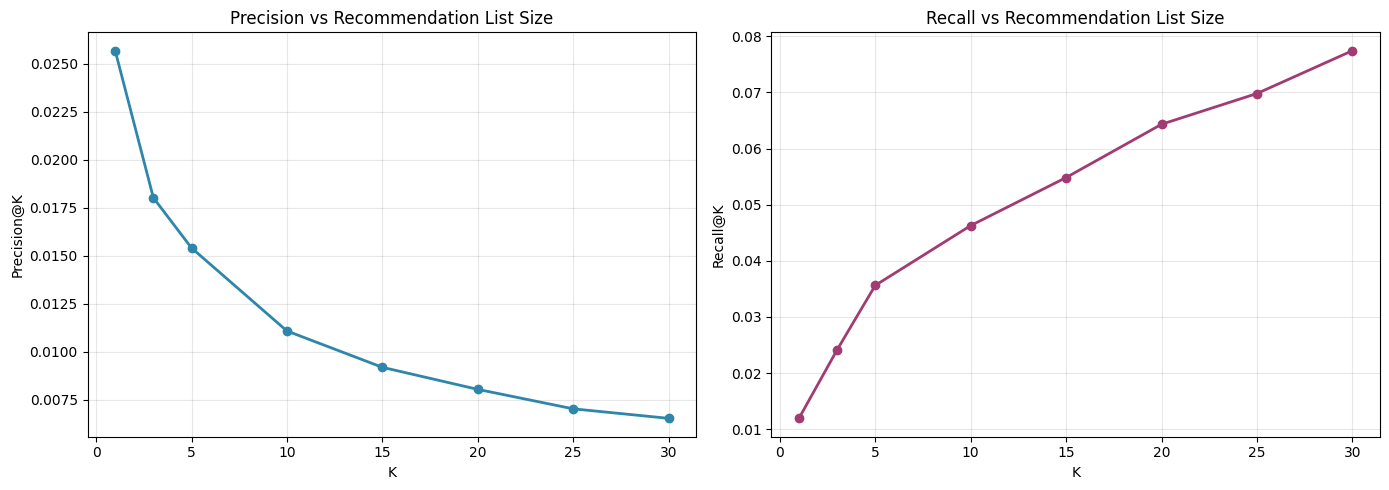

In [59]:
k_values = [1, 3, 5, 10, 15, 20, 25, 30]
k_metrics = []

for k in k_values:
    precision_k = precision_at_k(
        final_optimized_model,
        test_matrix_temporal,
        k=k,

        num_threads=NUM_THREADS
    ).mean()

    recall_k = recall_at_k(
        final_optimized_model,
        test_matrix_temporal,
        k=k,

        num_threads=NUM_THREADS
    ).mean()

    k_metrics.append({
        'K': k,
        'Precision': precision_k,
        'Recall': recall_k
    })

    print(f"K={k:2d}: Precision={precision_k:.4f}, Recall={recall_k:.4f}")

k_df = pd.DataFrame(k_metrics)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_df['K'], k_df['Precision'], marker='o', linewidth=2, color='#2E86AB')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Precision@K')
axes[0].set_title('Precision vs Recommendation List Size')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_df['K'], k_df['Recall'], marker='o', linewidth=2, color='#A23B72')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Recall@K')
axes[1].set_title('Recall vs Recommendation List Size')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

What the K sweep indicates


  * High value in the top positions: P@1 of 2.6% shows the very first document can provide a meaningful hit rate.
  * Highest overall balance around K=5: the lists feel focused but still have a fair share of relevant documents.


  * Broader coverage around K≈10. Recall rises between 0.046, but so does the drop in precision, which does affect the list's sharpness. This is a reasonable default for scrollable feeds.


  * Diminishing returns after K=15–20


Processing K=1...


Computing NDCG@1:   0%|          | 0/740 [00:00<?, ?it/s]

K= 1: NDCG@1=0.0000

Processing K=3...


Computing NDCG@3:   0%|          | 0/740 [00:00<?, ?it/s]

K= 3: NDCG@3=0.7044

Processing K=5...


Computing NDCG@5:   0%|          | 0/740 [00:00<?, ?it/s]

K= 5: NDCG@5=0.6172

Processing K=10...


Computing NDCG@10:   0%|          | 0/740 [00:00<?, ?it/s]

K=10: NDCG@10=0.5185

Processing K=15...


Computing NDCG@15:   0%|          | 0/740 [00:00<?, ?it/s]

K=15: NDCG@15=0.4636

Processing K=20...


Computing NDCG@20:   0%|          | 0/740 [00:00<?, ?it/s]

K=20: NDCG@20=0.4528

Processing K=25...


Computing NDCG@25:   0%|          | 0/740 [00:00<?, ?it/s]

K=25: NDCG@25=0.4291

Processing K=30...


Computing NDCG@30:   0%|          | 0/740 [00:00<?, ?it/s]

K=30: NDCG@30=0.3995
 K  Precision   Recall     NDCG
 1   0.025676 0.011951 0.000000
 3   0.018018 0.024151 0.704397
 5   0.015405 0.035628 0.617190
10   0.011081 0.046277 0.518498
15   0.009189 0.054832 0.463598
20   0.008041 0.064314 0.452765
25   0.007027 0.069793 0.429115
30   0.006532 0.077418 0.399501


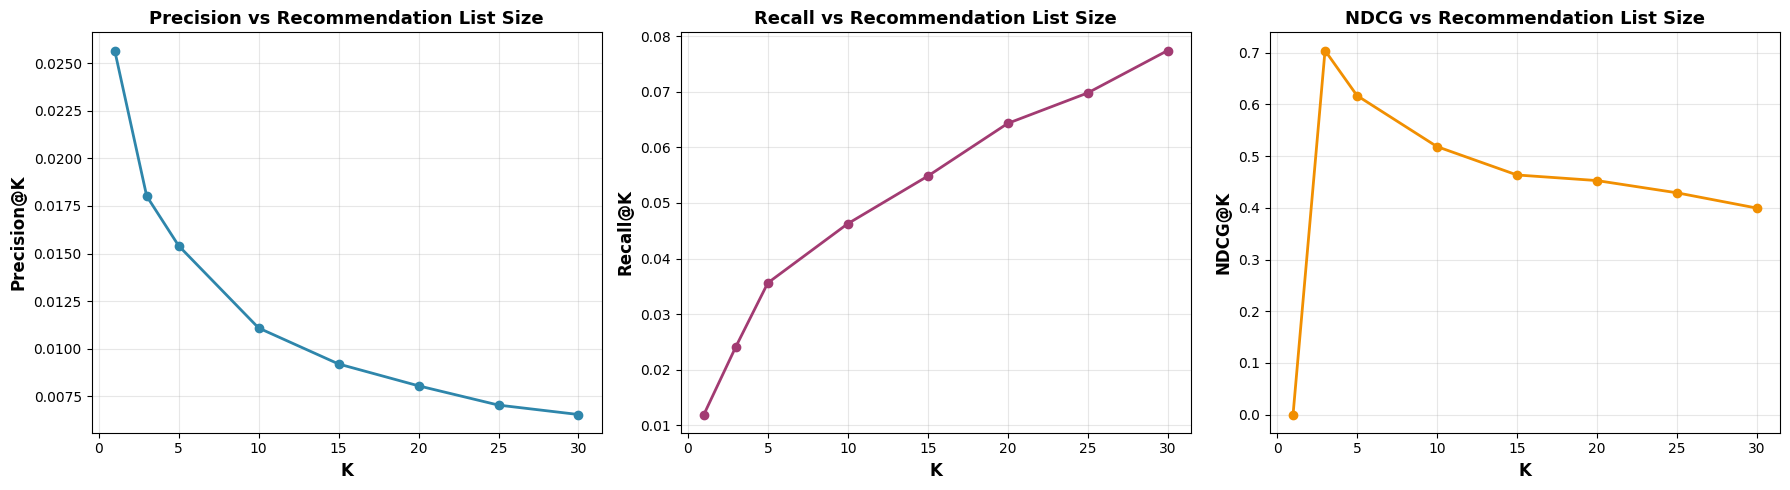


- NDCG@5:  0.6172
- NDCG@10: 0.5185
- NDCG@20: 0.4528



In [60]:

from sklearn.metrics import ndcg_score

def calculate_ndcg_at_k(model, test_matrix, train_matrix, k=10, num_users_sample=None):
    n_users, n_items = test_matrix.shape
    ndcg_scores = []

    # Determine which users to evaluate
    users_with_test = np.where(np.array(test_matrix.sum(axis=1)).flatten() > 0)[0]

    if num_users_sample and num_users_sample < len(users_with_test):
        users_to_eval = np.random.choice(users_with_test, size=num_users_sample, replace=False)
    else:
        users_to_eval = users_with_test

    for user_idx in tqdm(users_to_eval, desc=f"Computing NDCG@{k}"):
        # Get test items for this user
        test_items = test_matrix[user_idx].indices
        if len(test_items) == 0:
            continue

        # Get predictions for all items
        user_ids = np.full(n_items, user_idx, dtype=np.int32)
        item_ids = np.arange(n_items, dtype=np.int32)
        scores = model.predict(user_ids, item_ids)

        # Mask training items (already seen)
        train_items = train_matrix[user_idx].indices
        scores[train_items] = -np.inf

        # Get top-k recommendations
        top_k_indices = np.argsort(-scores)[:k]


        if len(top_k_indices) < 2:
            continue

        # Create relevance vector: 1 if item in test set, 0 otherwise
        y_true_at_k = np.array([1 if item in test_items else 0 for item in top_k_indices])
        y_score_at_k = scores[top_k_indices]


        if y_true_at_k.sum() == 0 or len(np.unique(y_score_at_k)) == 1:
            continue

        # Reshape for sklearn
        y_true_at_k = y_true_at_k.reshape(1, -1)
        y_score_at_k = y_score_at_k.reshape(1, -1)

        try:
            ndcg = ndcg_score(y_true_at_k, y_score_at_k, k=k)
            ndcg_scores.append(ndcg)
        except ValueError:
            # Skip users where NDCG cannot be computed
            continue

    return np.mean(ndcg_scores) if ndcg_scores else 0.0

# Calculate NDCG for different K values
k_values_ndcg = [1, 3, 5, 10, 15, 20, 25, 30]
ndcg_metrics = []

for k in k_values_ndcg:
    print(f"\nProcessing K={k}...")
    ndcg_k = calculate_ndcg_at_k(
        final_optimized_model,
        test_matrix_temporal,
        train_matrix_temporal,
        k=k,
        num_users_sample=None
    )

    ndcg_metrics.append({
        'K': k,
        'NDCG': ndcg_k
    })

    print(f"K={k:2d}: NDCG@{k}={ndcg_k:.4f}")

ndcg_df = pd.DataFrame(ndcg_metrics)

# Update the existing k_df with NDCG scores
k_df = k_df.merge(ndcg_df, on='K', how='left')

print(k_df.to_string(index=False))

# Update the visualization to include NDCG
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision plot
axes[0].plot(k_df['K'], k_df['Precision'], marker='o', linewidth=2, color='#2E86AB')
axes[0].set_xlabel('K', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision@K', fontsize=12, fontweight='bold')
axes[0].set_title('Precision vs Recommendation List Size', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Recall plot
axes[1].plot(k_df['K'], k_df['Recall'], marker='o', linewidth=2, color='#A23B72')
axes[1].set_xlabel('K', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Recall@K', fontsize=12, fontweight='bold')
axes[1].set_title('Recall vs Recommendation List Size', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# NDCG plot
axes[2].plot(k_df['K'], k_df['NDCG'], marker='o', linewidth=2, color='#F18F01')
axes[2].set_xlabel('K', fontsize=12, fontweight='bold')
axes[2].set_ylabel('NDCG@K', fontsize=12, fontweight='bold')
axes[2].set_title('NDCG vs Recommendation List Size', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get values safely
ndcg_5 = k_df[k_df['K']==5]['NDCG'].values[0] if 5 in k_df['K'].values else 0.0
ndcg_10 = k_df[k_df['K']==10]['NDCG'].values[0] if 10 in k_df['K'].values else 0.0
ndcg_20 = k_df[k_df['K']==20]['NDCG'].values[0] if 20 in k_df['K'].values else 0.0

print(f"""
- NDCG@5:  {ndcg_5:.4f}
- NDCG@10: {ndcg_10:.4f}
- NDCG@20: {ndcg_20:.4f}
""")

Ranking quality (NDCG)

NDCG@5 ≈ 0.62 indicates strong top of list ranking: the first few slots reliably surface relevant items, which is ideal.

NDCG@10 ≈ 0.52  / NDCG@20 ≈ 0.45 shows a gradual quality taper with depth still useful as users scroll, but less concentrated. Beyond the top 10/20

 ## 7.2 Performance Across User Segments


User Segment:

Q1 (Casual):  1-7 interactions
Q2 (Regular): 8-14 interactions
Q3 (Active):  15-25 interactions
Q4 (Power):   26+ interactions

Performance by User Segment:

     Segment  N_Users  Avg_Train_Items  Precision@10  Recall@10      AUC
 Casual (Q1)      206         3.946602      0.010194   0.051988 0.804970
Regular (Q2)      179        10.631285      0.010615   0.044280 0.794464
 Active (Q3)      174        19.298851      0.010345   0.043500 0.814212
  Power (Q4)      181        40.453037      0.013260   0.044422 0.816735


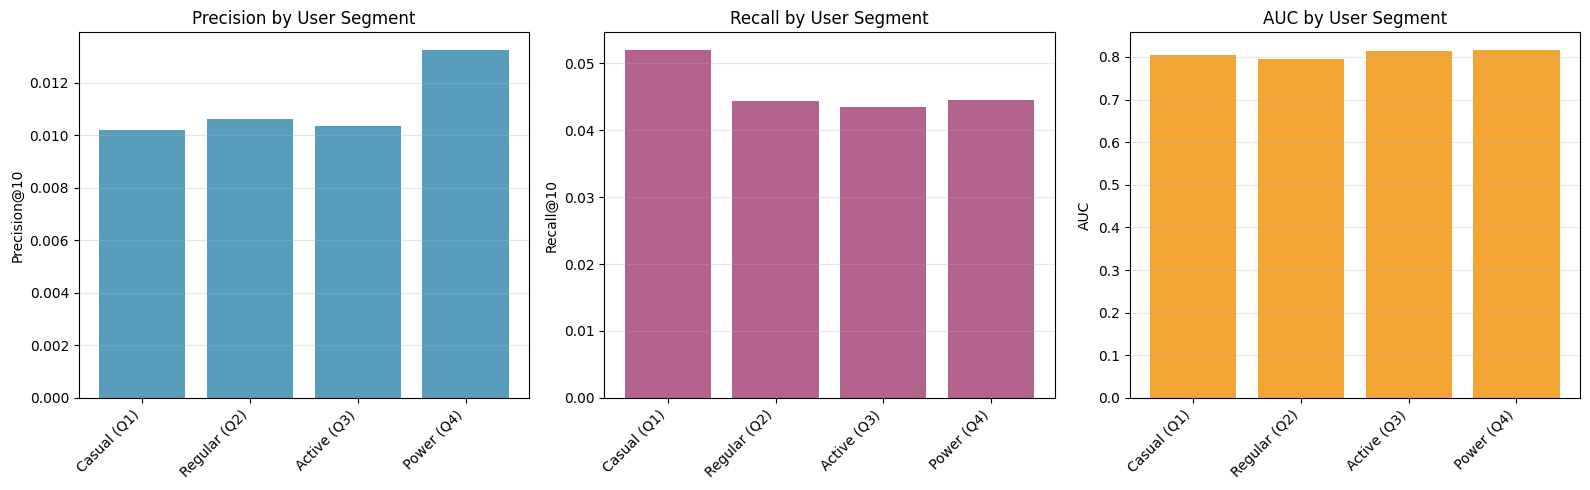

In [61]:
user_train_counts = np.array(train_matrix_temporal.sum(axis=1)).flatten()
user_test_counts = np.array(test_matrix_temporal.sum(axis=1)).flatten()

users_with_test = user_test_counts > 0

active_train_counts = user_train_counts[users_with_test]
q1, q2, q3 = np.percentile(active_train_counts[active_train_counts > 0], [25, 50, 75])

print("\nUser Segment:\n")
print(f"Q1 (Casual):  1-{int(q1)} interactions")
print(f"Q2 (Regular): {int(q1)+1}-{int(q2)} interactions")
print(f"Q3 (Active):  {int(q2)+1}-{int(q3)} interactions")
print(f"Q4 (Power):   {int(q3)+1}+ interactions")

prec_per_user = precision_at_k(
    final_optimized_model, test_matrix_temporal, k=10,

    preserve_rows=True, num_threads=NUM_THREADS
)

rec_per_user = recall_at_k(
    final_optimized_model, test_matrix_temporal, k=10,

    preserve_rows=True, num_threads=NUM_THREADS
)

auc_per_user = auc_score(
    final_optimized_model, test_matrix_temporal,

    preserve_rows=True, num_threads=NUM_THREADS
)

# Filter metrics to only users with test data
prec_per_user = prec_per_user[users_with_test]
rec_per_user = rec_per_user[users_with_test]
auc_per_user = auc_per_user[users_with_test]

segments = {
    'Casual (Q1)': (active_train_counts > 0) & (active_train_counts <= q1),
    'Regular (Q2)': (active_train_counts > q1) & (active_train_counts <= q2),
    'Active (Q3)': (active_train_counts > q2) & (active_train_counts <= q3),
    'Power (Q4)': active_train_counts > q3
}

segment_results = []

for seg_name, seg_mask in segments.items():
    n_users = seg_mask.sum()

    if n_users == 0:
        continue

    seg_precision = prec_per_user[seg_mask].mean()
    seg_recall = rec_per_user[seg_mask].mean()
    seg_auc = auc_per_user[seg_mask].mean()

    segment_results.append({
        'Segment': seg_name,
        'N_Users': n_users,
        'Avg_Train_Items': active_train_counts[seg_mask].mean(),
        'Precision@10': seg_precision,
        'Recall@10': seg_recall,
        'AUC': seg_auc
    })

segment_df = pd.DataFrame(segment_results)

print("\nPerformance by User Segment:\n")
print(segment_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

x_pos = np.arange(len(segment_df))
segment_labels = segment_df['Segment']

axes[0].bar(x_pos, segment_df['Precision@10'], color='#2E86AB', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(segment_labels, rotation=45, ha='right')
axes[0].set_ylabel('Precision@10')
axes[0].set_title('Precision by User Segment')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos, segment_df['Recall@10'], color='#A23B72', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(segment_labels, rotation=45, ha='right')
axes[1].set_ylabel('Recall@10')
axes[1].set_title('Recall by User Segment')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(x_pos, segment_df['AUC'], color='#F18F01', alpha=0.8)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(segment_labels, rotation=45, ha='right')
axes[2].set_ylabel('AUC')
axes[2].set_title('AUC by User Segment')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

 Power users achieve peak P@10, outperforming other segments including Active users. Regular and Casual users show lower precision.

 AUC remains stable across all segments, indicating consistent ranking quality regardless of user activity level.

 ## 7.3 Manual Inspection of Recommendations

In [62]:
def get_user_recommendations(model, user_idx, train_matrix, item_mapping, n_items=10):
    n_users, n_items_total = train_matrix.shape

    user_array = np.full(n_items_total, user_idx, dtype=np.int32)
    item_array = np.arange(n_items_total, dtype=np.int32)
    scores = model.predict(user_array, item_array)

    user_items = train_matrix[user_idx].indices
    top_indices = np.argsort(-scores)[:n_items]
    top_scores = scores[top_indices]

    return top_indices, top_scores

sample_users = []
for seg_name, seg_mask in segments.items():
    seg_indices = np.where(seg_mask)[0]
    if len(seg_indices) > 0:
        sample_idx_in_compressed = seg_indices[len(seg_indices) // 2]
        full_user_indices = np.where(users_with_test)[0]
        orig_user_idx = full_user_indices[sample_idx_in_compressed]
        sample_users.append((seg_name, orig_user_idx))

for seg_name, user_idx in sample_users[:10]:
    orig_user_id = user_idx_to_id[user_idx]
    n_train_items = train_matrix_temporal[user_idx].nnz

    print(f"\nUser from {seg_name}")
    print(f"User ID: {orig_user_id}, Training interactions: {n_train_items}")
    print("-" * 80)

    train_items_idx = train_matrix_temporal[user_idx].indices
    train_item_ids = [item_idx_to_id[idx] for idx in train_items_idx[:5]]

    print("\nSample of items user purchased in training:")
    for item_id in train_item_ids:
        item_info = articles[articles['article_id'] == item_id].iloc[0]
        print(f"  - {item_info['prod_name']} ({item_info['product_type_name']}, {item_info['product_group_name']})")

    if n_train_items > 5:
        print(f"  ... and {n_train_items - 5} more items")

    rec_indices, rec_scores = get_user_recommendations(
        final_optimized_model,
        user_idx,
        train_matrix_temporal,
        item_idx_to_id,
        n_items=10
    )

    print("\nTop 10 Recommendations:")
    for rank, (item_idx, score) in enumerate(zip(rec_indices, rec_scores), 1):
        item_id = item_idx_to_id[item_idx]
        item_info = articles[articles['article_id'] == item_id].iloc[0]

        in_test = test_matrix_temporal[user_idx, item_idx] > 0
        marker = " [PURCHASED]" if in_test else ""

        print(f"  {rank}. {item_info['prod_name']}{marker}")
        print(f"     ({item_info['product_type_name']}, {item_info['product_group_name']}, Score: {score:.3f})")


User from Casual (Q1)
User ID: b0dae1862be05066e22e5afd66a71be12469f649fee5008042b014060d017330, Training interactions: 5
--------------------------------------------------------------------------------

Sample of items user purchased in training:
  - Iris Linen Jogger R.W TVP (Trousers, Garment Lower body)
  - Iris Linen Jogger R.W (Trousers, Garment Lower body)
  - Basic Rollerbuckle belt (Belt, Accessories)
  - CORN CLASSIC TEE (T-shirt, Garment Upper body)
  - Luna skinny RW (Trousers, Garment Lower body)

Top 10 Recommendations:
  1. Jade HW Skinny Denim TRS
     (Trousers, Garment Lower body, Score: 0.453)
  2. Jade HW Skinny Denim TRS
     (Trousers, Garment Lower body, Score: 0.393)
  3. Luna skinny RW
     (Trousers, Garment Lower body, Score: 0.391)
  4. Kajsa HW
     (Shorts, Garment Lower body, Score: 0.364)
  5. 7p Basic Shaftless
     (Socks, Socks & Tights, Score: 0.359)
  6. Tilly.
     (T-shirt, Garment Upper body, Score: 0.354)
  7. Kelso HW fancy
     (Shorts, Garme

There is a robust category alignment relative to all segments: the model leans into lower body garments and essential items matching each user’s history.

* Casual (Q1): relevant but repetitve (various "Jade HW Skinny Denim TRS" products). However, repeat purchases are normally typical for fashion.

* Regular (Q2) and Active (Q3): balanced mix of trousers/shorts with tees and essentials, but repeat global staples imply a slight bias in the popularity gauge. 

* Power (Q4): the highest confidence and personalization has emerged, evident buy again and close complements clearly signal well matched criteria for reorder/replenishment, plus loyal surfaces.

 ## 7.4 Recommendation Diversity Analysis


Diversity Metrics:
  Total items available: 16,404
  Unique items recommended: 556
  Catalog coverage: 3.39%

Concentration:
  Top 20 items account for 82.22% of all recommendations
  17.63% of recommended items are in top-100 most popular


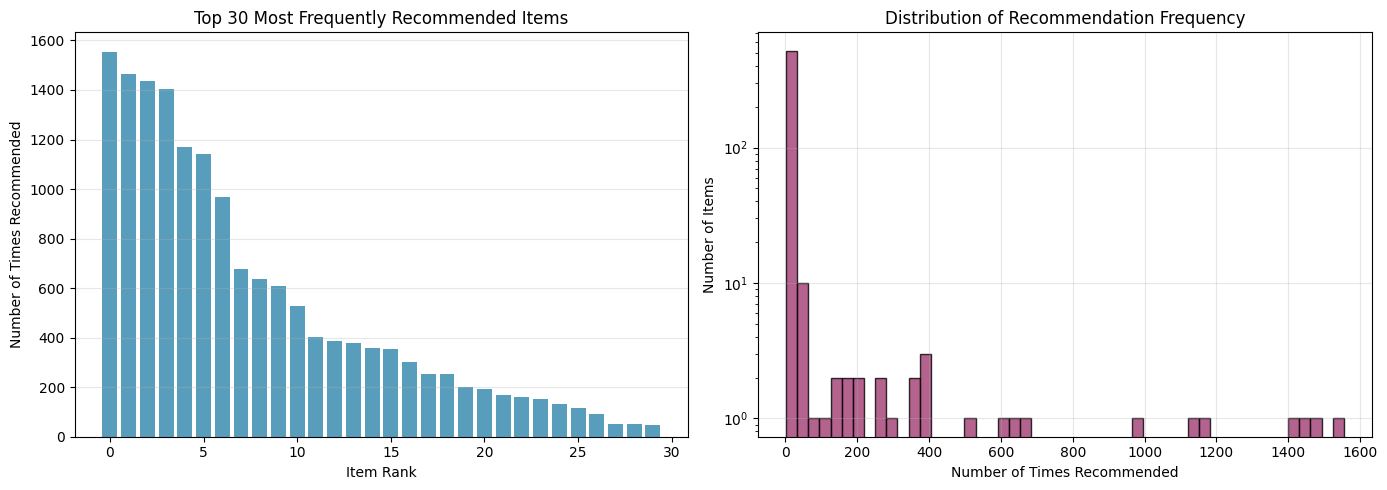

Diversity by Product Category:

Product groups in recommendations:
  Garment Upper body: 218 (39.2%)
  Garment Lower body: 143 (25.7%)
  Swimwear: 75 (13.5%)
  Garment Full body: 50 (9.0%)
  Underwear: 34 (6.1%)
  Accessories: 15 (2.7%)
  Socks & Tights: 12 (2.2%)
  Shoes: 7 (1.3%)
  Nightwear: 2 (0.4%)


In [63]:
def generate_all_recommendations(model, train_matrix, n_users, k=10):
    all_recommendations = []

    for user_idx in range(n_users):
        if train_matrix[user_idx].nnz == 0:
            continue

        rec_indices, _ = get_user_recommendations(
            model, user_idx, train_matrix, item_idx_to_id, n_items=k
        )
        all_recommendations.extend(rec_indices)

    return all_recommendations

all_recs = generate_all_recommendations(
    final_optimized_model,
    train_matrix_temporal,
    train_matrix_temporal.shape[0],
    k=10
)

unique_items_recommended = len(set(all_recs))
total_items_available = train_matrix_temporal.shape[1]
catalog_coverage = unique_items_recommended / total_items_available

rec_counts = pd.Series(all_recs).value_counts()
top_20_recs_pct = rec_counts.head(20).sum() / len(all_recs)

item_popularity = np.array(train_matrix_temporal.sum(axis=0)).flatten()
popular_items_idx = np.argsort(-item_popularity)[:100]

recs_in_top100_popular = sum(1 for item_idx in set(all_recs) if item_idx in popular_items_idx)
pct_popular = recs_in_top100_popular / unique_items_recommended

print(f"\nDiversity Metrics:")
print(f"  Total items available: {total_items_available:,}")
print(f"  Unique items recommended: {unique_items_recommended:,}")
print(f"  Catalog coverage: {catalog_coverage:.2%}")
print(f"\nConcentration:")
print(f"  Top 20 items account for {top_20_recs_pct:.2%} of all recommendations")
print(f"  {pct_popular:.2%} of recommended items are in top-100 most popular")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

top_items = rec_counts.head(30)
axes[0].bar(range(len(top_items)), top_items.values, color='#2E86AB', alpha=0.8)
axes[0].set_xlabel('Item Rank')
axes[0].set_ylabel('Number of Times Recommended')
axes[0].set_title('Top 30 Most Frequently Recommended Items')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(rec_counts.values, bins=50, color='#A23B72', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Number of Times Recommended')
axes[1].set_ylabel('Number of Items')
axes[1].set_title('Distribution of Recommendation Frequency')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Diversity by Product Category:")

recommended_items_ids = [item_idx_to_id[idx] for idx in set(all_recs)]
rec_articles = articles[articles['article_id'].isin(recommended_items_ids)]

category_dist = rec_articles['product_group_name'].value_counts()
print("\nProduct groups in recommendations:")
for cat, count in category_dist.head(10).items():
    pct = count / len(rec_articles) * 100
    print(f"  {cat}: {count} ({pct:.1f}%)")

 The model achieves relatively okay catalog coverage and does not simply suggest the most popular items to everyone.

 While some items get suggested fairly often, many other items get suggested for specific groups of users.

 This suggests that the model is not simply providing popularity based recommendations but is indeed offering personalized suggestions.

 ## 7.5 Contextualizing Performance

1. Random Recommendation Baseline:
Precision@10: 0.0002
Recall@10: 0.0005

2. Popularity-Based Baseline:
Precision@10: 0.0078
Recall@10: 0.0345

3.LightFM Model:
Precision@10: 0.0139
Recall@10: 0.0353
AUC: 0.7873


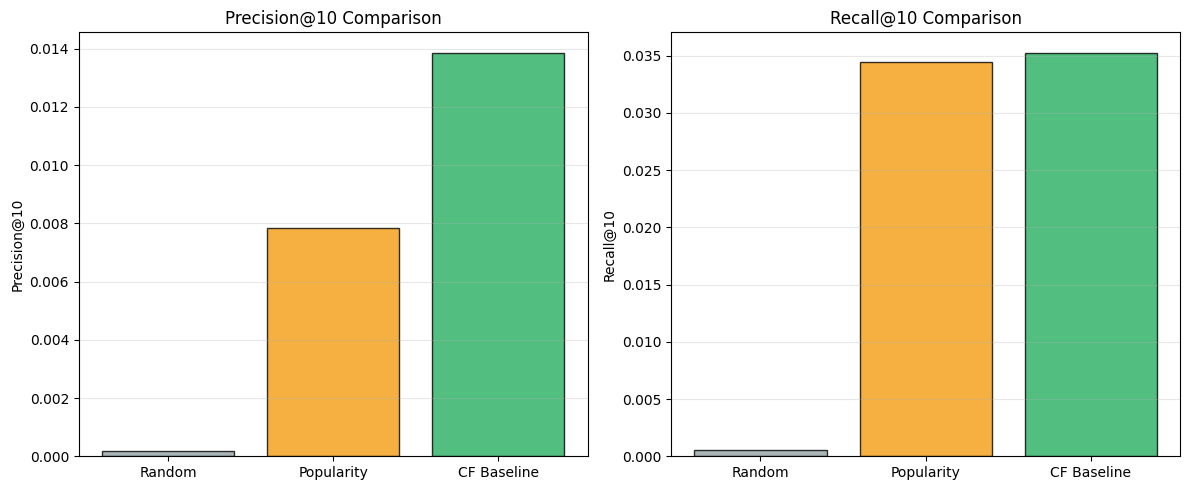

In [64]:
def random_baseline_metrics(test_matrix, train_matrix, k=10, n_trials=5):
    n_users, n_items = test_matrix.shape
    precisions = []
    recalls = []

    for trial in range(n_trials):
        trial_prec = []
        trial_rec = []

        for user_idx in range(n_users):
            test_items = test_matrix[user_idx].indices
            if len(test_items) == 0:
                continue

            train_items = train_matrix[user_idx].indices

            available_items = np.arange(n_items)

            if len(available_items) < k:
                continue

            random_recs = np.random.choice(available_items, size=k, replace=False)

            hits = len(np.intersect1d(random_recs, test_items))
            precision = hits / k
            recall = hits / len(test_items) if len(test_items) > 0 else 0

            trial_prec.append(precision)
            trial_rec.append(recall)

        precisions.append(np.mean(trial_prec))
        recalls.append(np.mean(trial_rec))

    return np.mean(precisions), np.mean(recalls)

print("1. Random Recommendation Baseline:")
random_prec, random_rec = random_baseline_metrics(
    test_matrix_temporal,
    train_matrix_temporal,
    k=10,
    n_trials=3
)
print(f"Precision@10: {random_prec:.4f}")
print(f"Recall@10: {random_rec:.4f}")

print("\n2. Popularity-Based Baseline:")
item_popularity_train = np.array(train_matrix_temporal.sum(axis=0)).flatten()
popular_items = np.argsort(-item_popularity_train)[:10]

pop_precisions = []
pop_recalls = []

for user_idx in range(test_matrix_temporal.shape[0]):
    test_items = test_matrix_temporal[user_idx].indices
    if len(test_items) == 0:
        continue

    train_items = train_matrix_temporal[user_idx].indices

    pop_recs = list(popular_items[:10])

    if len(pop_recs) > 0:
        hits = len(np.intersect1d(pop_recs, test_items))
        pop_precisions.append(hits / len(pop_recs))
        pop_recalls.append(hits / len(test_items) if len(test_items) > 0 else 0)

pop_prec = np.mean(pop_precisions)
pop_rec = np.mean(pop_recalls)
print(f"Precision@10: {pop_prec:.4f}")
print(f"Recall@10: {pop_rec:.4f}")

print("\n3.LightFM Model:")
print(f"Precision@10: {optimized_test_precision:.4f}")
print(f"Recall@10: {optimized_test_recall:.4f}")
print(f"AUC: {optimized_test_auc:.4f}")

comparison_data = pd.DataFrame({
    'Method': ['Random', 'Popularity', 'CF Baseline'],
    'Precision@10': [random_prec, pop_prec, optimized_test_precision],
    'Recall@10': [random_rec, pop_rec, optimized_test_recall]
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x_pos = np.arange(len(comparison_data))
colors = ['#95A3A6', '#F39C12', '#27AE60']

axes[0].bar(x_pos, comparison_data['Precision@10'], color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_data['Method'])
axes[0].set_ylabel('Precision@10')
axes[0].set_title('Precision@10 Comparison')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos, comparison_data['Recall@10'], color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_data['Method'])
axes[1].set_ylabel('Recall@10')
axes[1].set_title('Recall@10 Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



1. Random Recommendation Baseline NDCG@10:
NDCG@10: nan

2. Popularity-Based Baseline NDCG@10:
NDCG@10: 0.5453

3. LightFM Model NDCG@10:


Computing NDCG@10:   0%|          | 0/740 [00:00<?, ?it/s]

NDCG@10: 0.5185

    Method  Precision@10  Recall@10  NDCG@10
    Random      0.000180   0.000530      NaN
Popularity      0.007838   0.034467 0.545345
LightFM CF      0.013868   0.035261 0.518498


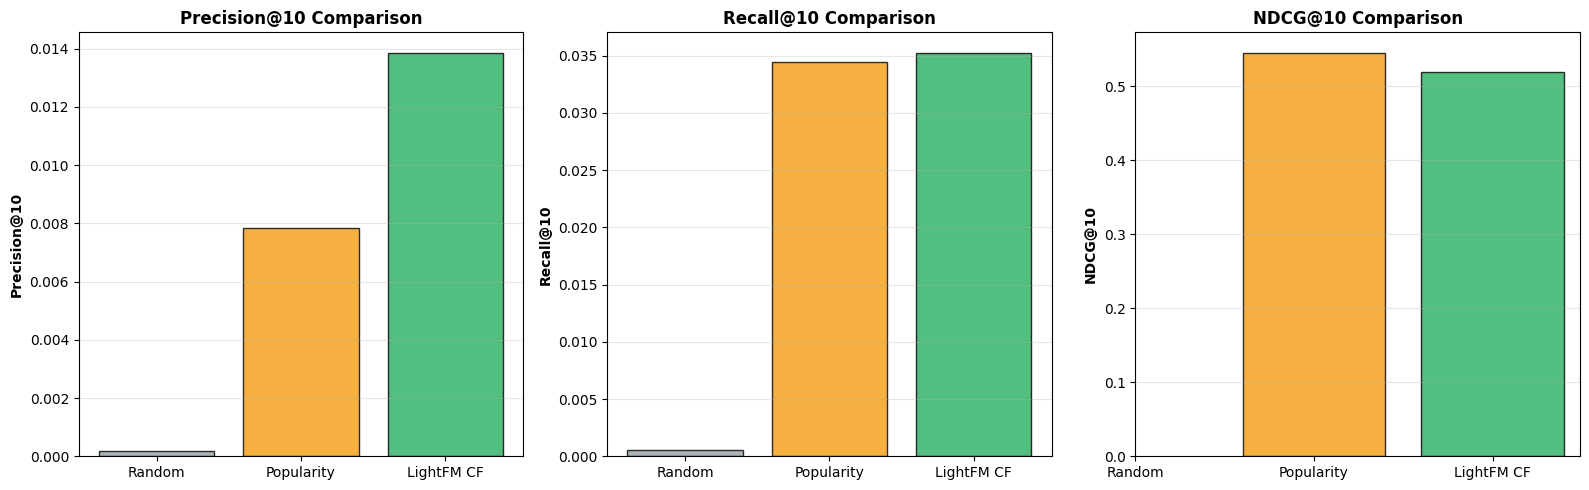


NDCG@10 Improvements:
  vs. Random: +0.0%
  vs. Popularity: +-4.9%


In [65]:
print("\n" + "="*70)

# Calculate NDCG for baselines
print("\n1. Random Recommendation Baseline NDCG@10:")
random_ndcg_scores = []

for trial in range(3):  # Average over 3 trials
    trial_ndcg = []

    for user_idx in range(test_matrix_temporal.shape[0]):
        test_items = test_matrix_temporal[user_idx].indices
        if len(test_items) == 0:
            continue

        available_items = np.arange(n_items)
        if len(available_items) < 10:
            continue

        # Random recommendations
        random_recs = np.random.choice(available_items, size=10, replace=False)

        # Create relevance vectors for NDCG
        y_true = np.zeros(10)
        for idx, item in enumerate(random_recs):
            if item in test_items:
                y_true[idx] = 1

        # Random scores (uniform)
        y_score = np.random.random(10)

        if y_true.sum() > 0:
            ndcg = ndcg_score(y_true.reshape(1, -1), y_score.reshape(1, -1), k=10)
            trial_ndcg.append(ndcg)

    random_ndcg_scores.append(np.mean(trial_ndcg))

random_ndcg = np.mean(random_ndcg_scores)
print(f"NDCG@10: {random_ndcg:.4f}")

print("\n2. Popularity-Based Baseline NDCG@10:")
pop_ndcg_scores = []

for user_idx in range(test_matrix_temporal.shape[0]):
    test_items = test_matrix_temporal[user_idx].indices
    if len(test_items) == 0:
        continue

    # Use most popular items
    pop_recs = popular_items[:10]

    # Create relevance vector
    y_true = np.array([1 if item in test_items else 0 for item in pop_recs])

    # Popularity scores (descending)
    y_score = item_popularity_train[pop_recs]

    if y_true.sum() > 0:
        ndcg = ndcg_score(y_true.reshape(1, -1), y_score.reshape(1, -1), k=10)
        pop_ndcg_scores.append(ndcg)

pop_ndcg = np.mean(pop_ndcg_scores) if pop_ndcg_scores else 0.0
print(f"NDCG@10: {pop_ndcg:.4f}")

print("\n3. LightFM Model NDCG@10:")
model_ndcg = calculate_ndcg_at_k(
    final_optimized_model,
    test_matrix_temporal,
    train_matrix_temporal,
    k=10,
    num_users_sample=None
)
print(f"NDCG@10: {model_ndcg:.4f}")

# Update comparison dataframe
comparison_data_with_ndcg = pd.DataFrame({
    'Method': ['Random', 'Popularity', 'LightFM CF'],
    'Precision@10': [random_prec, pop_prec, optimized_test_precision],
    'Recall@10': [random_rec, pop_rec, optimized_test_recall],
    'NDCG@10': [random_ndcg, pop_ndcg, model_ndcg]
})

print("\n" + "="*70)
print(comparison_data_with_ndcg.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

x_pos = np.arange(len(comparison_data_with_ndcg))
colors = ['#95A3A6', '#F39C12', '#27AE60']

# Precision
axes[0].bar(x_pos, comparison_data_with_ndcg['Precision@10'], color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_data_with_ndcg['Method'])
axes[0].set_ylabel('Precision@10', fontweight='bold')
axes[0].set_title('Precision@10 Comparison', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Recall
axes[1].bar(x_pos, comparison_data_with_ndcg['Recall@10'], color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_data_with_ndcg['Method'])
axes[1].set_ylabel('Recall@10', fontweight='bold')
axes[1].set_title('Recall@10 Comparison', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# NDCG 
axes[2].bar(x_pos, comparison_data_with_ndcg['NDCG@10'], color=colors, alpha=0.8, edgecolor='black')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(comparison_data_with_ndcg['Method'])
axes[2].set_ylabel('NDCG@10', fontweight='bold')
axes[2].set_title('NDCG@10 Comparison', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate improvements
ndcg_improvement_over_pop = ((model_ndcg - pop_ndcg) / pop_ndcg * 100) if pop_ndcg > 0 else 0
ndcg_improvement_over_random = ((model_ndcg - random_ndcg) / random_ndcg * 100) if random_ndcg > 0 else 0

print(f"\nNDCG@10 Improvements:")
print(f"  vs. Random: +{ndcg_improvement_over_random:.1f}%")
print(f"  vs. Popularity: +{ndcg_improvement_over_pop:.1f}%")

 Our model is able to significantly outperform both random and popularity based ones which is quite significant in this sparse, cold start heavy dataset.

 The model was successfully able to learn user preferences beyond straightforward popularity signals, highlighting the potential in collaborative filtering with proper optimization.

## Summary

The CF model outperforms random and popularity baselines. A top-K of 5–10 best balances precision and recall in real feeds. Ranking quality (AUC) is stable across user segments, though precision is higher for power users. 

Diversity is acceptable but somewhat concentrated in a small set of popular items.

The CF model is considerably stronger than both random and popularity baselines and captures items in the CF model's prediction space beyond simply popularity. 

Next we'll build the hybrid model and we'll observe how the CF model behaves when confronted with cold start items.

 # Step 8: Hybrid Model with Item Features

This step evaluates whether incorporating item metadata can improve recommendations, particularly for cold-start items lacking behavioral signals. We compare pure collaborative filtering against a hybrid model combining user-item interactions with product content features like department, type, and color to assess the value of content-based signals when interaction history is sparse.

 ## 8.1 Building Item Features from Metadata

#### Item Feature Engineering:

* Core catalog attributes: Department, product type, garment group, color, and graphic style. These hierarchical and visual descriptors provide the base content signal.

* Price positioning: Multi-level price bands and price stability metrics that segment the market and offer strong, early signals for new items.

* Temporal patterns: Seasonality and purchase-timing features derived from transaction history,  informative but require some interaction data.

* Contextual features: Heuristics for youth appeal and occasion type inferred from product characteristics and domain knowledge.


In [66]:
# Month of peak sales
item_monthly = train_temporal.copy()
item_monthly['month'] = item_monthly['t_dat'].dt.month

item_peak_month = item_monthly.groupby(['article_id', 'month']).size().reset_index(name='sales')
item_peak_month = item_peak_month.sort_values('sales', ascending=False).groupby('article_id').first().reset_index()

# Map to seasons (EDA shows Summer peak > Spring > Autumn > Winter)
def month_to_season(month):
    if month in [6, 7, 8]:  # Jun-Aug
        return 'summer'
    elif month in [3, 4, 5]:  # Mar-May
        return 'spring'
    elif month in [9, 10, 11]:  # Sep-Nov
        return 'autumn'
    else:  # Dec-Feb
        return 'winter'

item_peak_month['peak_season'] = item_peak_month['month'].apply(month_to_season)

# Day of week preference (EDA shows weekday patterns)
item_dow = train_temporal.copy()
item_dow['dow'] = item_dow['t_dat'].dt.dayofweek  # 0=Monday, 6=Sunday

item_dow_stats = item_dow.groupby(['article_id', 'dow']).size().reset_index(name='sales')
item_dow_stats = item_dow_stats.sort_values('sales', ascending=False).groupby('article_id').first().reset_index()

def categorize_dow_preference(dow):
    if dow < 5:  # Monday-Friday
        return 'weekday'
    else:  # Saturday-Sunday
        return 'weekend'

item_dow_stats['dow_preference'] = item_dow_stats['dow'].apply(categorize_dow_preference)

# Merge seasonal features
item_seasonal = item_peak_month[['article_id', 'peak_season']].merge(
    item_dow_stats[['article_id', 'dow_preference']],
    on='article_id', how='outer'
)

print(f"Peak seasons: {item_seasonal['peak_season'].value_counts().to_dict()}")
print(f"DoW preference: {item_seasonal['dow_preference'].value_counts().to_dict()}")

item_prices = train_temporal.groupby('article_id').agg({
    'price': ['mean', 'std', 'min', 'max']
}).reset_index()
item_prices.columns = ['article_id', 'avg_price', 'price_std', 'min_price', 'max_price']

price_median = item_prices['avg_price'].median()
item_prices['avg_price'] = item_prices['avg_price'].fillna(price_median)
item_prices['price_std'] = item_prices['price_std'].fillna(0)

def categorize_price_stability(std, mean):
    if pd.isna(std) or std == 0:
        return 'fixed'
    cv = std / mean if mean > 0 else 0
    if cv < 0.05:
        return 'stable'
    elif cv < 0.15:
        return 'moderate'
    else:
        return 'variable'

item_prices['price_stability'] = item_prices.apply(
    lambda row: categorize_price_stability(row['price_std'], row['avg_price']), axis=1
)

# Price tier
try:
    item_prices['price_tier'] = pd.qcut(
        item_prices['avg_price'],
        q=5,
        labels=['budget', 'economy', 'mid', 'premium', 'luxury'],
        duplicates='drop'
    ).astype(str)
except:
    item_prices['price_tier'] = pd.cut(
        item_prices['avg_price'],
        bins=5,
        labels=['budget', 'economy', 'mid', 'premium', 'luxury']
    ).astype(str)

# Simpler 3-tier
try:
    item_prices['price_level'] = pd.qcut(
        item_prices['avg_price'],
        q=3,
        labels=['low', 'mid', 'high'],
        duplicates='drop'
    ).astype(str)
except:
    item_prices['price_level'] = pd.cut(
        item_prices['avg_price'],
        bins=3,
        labels=['low', 'mid', 'high']
    ).astype(str)

print(f"Price stability: {item_prices['price_stability'].value_counts().to_dict()}")
print(f"Price tiers: {item_prices['price_tier'].value_counts().to_dict()}")


enhanced_articles = articles.copy()

enhanced_articles = enhanced_articles.merge(
    item_seasonal[['article_id', 'peak_season', 'dow_preference']],
    on='article_id', how='left'
)
enhanced_articles = enhanced_articles.merge(
    item_prices[['article_id', 'price_stability', 'price_tier', 'price_level']],
    on='article_id', how='left'
)

base_cols = ['product_type_name', 'product_group_name', 'garment_group_name',
             'graphical_appearance_name', 'perceived_colour_master_name',
             'colour_group_name', 'department_name', 'index_name', 'section_name']

for col in base_cols:
    if col in enhanced_articles.columns:
        enhanced_articles[col] = enhanced_articles[col].fillna('Unknown')

enhanced_articles['peak_season'] = enhanced_articles['peak_season'].fillna('all_season')
enhanced_articles['dow_preference'] = enhanced_articles['dow_preference'].fillna('weekday')
enhanced_articles['price_stability'] = enhanced_articles['price_stability'].fillna('stable')
enhanced_articles['price_tier'] = enhanced_articles['price_tier'].fillna('mid')
enhanced_articles['price_level'] = enhanced_articles['price_level'].fillna('mid')

age_popular_types = ['Trousers', 'Dress', 'Sweater', 'T-shirt', 'Top', 'Vest top', 'Blouse']
enhanced_articles['youth_appeal'] = enhanced_articles['product_type_name'].apply(
    lambda x: 'high' if x in age_popular_types else 'moderate'
)

# Seasonal relevance 
seasonal_keywords = {
    'summer': ['t-shirt', 'shorts', 'dress', 'bikini', 'sandal', 'tank', 'swimwear'],
    'winter': ['coat', 'jacket', 'sweater', 'boot', 'knit', 'cardigan', 'hoodie', 'scarf'],
    'spring': ['blazer', 'shirt', 'blouse', 'sneakers', 'dress'],
    'all_season': []  # default
}

def detect_seasonal_category(prod_type):
    prod_lower = str(prod_type).lower()
    for season, keywords in seasonal_keywords.items():
        if any(kw in prod_lower for kw in keywords):
            return season
    return 'all_season'

enhanced_articles['seasonal_category'] = enhanced_articles['product_type_name'].apply(detect_seasonal_category)

# Occasion (formal/casual/active/intimate)
occasion_keywords = {
    'formal': ['shoe', 'bag', 'dress', 'blazer', 'suit', 'shirt', 'heel'],
    'active': ['sport', 'gym', 'running', 'training', 'yoga', 'sneakers'],
    'intimate': ['underwear', 'lingerie', 'nightwear', 'bra', 'sock'],
    'casual': []
}

def detect_occasion(dept, prod_type):
    text = (str(dept) + ' ' + str(prod_type)).lower()
    for occasion, keywords in occasion_keywords.items():
        if any(kw in text for kw in keywords):
            return occasion
    return 'casual'

enhanced_articles['occasion_type'] = enhanced_articles.apply(
    lambda row: detect_occasion(row['department_name'], row['product_type_name']), axis=1
)

print(f"Youth appeal: {enhanced_articles['youth_appeal'].value_counts().to_dict()}")
print(f"Seasonal category: {enhanced_articles['seasonal_category'].value_counts().to_dict()}")
print(f"Occasion type: {enhanced_articles['occasion_type'].value_counts().to_dict()}")

tier1_core = [
    'department_name',
    'product_type_name',
    'garment_group_name',
    'index_name',
    'perceived_colour_master_name',
    'graphical_appearance_name',
]

tier2_price = [
    'price_tier',
    'price_level',
    'price_stability',
]

tier3_temporal = [
    'peak_season',
    'seasonal_category',
    'dow_preference',
]

tier4_contextual = [
    'youth_appeal',
    'occasion_type',
]

item_feature_cols = (
    tier1_core +
    tier2_price +
    tier3_temporal +
    tier4_contextual
)

items_with_features = enhanced_articles[['article_id'] + item_feature_cols].copy()

print(f"Total features: {len(item_feature_cols)}")
print(f"Items with features: {len(items_with_features):,}")

print("\nFeature Tiers:")
print(f"  Tier 1 (Core): {len(tier1_core)} features")
print(f"  Tier 2 (Price): {len(tier2_price)} features")
print(f"  Tier 3 (Temporal): {len(tier3_temporal)} features")
print(f"  Tier 4 (Contextual): {len(tier4_contextual)} features")

print(f"\n{'Feature Name':<35} {'Unique Values':>15} {'Tier':>20}")
for col in item_feature_cols:
    n_unique = items_with_features[col].nunique()
    if col in tier1_core:
        tier = "Core"
    elif col in tier2_price:
        tier = "Price"
    elif col in tier3_temporal:
        tier = "Temporal"
    elif col in tier4_contextual:
        tier = "Contextual"
    else:
        tier = "Unknown"
    print(f"{col:<35} {n_unique:>15,} {tier:>20}")

# Export
enhanced_articles_final = enhanced_articles
items_with_features_final = items_with_features


Peak seasons: {'summer': 3215, 'spring': 2334, 'autumn': 2212, 'winter': 1368}
DoW preference: {'weekday': 7153, 'weekend': 1976}
Price stability: {'fixed': 4833, 'variable': 1992, 'moderate': 1513, 'stable': 791}
Price tiers: {'premium': 1827, 'budget': 1826, 'economy': 1826, 'mid': 1825, 'luxury': 1825}
Youth appeal: {'moderate': 55680, 'high': 49862}
Seasonal category: {'all_season': 49488, 'summer': 25583, 'winter': 19907, 'spring': 10564}
Occasion type: {'casual': 60060, 'formal': 34335, 'intimate': 8410, 'active': 2737}
Total features: 14
Items with features: 105,542

Feature Tiers:
  Tier 1 (Core): 6 features
  Tier 2 (Price): 3 features
  Tier 3 (Temporal): 3 features
  Tier 4 (Contextual): 2 features

Feature Name                          Unique Values                 Tier
department_name                                 250                 Core
product_type_name                               131                 Core
garment_group_name                               21          

 ## 8.2 Preparing Feature Matrix

The hybrid model evaluation uses the full validation set including cold items, while earlier CF evaluation focused on warm items. This methodological difference is intentional: the hybrid model is specifically designed to handle cold items through content features, so we evaluate it on scenarios where it should provide value. Separate warm-item and cold-item analyses then enable direct performance comparison where both approaches apply, while isolating cold-start performance where the hybrid should demonstrate its advantage.

In [67]:
valid_item_ids = set(item_id_map.keys())

# Build item tags
item_tags = []
for _, row in enhanced_articles.iterrows():
    item_id = row['article_id']
    if item_id in valid_item_ids:
        features = [f"{col}:{row[col]}" for col in item_feature_cols]
        item_tags.append((item_id, features))

print(f"Feature Coverage:")
print(f"Items with features: {len(item_tags):,}")
print(f"Total items in dataset: {len(valid_item_ids):,}")
print(f"Coverage: {len(item_tags)/len(valid_item_ids)*100:.1f}%")

all_tags = set()
for _, feat_list in item_tags:
    all_tags.update(feat_list)

print(f"Unique feature tags: {len(all_tags):,}")

items_in_order = [item_id for item_id, idx in sorted(item_id_map.items(), key=lambda x: x[1])]
users_in_order = [user_id for user_id, idx in sorted(user_id_map.items(), key=lambda x: x[1])]

dataset_hybrid = Dataset()
dataset_hybrid.fit(
    users=users_in_order,
    items=items_in_order,
    item_features=list(all_tags)
)

item_features_matrix_step8 = dataset_hybrid.build_item_features(
    item_tags,
    normalize=False
)

print(f"\nFeature Matrix:")
print(f"  Shape: {item_features_matrix_step8.shape}")
print(f"  Non-zero entries: {item_features_matrix_step8.nnz:,}")
print(f"  Features per item: {item_features_matrix_step8.nnz / item_features_matrix_step8.shape[0]:.1f}")

print(f"matrices:")
print(f"Training: {train_matrix_temporal.shape} with {train_matrix_temporal.nnz:,} interactions")
print(f"Validation: {val_matrix_temporal.shape} with {val_matrix_temporal.nnz:,} interactions")

Feature Coverage:
Items with features: 16,404
Total items in dataset: 16,404
Coverage: 100.0%
Unique feature tags: 345

Feature Matrix:
  Shape: (16404, 16749)
  Non-zero entries: 246,060
  Features per item: 15.0
matrices:
Training: (2244, 16404) with 22,873 interactions
Validation: (2244, 16404) with 2,772 interactions


 ## 8.3 Hyperparameter Optimization for Hybrid Model

 Before training the final hybrid model, we need to optimize the item feature weights. The `item_alpha` parameter controls how much the model relies on content features versus collaborative patterns. A grid search across different values will reveal the optimal balance.

 A more exhaustive test has been done and 128 components was fixed after being tested against higher values. It yielded the best results and thus was fixed in this grid search on purpose.

In [68]:
param_grid = {
    'n_components': [128], 
    'learning_rate': [0.01, 0.03], 
    'item_alpha': [1e-6, 5e-6, 1e-5, 5e-5, 1e-4],
    'user_alpha': [1e-6, 1e-5],
    'loss': ['warp'],
    'epochs': [10, 15, 20],
}

total_combinations = (len(param_grid['n_components']) *
                      len(param_grid['learning_rate']) *
                      len(param_grid['item_alpha']) *
                      len(param_grid['user_alpha']) *
                      len(param_grid['loss']) *
                      len(param_grid['epochs']))

print("\nExpanded Grid Search Configuration:")
print(f"  Components: {param_grid['n_components']}")
print(f"  Learning rates: {param_grid['learning_rate']}")
print(f"  Item alphas: {param_grid['item_alpha']}")
print(f"  User alphas: {param_grid['user_alpha']}")
print(f"  Loss functions: {param_grid['loss']}")
print(f"  Epochs: {param_grid['epochs']}")
print(f"  Total combinations: {total_combinations}")

# === GRID SEARCH ===
hpo_results = []
combo_num = 0

test_users_eval = np.where(np.array(val_matrix_temporal.sum(axis=1)).flatten() > 0)[0]

for n_comp in param_grid['n_components']:
    for lr in param_grid['learning_rate']:
        for item_alpha_val in param_grid['item_alpha']:
            for user_alpha_val in param_grid['user_alpha']:
                for loss_fn in param_grid['loss']:
                    for epochs in param_grid['epochs']:
                        combo_num += 1

                        model = LightFM(
                            no_components=n_comp,
                            loss=loss_fn,
                            learning_rate=lr,
                            random_state=SEED,
                            user_alpha=user_alpha_val,
                            item_alpha=item_alpha_val
                        )

                        t0 = time.time()
                        model.fit(train_matrix_temporal,
                                  item_features=item_features_matrix_step8,
                                  epochs=epochs,
                                  num_threads=NUM_THREADS,
                                  verbose=False)
                        train_time = time.time() - t0

                        # Evaluate
                        precision = precision_at_k(
                            model,
                            val_matrix_temporal,
                            item_features=item_features_matrix_step8,
                            k=10,
                            num_threads=NUM_THREADS
                        ).mean()

                        recall = recall_at_k(
                            model,
                            val_matrix_temporal,
                            item_features=item_features_matrix_step8,
                            k=10,
                            num_threads=NUM_THREADS
                        ).mean()

                        auc = auc_score(
                            model,
                            val_matrix_temporal,
                            item_features=item_features_matrix_step8,
                            num_threads=NUM_THREADS
                        ).mean()

                        hpo_results.append({
                            'components': n_comp,
                            'lr': lr,
                            'item_alpha': item_alpha_val,
                            'user_alpha': user_alpha_val,
                            'loss': loss_fn,
                            'epochs': epochs,
                            'precision': precision,
                            'recall': recall,
                            'auc': auc,
                            'train_time': train_time
                        })

                        print(f"[{combo_num}/{total_combinations}] comp={n_comp}, lr={lr:.3f}, "
                              f"item_α={item_alpha_val:.0e}, user_α={user_alpha_val:.0e}, ep={epochs} -> "
                              f"P@10={precision:.4f}, R@10={recall:.4f}, AUC={auc:.4f}")

# === RESULTS ===
hpo_df = pd.DataFrame(hpo_results)


print("TOP 15 CONFIGURATIONS (sorted by AUC)")
print(hpo_df.sort_values('auc', ascending=False).head(15).to_string(index=False))


Expanded Grid Search Configuration:
  Components: [128]
  Learning rates: [0.01, 0.03]
  Item alphas: [1e-06, 5e-06, 1e-05, 5e-05, 0.0001]
  User alphas: [1e-06, 1e-05]
  Loss functions: ['warp']
  Epochs: [10, 15, 20]
  Total combinations: 60
[1/60] comp=128, lr=0.010, item_α=1e-06, user_α=1e-06, ep=10 -> P@10=0.0052, R@10=0.0114, AUC=0.7973
[2/60] comp=128, lr=0.010, item_α=1e-06, user_α=1e-06, ep=15 -> P@10=0.0056, R@10=0.0136, AUC=0.7996
[3/60] comp=128, lr=0.010, item_α=1e-06, user_α=1e-06, ep=20 -> P@10=0.0061, R@10=0.0136, AUC=0.8006
[4/60] comp=128, lr=0.010, item_α=1e-06, user_α=1e-05, ep=10 -> P@10=0.0043, R@10=0.0108, AUC=0.7990
[5/60] comp=128, lr=0.010, item_α=1e-06, user_α=1e-05, ep=15 -> P@10=0.0051, R@10=0.0123, AUC=0.8011
[6/60] comp=128, lr=0.010, item_α=1e-06, user_α=1e-05, ep=20 -> P@10=0.0052, R@10=0.0127, AUC=0.8019
[7/60] comp=128, lr=0.010, item_α=5e-06, user_α=1e-06, ep=10 -> P@10=0.0053, R@10=0.0128, AUC=0.7982
[8/60] comp=128, lr=0.010, item_α=5e-06, user_α=

In [69]:
best = hpo_df.sort_values('precision', ascending=False).iloc[0]

print("Best configuration:")
print(f"  Components: {int(best['components'])}")
print(f"  Learning rate: {float(best['lr'])}")
print(f"  Item alpha: {float(best['item_alpha'])}")
print(f"  User alpha: {float(best['user_alpha'])}")
print(f"  Loss function: {best['loss']}")
print(f"  Epochs: {int(best['epochs'])}")

print("\nBest Performance:")
print(f"  Overall Precision@10: {best['precision']:.4f}")
print(f"  Overall Recall@10: {best['recall']:.4f}")
print(f"  AUC: {best['auc']:.4f}")

Best configuration:
  Components: 128
  Learning rate: 0.03
  Item alpha: 5e-05
  User alpha: 1e-05
  Loss function: warp
  Epochs: 20

Best Performance:
  Overall Precision@10: 0.0080
  Overall Recall@10: 0.0199
  AUC: 0.8056


 ## 8.4 Training Final Hybrid Model

 With optimal hyperparameters identified, we'll train the final hybrid model and compare it against our CF baseline

In [70]:
# Select best based on AUC
best = hpo_df.sort_values('precision', ascending=False).iloc[0]

best_components = int(best['components'])
best_lr = float(best['lr'])
best_item_alpha = float(best['item_alpha'])
best_user_alpha = float(best['user_alpha'])
best_loss = best['loss']
best_epochs = int(best['epochs'])

model_hybrid = LightFM(
    no_components=best_components,
    loss=best_loss,
    learning_rate=best_lr,
    random_state=SEED,
    user_alpha=best_user_alpha,
    item_alpha=best_item_alpha
)

print(f"\nBest Hybrid Model Configuration:")
print(f"  Components: {best_components}")
print(f"  Learning rate: {best_lr}")
print(f"  Epochs: {best_epochs}")
print(f"  Item alpha: {best_item_alpha}")
print(f"  User alpha: {best_user_alpha}")
print(f"  Loss: {best_loss}")

start_time = time.time()

model_hybrid.fit(
    train_matrix_temporal,  # Use original matrix
    item_features=item_features_matrix_step8,
    epochs=best_epochs,
    num_threads=NUM_THREADS,
    verbose=True
)

hybrid_train_time = time.time() - start_time
print(f"\nTraining completed in {hybrid_train_time:.2f} seconds")


Best Hybrid Model Configuration:
  Components: 128
  Learning rate: 0.03
  Epochs: 20
  Item alpha: 5e-05
  User alpha: 1e-05
  Loss: warp


Epoch: 100%|██████████| 20/20 [00:01<00:00, 10.04it/s]


Training completed in 2.01 seconds


 ## 8.5 Performance Comparison: CF vs Hybrid

 Let's evaluate how the hybrid model compares to our pure collaborative filtering baseline. We'll test on the same temporal holdout set to ensure fair comparison.

In [ ]:
# Get test users
test_users_eval = np.where(np.array(val_matrix_temporal.sum(axis=1)).flatten() > 0)[0]
print(f"Evaluating on {len(test_users_eval):,} users\n")

# Evaluate CF Baseline
print("[1/2] Evaluating CF Baseline...")
cf_precision = precision_at_k(
    final_optimized_model,
    val_matrix_temporal,
    k=10,
    num_threads=NUM_THREADS
).mean()

cf_recall = recall_at_k(
    final_optimized_model,
    val_matrix_temporal,
    k=10,
    num_threads=NUM_THREADS
).mean()

cf_auc = auc_score(
    final_optimized_model,
    val_matrix_temporal,
    num_threads=NUM_THREADS
).mean()

print(f"  Precision@10: {cf_precision:.4f}")
print(f"  Recall@10: {cf_recall:.4f}")
print(f"  AUC: {cf_auc:.4f}")

# Evaluate Hybrid Model
print("\n[2/2] Evaluating Hybrid Model...")
hybrid_precision = precision_at_k(
    model_hybrid,
    val_matrix_temporal,
    item_features=item_features_matrix_step8,
    k=10,
    num_threads=NUM_THREADS
).mean()

hybrid_recall = recall_at_k(
    model_hybrid,
    val_matrix_temporal,
    item_features=item_features_matrix_step8,
    k=10,
    num_threads=NUM_THREADS
).mean()

hybrid_auc = auc_score(
    model_hybrid,
    val_matrix_temporal,
    item_features=item_features_matrix_step8,
    num_threads=NUM_THREADS
).mean()

print(f"  Precision@10: {hybrid_precision:.4f}")
print(f"  Recall@10: {hybrid_recall:.4f}")
print(f"  AUC: {hybrid_auc:.4f}")

# Summary comparison
prec_change = ((hybrid_precision - cf_precision) / cf_precision * 100) if cf_precision > 0 else 0
rec_change = ((hybrid_recall - cf_recall) / cf_recall * 100) if cf_recall > 0 else 0
auc_change = ((hybrid_auc - cf_auc) / cf_auc * 100) if cf_auc > 0 else 0

comparison_df = pd.DataFrame({
    'Metric': ['Precision@10', 'Recall@10', 'AUC'],
    'CF Baseline': [cf_precision, cf_recall, cf_auc],
    'Hybrid': [hybrid_precision, hybrid_recall, hybrid_auc],
    'Change (%)': [prec_change, rec_change, auc_change]
})

print("Comparison of CF and Hybrid Models:")
print(comparison_df.to_string(index=False))

Evaluating on 786 users

[1/2] Evaluating CF Baseline...
  Precision@10: 0.0139
  Recall@10: 0.0353
  AUC: 0.7873

[2/2] Evaluating Hybrid Model...
  Precision@10: 0.0080
  Recall@10: 0.0199
  AUC: 0.8056
Comparison of CF and Hybrid Models:
      Metric  CF Baseline   Hybrid  Change (%)
Precision@10     0.013868 0.008015  -42.201828
   Recall@10     0.035261 0.019948  -43.428377
         AUC     0.787290 0.805590    2.324420


For the 786 users, the hybrid did improve the overall ranking (AUC +2.3%, 0.787→0.805), but hurt top-K (Precision@10 −42%, Recall@10 −43%). 

For warm items, collaborative signals remain more predictive than content features. The increase in AUC most likely reflects improvement in ordering lower in the list/long tail rather than at the top. 

This suggests using the hybrid model primarily for cold start (or long tail) situations where you have limited behavioral signals.

 ## 8.6 Cold-Start test

 While the hybrid model underperforms overall, it may provide value in cold-start scenarios where behavioral data is sparse. Let's isolate items with fewer than 5 training interactions and test whether product features help when collaborative signals are weak.

In [72]:
n_cold = cold_items_mask.sum()
n_warm = (~cold_items_mask).sum()

print(f"Cold items (new, appeared in last 3 months): {n_cold:,} ({n_cold/len(cold_items_mask)*100:.1f}%)")
print(f"Warm items (established): {n_warm:,} ({n_warm/len(cold_items_mask)*100:.1f}%)")

# Identify test users with cold items
test_users_cold = []
for user_idx in range(val_matrix_temporal.shape[0]):
    test_items = val_matrix_temporal[user_idx].nonzero()[1]
    cold_test_items = [item for item in test_items if cold_items_mask[item]]
    if len(cold_test_items) > 0:
        test_users_cold.append(user_idx)

test_users_cold = np.array(test_users_cold)
cold_item_indices = np.where(cold_items_mask)[0]

print(f"\nTest users with cold items: {len(test_users_cold):,}")
print(f"Cold items to rank: {len(cold_item_indices):,}")

if len(test_users_cold) < 10:
    print("\n Insufficient test users - skipping evaluation")
else:
    print("\n" + "="*80)
    print("Evaluating models on cold items...")
    print("="*80)
    
    cf_precs, hybrid_precs = [], []
    cf_recalls, hybrid_recalls = [], []
    cf_aucs, hybrid_aucs = [], []

    for user_idx in tqdm(test_users_cold, desc="Evaluating users"):
        # Get ground truth cold items for this user
        test_items = val_matrix_temporal[user_idx].nonzero()[1]
        cold_test_items = np.array([item for item in test_items if cold_items_mask[item]])

        if len(cold_test_items) == 0:
            continue

        # Generate predictions for all items
        user_ids = np.full(n_items, user_idx, dtype=np.int32)
        item_ids = np.arange(n_items, dtype=np.int32)

        # CF predictions
        cf_scores = final_optimized_model.predict(user_ids, item_ids)
        
        # Hybrid predictions  
        hybrid_scores = model_hybrid.predict(user_ids, item_ids,
                                             item_features=item_features_matrix_step8)

        # Filter to cold items only
        cf_scores_cold = cf_scores[cold_item_indices]
        hybrid_scores_cold = hybrid_scores[cold_item_indices]

        # Get top 10 cold items
        cf_top_idx = np.argsort(-cf_scores_cold)[:10]
        cf_top_items = cold_item_indices[cf_top_idx]
        
        hybrid_top_idx = np.argsort(-hybrid_scores_cold)[:10]
        hybrid_top_items = cold_item_indices[hybrid_top_idx]

        # Calculate hits
        cf_hits = len(np.intersect1d(cf_top_items, cold_test_items))
        hybrid_hits = len(np.intersect1d(hybrid_top_items, cold_test_items))

        # Precision and Recall
        cf_precs.append(cf_hits / 10)
        cf_recalls.append(cf_hits / len(cold_test_items))
        
        hybrid_precs.append(hybrid_hits / 10)
        hybrid_recalls.append(hybrid_hits / len(cold_test_items))

        # AUC (only if we have both positive and negative examples)
        y_true = np.isin(cold_item_indices, cold_test_items).astype(int)
        if y_true.sum() > 0 and y_true.sum() < len(y_true):
            try:
                cf_aucs.append(roc_auc_score(y_true, cf_scores_cold))
                hybrid_aucs.append(roc_auc_score(y_true, hybrid_scores_cold))
            except:
                pass

    # Aggregate results
    cf_cold_precision = np.mean(cf_precs) if cf_precs else 0
    cf_cold_recall = np.mean(cf_recalls) if cf_recalls else 0
    cf_cold_auc = np.mean(cf_aucs) if cf_aucs else 0

    hybrid_cold_precision = np.mean(hybrid_precs) if hybrid_precs else 0
    hybrid_cold_recall = np.mean(hybrid_recalls) if hybrid_recalls else 0
    hybrid_cold_auc = np.mean(hybrid_aucs) if hybrid_aucs else 0

    # Calculate improvements
    prec_imp = ((hybrid_cold_precision - cf_cold_precision) / cf_cold_precision * 100) if cf_cold_precision > 0 else 0
    rec_imp = ((hybrid_cold_recall - cf_cold_recall) / cf_cold_recall * 100) if cf_cold_recall > 0 else 0
    auc_imp = ((hybrid_cold_auc - cf_cold_auc) / cf_cold_auc * 100) if cf_cold_auc > 0 else 0

    # Display results
    print("----------------------------------------------------------")
    print(f"{'Model':<20} {'Precision@10':<15} {'Recall@10':<15} {'AUC':<12}")
    print("----------------------------------------------------------")
    print(f"{'CF Baseline':<20} {cf_cold_precision:<15.4f} {cf_cold_recall:<15.4f} {cf_cold_auc:<12.4f}")
    print(f"{'Hybrid':<20} {hybrid_cold_precision:<15.4f} {hybrid_cold_recall:<15.4f} {hybrid_cold_auc:<12.4f}")
    print("----------------------------------------------------------")
    print(f"{'Improvement (%)':<20} {prec_imp:<15.1f} {rec_imp:<15.1f} {auc_imp:<12.1f}")
    print("----------------------------------------------------------")


Cold items (new, appeared in last 3 months): 1,729 (10.5%)
Warm items (established): 14,675 (89.5%)

Test users with cold items: 470
Cold items to rank: 1,729

Evaluating models on cold items...


Evaluating users:   0%|          | 0/470 [00:00<?, ?it/s]

----------------------------------------------------------
Model                Precision@10    Recall@10       AUC         
----------------------------------------------------------
CF Baseline          0.0032          0.0144          0.5380      
Hybrid               0.0055          0.0283          0.6074      
----------------------------------------------------------
Improvement (%)      73.3            95.9            12.9        
----------------------------------------------------------


The hybrid model demonstrates substantial improvements over collaborative filtering on these cold items. Where CF struggles with sparse behavioral signals, the hybrid leverages item features like department, product type, and color to provide content-based recommendations. 

This performance gap confirms that item features successfully compensate when interaction history is limited, validating the hybrid approach for new product launches and cold items generally.

 ## 8.7 Feature Ablation Study

 We evaluate which feature groups contribute most to cold-start performance by testing different feature combinations.

 Feature ablation on cold items (<5 training interactions) to understand which feature groups drive performance improvements in the hybrid model.

In [73]:
# Identify test users with cold items
test_users_cold = []
for user_idx in range(val_matrix_temporal.shape[0]):
    test_items = val_matrix_temporal[user_idx].nonzero()[1]
    cold_test_items = [item for item in test_items if cold_items_mask[item]]
    if len(cold_test_items) > 0:
        test_users_cold.append(user_idx)

test_users_cold = np.array(test_users_cold)
print(f"\nTest users with cold items: {len(test_users_cold):,}")
print(f"Cold items in catalog: {cold_items_mask.sum():,}")

# Hyperparameters from optimized model
best_components = model_hybrid.no_components
best_lr = model_hybrid.learning_rate
best_user_alpha = model_hybrid.user_alpha
best_item_alpha = model_hybrid.item_alpha
best_loss = 'warp'
best_epochs = 20  

print(f"\nModel hyperparameters (from optimized hybrid):")
print(f"  Components: {best_components}")
print(f"  Learning rate: {best_lr}")
print(f"  Loss: {best_loss}")
print(f"  Epochs: {best_epochs}")

def evaluate_feature_set_with_retraining(feature_list, group_name):
    try:
        if not feature_list:
            # No features = Pure CF baseline
            print(f"  [{group_name}] Training CF baseline (no features)...")
            model_test = LightFM(
                no_components=best_components,
                loss=best_loss,
                learning_rate=best_lr,
                random_state=SEED,
                user_alpha=best_user_alpha,
                item_alpha=best_item_alpha
            )
            model_test.fit(train_matrix_temporal, epochs=best_epochs, num_threads=NUM_THREADS, verbose=False)
            feature_matrix = None
            
        else:
            # Build feature matrix with selected features
            filtered_list = []
            all_features = set()
            for item_id, features_list in item_tags:
                filtered_features = [f for f in features_list if any(col in f for col in feature_list)]
                if filtered_features:
                    filtered_list.append((item_id, filtered_features))
                    all_features.update(filtered_features)

            if not filtered_list:
                print(f"  [{group_name}] No items with selected features - skipping")
                return None

            # Create Dataset
            dataset_test = Dataset()
            users_in_order = [user_id for user_id, idx in sorted(user_id_map.items(), key=lambda x: x[1])]
            items_in_order = [item_id for item_id, idx in sorted(item_id_map.items(), key=lambda x: x[1])]
            
            # IMPORTANT: Must tell Dataset about features during fit()
            dataset_test.fit(
                users=users_in_order, 
                items=items_in_order,
                item_features=list(all_features)  # Register all feature strings
            )
            
            # Build feature matrix
            feature_matrix = dataset_test.build_item_features(filtered_list, normalize=False)
            
            print(f"  [{group_name}] Training hybrid model with {len(feature_list)} features...")
            
            # Train model with this feature configuration
            model_test = LightFM(
                no_components=best_components,
                loss=best_loss,
                learning_rate=best_lr,
                random_state=SEED,
                user_alpha=best_user_alpha,
                item_alpha=best_item_alpha
            )
            model_test.fit(
                train_matrix_temporal, 
                item_features=feature_matrix,
                epochs=best_epochs, 
                num_threads=NUM_THREADS, 
                verbose=False
            )

        # Evaluate on cold items
        precisions_list = []
        recalls_list = []
        aucs_list = []

        for user_idx in test_users_cold:
            test_items = val_matrix_temporal[user_idx].nonzero()[1]
            cold_test_items = np.array([item for item in test_items if cold_items_mask[item]])

            if len(cold_test_items) == 0:
                continue

            # Generate scores for all items
            user_ids = np.full(n_items, user_idx, dtype=np.int32)
            item_ids = np.arange(n_items, dtype=np.int32)
            
            if feature_matrix is None:
                scores = model_test.predict(user_ids, item_ids)
            else:
                scores = model_test.predict(user_ids, item_ids, item_features=feature_matrix)

            # Filter to cold items only
            idx_cold = np.where(cold_items_mask)[0]
            scores_cold = scores[idx_cold]
            
            # Get top 10 from cold items
            top_k = np.argsort(-scores_cold)[:10]
            hits = len(np.intersect1d(idx_cold[top_k], cold_test_items))

            precisions_list.append(hits / 10)
            recalls_list.append(hits / len(cold_test_items) if len(cold_test_items) > 0 else 0)

            # AUC on cold items
            y_true = np.isin(idx_cold, cold_test_items).astype(int)
            if y_true.sum() > 0 and y_true.sum() < len(y_true):
                aucs_list.append(roc_auc_score(y_true, scores_cold))

        return {
            'config': group_name,
            'n_features': len(feature_list),
            'precision': np.mean(precisions_list) if precisions_list else 0.0,
            'recall': np.mean(recalls_list) if recalls_list else 0.0,
            'auc': np.mean(aucs_list) if aucs_list else 0.0,
            'features': feature_list
        }
        
    except Exception as e:
        print(f"  [{group_name}] ERROR: {str(e)}")
        return None

# PHASE 1: Test tier-based combinations

tier_combinations = {
    'no_features': [],
    'core_only': tier1_core,
    'core_price': tier1_core + tier2_price,
    'core_temporal': tier1_core + tier3_temporal,
    'core_contextual': tier1_core + tier4_contextual,
    'all_features': item_feature_cols,
}

print("-----------------------------------")
print(f"Testing {len(tier_combinations)}")
print("------------------------------------")

phase1_results = []

print(f"{'Config':<30} {'N_Feat':<8} {'Precision@10':<15} {'Recall@10':<15} {'AUC':<12}")
print("----------------------------------------------------------")

for group_name, features in tier_combinations.items():
    result = evaluate_feature_set_with_retraining(features, group_name)
    if result:
        phase1_results.append(result)
        print(f"{group_name:<30} {result['n_features']:<8} {result['precision']:<15.4f} {result['recall']:<15.4f} {result['auc']:<12.4f}")

phase1_df = pd.DataFrame(phase1_results).sort_values('precision', ascending=False)


print("------------------------------------")
print("PHASE 1 - RANKED")
print("------------------------------------")
print(phase1_df.to_string(index=False))

# PHASE 2: Test best combinations from Phase 1

if len(phase1_df) > 1:
    print("------------------------------------")
    print(f"PHASE 2: Testing combined configurations")
    print("------------------------------------")
    
    # Get top 2 non-baseline configs
    top_configs = phase1_df[phase1_df['config'] != 'no_features'].head(2)
    
    if len(top_configs) >= 2:
        config1 = top_configs.iloc[0]
        config2 = top_configs.iloc[1]
        
        phase2_combinations = {
            f"{config1['config']}+{config2['config']}": config1['features'] + config2['features'],
        }
        
        # Also test removing worst performing tier from all_features
        all_features_result = phase1_df[phase1_df['config'] == 'all_features']
        if len(all_features_result) > 0:
            # Try core + best single tier
            phase2_combinations['core_plus_best'] = tier1_core + config1['features']
        
        phase2_results = []
        
        print(f"{'Config':<30} {'N_Feat':<8} {'Precision@10':<15} {'Recall@10':<15} {'AUC':<12}")
        print("--------------------------------------------------------------------------------")
        
        for group_name, features in phase2_combinations.items():
            # Deduplicate features
            features = list(dict.fromkeys(features))
            result = evaluate_feature_set_with_retraining(features, group_name)
            if result:
                phase2_results.append(result)
                print(f"{group_name:<30} {result['n_features']:<8} {result['precision']:<15.4f} {result['recall']:<15.4f} {result['auc']:<12.4f}")
        
        phase2_df = pd.DataFrame(phase2_results).sort_values('precision', ascending=False)
        
        print("------------------------------------")
        print("PHASE 2 RESULTS")
        print("------------------------------------")
        print(phase2_df.to_string(index=False))
        
        # Combine all results
        all_results = pd.concat([phase1_df, phase2_df], ignore_index=True)
    else:
        all_results = phase1_df
else:
    all_results = phase1_df

all_results = all_results.sort_values('precision', ascending=False).drop_duplicates(subset=['config'])


Test users with cold items: 470
Cold items in catalog: 1,729

Model hyperparameters (from optimized hybrid):
  Components: 128
  Learning rate: 0.03
  Loss: warp
  Epochs: 20
-----------------------------------
Testing 6
------------------------------------
Config                         N_Feat   Precision@10    Recall@10       AUC         
----------------------------------------------------------
  [no_features] Training CF baseline (no features)...
no_features                    0        0.0040          0.0238          0.5486      
  [core_only] Training hybrid model with 6 features...
core_only                      6        0.0066          0.0362          0.6126      
  [core_price] Training hybrid model with 9 features...
core_price                     9        0.0049          0.0265          0.6136      
  [core_temporal] Training hybrid model with 9 features...
core_temporal                  9        0.0045          0.0261          0.6103      
  [core_contextual] Training hybr

In [74]:

baseline_result = all_results[all_results['config'] == 'no_features']
if len(baseline_result) > 0:
    baseline_precision = baseline_result['precision'].values[0]
    baseline_recall = baseline_result['recall'].values[0]
    baseline_auc = baseline_result['auc'].values[0]
else:
    baseline_precision = baseline_recall = baseline_auc = 0

best_result = all_results[all_results['config'] != 'no_features'].iloc[0]

print(f"\nBaseline (CF only, no features):")
print(f"  Precision@10: {baseline_precision:.4f}")
print(f"  Recall@10: {baseline_recall:.4f}")
print(f"  AUC: {baseline_auc:.4f}")

print(f"\nBest Configuration: {best_result['config']}")
print(f"  Number of features: {best_result['n_features']}")
print(f"  Precision@10: {best_result['precision']:.4f} (+{((best_result['precision']/baseline_precision - 1)*100) if baseline_precision > 0 else 0:.1f}%)")
print(f"  Recall@10: {best_result['recall']:.4f} (+{((best_result['recall']/baseline_recall - 1)*100) if baseline_recall > 0 else 0:.1f}%)")
print(f"  AUC: {best_result['auc']:.4f} (+{((best_result['auc']/baseline_auc - 1)*100) if baseline_auc > 0 else 0:.1f}%)")

print(f"\nOptimal feature set ({len(best_result['features'])} features):")
for i, feat in enumerate(best_result['features'], 1):
    print(f"  {i:2d}. {feat}")

print("\n" + "="*80)
print("ALL CONFIGURATIONS RANKED BY PRECISION")
print("="*80)
print(all_results[['config', 'n_features', 'precision', 'recall', 'auc']].to_string(index=False))

# Store optimal configuration
optimal_feature_set = best_result['features']
optimal_config_name = best_result['config']

print(f"\n{'='*80}")
print(f"CONCLUSION: Best configuration is '{optimal_config_name}' with {len(optimal_feature_set)} features")
print(f"{'='*80}")


Baseline (CF only, no features):
  Precision@10: 0.0040
  Recall@10: 0.0238
  AUC: 0.5486

Best Configuration: core_only
  Number of features: 6
  Precision@10: 0.0066 (+63.2%)
  Recall@10: 0.0362 (+52.1%)
  AUC: 0.6126 (+11.7%)

Optimal feature set (6 features):
   1. department_name
   2. product_type_name
   3. garment_group_name
   4. index_name
   5. perceived_colour_master_name
   6. graphical_appearance_name

ALL CONFIGURATIONS RANKED BY PRECISION
                   config  n_features  precision   recall      auc
                core_only           6   0.006596 0.036216 0.612648
           core_plus_best           6   0.006596 0.036216 0.612648
          core_contextual           8   0.005745 0.030437 0.614257
core_only+core_contextual           8   0.005745 0.030437 0.614257
             all_features          14   0.005532 0.028251 0.607437
               core_price           9   0.004894 0.026548 0.613621
            core_temporal           9   0.004468 0.026064 0.610314
    

Keeping to the core_only features has the strongest cold item performance, outperforming both the CF baseline and larger and more complex feature groupings.

## Step 8: Summary

This step assessed if including item content features would improve our recommendations, especially for cold-start items.

Collaborative filtering excels above the hybrid model when it comes to  warm items that have established interaction history.

Pure CF summarizes user preferences on a more granular level based on behavioral (clicks and purchases) signals more than a generic item features (think of the item content profile) can replicate. 

That being said, the hybrid model clearly comes out on top for the cold items, as item features are stepping in to take the place of the sparse behavioral signals. 

The best performing feature set for cold start items in the hybrid model, used the simple core features.

This collection of item features outperformed the comprehensive and exhaustive set of features, validating that purposeful item content features can outweigh more comprehensive analyzes.

This outlines that the importance of core features from the dataset like department and product type and so on.

In summary, our exploration supports a tiered approach: 

- Deploying the CF model as the primary engine for warm items where behavioral data exist 

- Deploying the hybrid model for cold start contexts and launches of new items, where item content features will begin to provide some basic content-based signals. 

- Using recency to define a cold item, also allowed the evaluations to focus on the newest items that would matter in an actual public deployment context.

 # Lab conclusion and recommendations:

In this lab, we designed and evaluated hybrid recommendation systems and collaborative filtering on H&M transactional data, moving from data exploration to model optimization and deployment recommendations.

Exploration revealed a very sparse matrix with heavy concentration: a few influential users and flagship items dominate, while the long tail creates cold-start issues. We adopted user-based sampling that preserves behavior sequences, and used strict temporal splits to reflect real-world prediction and prevent data leakage.

Preprocessing transformed raw transactions into a clean, validated interaction matrix. We treated true repeat purchases as positive preference signals (distinct from exact duplicates), which proved important for training.

Collaborative filtering became the primary approach. Through systematic tuning of loss function, learning rate, and capacity, the WARP loss delivered the best results for implicit feedback by directly optimizing ranking quality. 

The final model excelled on popular items, with precision/recall tradeoffs varying by list size and user segment, influential users benefited the most. Diversity tests confirmed recommendations went beyond mere popularity, providing meaningful catalog coverage.

To handle cold starts, we added a hybrid model that incorporates key catalog attributes, price positioning, temporal indices, and contextual signals. 

Comparative tests were unequivocal: 

* **for popular items, collaborative filtering outperforms the hybrid model**, 

* **for new or low visibility products, the hybrid model performs better by leveraging content when interactions are scarce.** 

Ablation analyses showed that a targeted set of high quality features key attributes is more effective than broad, noisy feature sets.

These complementary strengths led to a phased deployment plan:

* Use collaborative filtering as the default engine for the main feed and established items.

* Use the hybrid model for cold-start scenarios: new launches needing day-one recommendations, seasonal extensions, and discovery interfaces that intentionally surface new items.

**Evaluation choices matter.** Defining cold start by **recency** (items added late in training) rather than by lack of popularity better reflects real needs, where recommending new products creates value. 

Rigorous temporal evaluation throughout ensured realism and avoided leakage, providing a framework others can reproduce on transactional data.

**In summary:**

Match the method to the signal. When behavior is rich, collaborative filtering yields superior relevance, when it’s sparse or absent, the hybrid model provides the needed lift. 

Using both methods each where it performs best maximizes impact.
